# PREDICTIVE ML MODEL TRAINING THROUGH CMAPSS DATA SET 

### Set-up & Imports

In [114]:
# 0/ Setup & minimal imports (clean)
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score
import time
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Reproducibility
random.seed(42)
np.random.seed(42)

# Display options for readable, aligned outputs
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Small helpers for tidy logs
def print_header(title: str):
    line = '=' * 70
    print(f"\n{line}\n{title}\n{line}")

def print_kv(pairs):
    # pairs: list of (key, value)
    width = max(len(str(k)) for k, _ in pairs) if pairs else 0
    for k, v in pairs:
        print(f"{str(k).ljust(width)} : {v}")

def rmse(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

# store results for comparison of trained models
results_dict = {}

print("Setup complete")

Setup complete


## 1) Data Loading

In [56]:
# 1/ Load FD001 (train/test/rul)
print_header("Loading CMAPSS FD001")
train1 = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
test1  = pd.read_csv('test_FD001.txt',  sep='\s+', header=None)
rul1   = pd.read_csv('RUL_FD001.txt',   header=None, names=['RUL'])

# Basic validation
assert train1.shape[1] == 26, f"Unexpected train columns: {train1.shape[1]}"
assert test1.shape[1]  == 26, f"Unexpected test columns: {test1.shape[1]}"
assert 'RUL' in rul1.columns and rul1.shape[1] == 1, "RUL file format unexpected"

print_kv([
    ("train shape (rows, cols)", train1.shape),
    ("test shape (rows, cols)",  test1.shape),
    ("rul shape (rows, cols)",   rul1.shape),
])


Loading CMAPSS FD001
train shape (rows, cols) : (20631, 26)
test shape (rows, cols)  : (13096, 26)
rul shape (rows, cols)   : (100, 1)


## 2) Explanatory Data Analysis

In [57]:
# 2/ Dataset quick summary (types, basic stats)
print_header("Dataset Summary")

def summarize_df(name, df):
    rows, cols = df.shape
    dtypes = df.dtypes.value_counts()
    dtype_str = ", ".join([f"{dt}: {cnt}" for dt, cnt in dtypes.items()])
    pairs = [
        (f"{name} rows", rows),
        (f"{name} cols", cols),
        (f"{name} dtypes", dtype_str),
    ]
    print_kv(pairs)

summarize_df("train", train1)
summarize_df("test",  test1)
print_kv([("rul rows", rul1.shape[0])])


Dataset Summary
train rows   : 20631
train cols   : 26
train dtypes : float64: 22, int64: 4
test rows   : 13096
test cols   : 26
test dtypes : float64: 22, int64: 4
rul rows : 100


In [58]:
# 3/ Column indices before naming
print_header("Column indices before naming (first 10 shown)")
print(list(train1.columns[:10]))


Column indices before naming (first 10 shown)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [59]:
# 4/ Apply CMAPSS column names (FD001)
print_header("Applying column names")
sensor_names = [
                    # Index
                    'unit', 'cycle',
                    # Settings
                    'opset1', 'opset2', 'opset3',
                    # Sensors
                    'Fan_Inlet_Temp',               # "sensor1" : Fan Inlet Temperature (◦R)
                    'LPC_Outlet_Temp',              # "sensor2" : LPC Outlet Temperature (◦R)
                    'HPC_Outlet_Temp',              # "sensor3" : HPC Outlet Temperature (◦R)
                    'LPT_Outlet_Temp',              # "sensor4" : LPT Outlet Temperature (◦R)
                    'Fan_Inlet_Press',              # "sensor5" : Fan Inlet Pressure (psia)
                    'Bypass_Duct',                  # "sensor6" : Bypass-Duct Pressure (psia)
                    'HPC_Outlet_Press',             # "sensor7" : HPC Outlet Pressure (psia)
                    'Physical_Fan_Speed',           # "sensor8" : Physical Fan Speed (rpm)
                    'Physical_Core_Speed',          # "sensor9" : Physical Core Speed (rpm)
                    'Engine_Press_Ratio',           # "sensor10" : Engine Pressure Ratio(P50/P2)
                    'HPC_Outlet_Static_Press',      # "sensor11" : HPC Outlet Static Pressure (psia)
                    'Fuel_Flow_Ratio',              # "sensor12" : Ratio of Fuel Flow to Ps30 (pps/psia)
                    'Corrected_Fan_Speed',          # "sensor13" : Corrected Fan Speed (rpm)
                    'Corrected_Core_Speed',         # "sensor14" : Corrected Core Speed (rpm)
                    'Bypass_Ratio',                 # "sensor15" : Bypass Ratio
                    'Fuel_Air_Ratio',               # "sensor16" : Burner Fuel-Air Ratio
                    'Bleed_Enthalpy',               # "sensor17" : Bleed Enthalpy
                    'Req_Fan_Speed',                # "sensor18" : Required Fan Speed
                    'Req_Core_Speed',               # "sensor19" : Required Fan Conversion Speed
                    'HPT_Cool_Air_F',               # "sensor20" : High-Pressure Turbines Cool Air Flow
                    'LPT_Cool_Air_F'                # "sensor21" : Low-Pressure Turbines Cool Air Flow
                ]

train1.columns = sensor_names
test1.columns  = sensor_names

# Validate
assert len(train1.columns) == 26 and len(test1.columns) == 26, "Column naming failed"
assert train1.columns.equals(test1.columns), "Train/Test column mismatch after naming"

print_kv([
    ("columns applied", True),
    ("first 8 columns", train1.columns[:8].tolist()),
])

# quick peek
print_header("Head (train/test) after naming")
print("train head:\n", train1.head(5))
print("\n---\n")
print("test head:\n",  test1.head(5))


Applying column names
columns applied : True
first 8 columns : ['unit', 'cycle', 'opset1', 'opset2', 'opset3', 'Fan_Inlet_Temp', 'LPC_Outlet_Temp', 'HPC_Outlet_Temp']

Head (train/test) after naming
train head:
    unit  cycle     opset1     opset2  opset3  Fan_Inlet_Temp  LPC_Outlet_Temp  HPC_Outlet_Temp  LPT_Outlet_Temp  \
0     1      1 -7.000e-04 -4.000e-04   100.0          518.67           641.82          1589.70          1400.60   
1     1      2  1.900e-03 -3.000e-04   100.0          518.67           642.15          1591.82          1403.14   
2     1      3 -4.300e-03  3.000e-04   100.0          518.67           642.35          1587.99          1404.20   
3     1      4  7.000e-04  0.000e+00   100.0          518.67           642.35          1582.79          1401.87   
4     1      5 -1.900e-03 -2.000e-04   100.0          518.67           642.37          1582.85          1406.22   

   Fan_Inlet_Press  Bypass_Duct  HPC_Outlet_Press  Physical_Fan_Speed  Physical_Core_Speed  Engi

In [60]:
# 5/ Tail check (sanity)
print_header("Tail (train/test)")
print("train tail:\n", train1.tail(5))
print("\n---\n")
print("test tail:\n",  test1.tail(5))


Tail (train/test)
train tail:
        unit  cycle     opset1     opset2  opset3  Fan_Inlet_Temp  LPC_Outlet_Temp  HPC_Outlet_Temp  LPT_Outlet_Temp  \
20626   100    196 -4.000e-04 -3.000e-04   100.0          518.67           643.49          1597.98          1428.63   
20627   100    197 -1.600e-03 -5.000e-04   100.0          518.67           643.54          1604.50          1433.58   
20628   100    198  4.000e-04  0.000e+00   100.0          518.67           643.42          1602.46          1428.18   
20629   100    199 -1.100e-03  3.000e-04   100.0          518.67           643.23          1605.26          1426.53   
20630   100    200 -3.200e-03 -5.000e-04   100.0          518.67           643.85          1600.38          1432.14   

       Fan_Inlet_Press  Bypass_Duct  HPC_Outlet_Press  Physical_Fan_Speed  Physical_Core_Speed  Engine_Press_Ratio  \
20626            14.62        21.61            551.43             2388.19              9065.52                 1.3   
20627            

In [61]:
# 6/ Null check (train/test)
print_header("Null values (train/test)")
null_train = train1.isnull().sum()
null_test  = test1.isnull().sum()

print("train nulls (non-zero shown):\n", null_train[null_train>0])
print("\n---\n")
print("test nulls (non-zero shown):\n",  null_test[null_test>0])

# Validation
assert int(null_train.sum()) == 0, "Train contains nulls"
assert int(null_test.sum())  == 0, "Test contains nulls"
print("All null checks passed.")


Null values (train/test)
train nulls (non-zero shown):
 Series([], dtype: int64)

---

test nulls (non-zero shown):
 Series([], dtype: int64)
All null checks passed.


In [62]:
# 7/ Duplicate row check (train/test)
print_header("Duplicate rows (train/test)")
dup_train = int(train1.duplicated().sum())
dup_test  = int(test1.duplicated().sum())
print_kv([
            ("train duplicates", dup_train),
            ("test duplicates",  dup_test),
        ])

# Validation (allow zero only)
assert dup_train == 0, "Train contains duplicate rows"
assert dup_test  == 0, "Test contains duplicate rows"
print("Duplicate checks passed.")


Duplicate rows (train/test)
train duplicates : 0
test duplicates  : 0
Duplicate checks passed.


In [63]:
# 8/ Unique units (train/test)
print_header("Unique units (train/test)")

u_train = train1['unit'].nunique()
u_test  = test1['unit'].nunique()

print_kv([
            ("train unique units", u_train),
            ("test unique units",  u_test),
        ])



Unique units (train/test)
train unique units : 100
test unique units  : 100



Unit Lifecycle Distribution


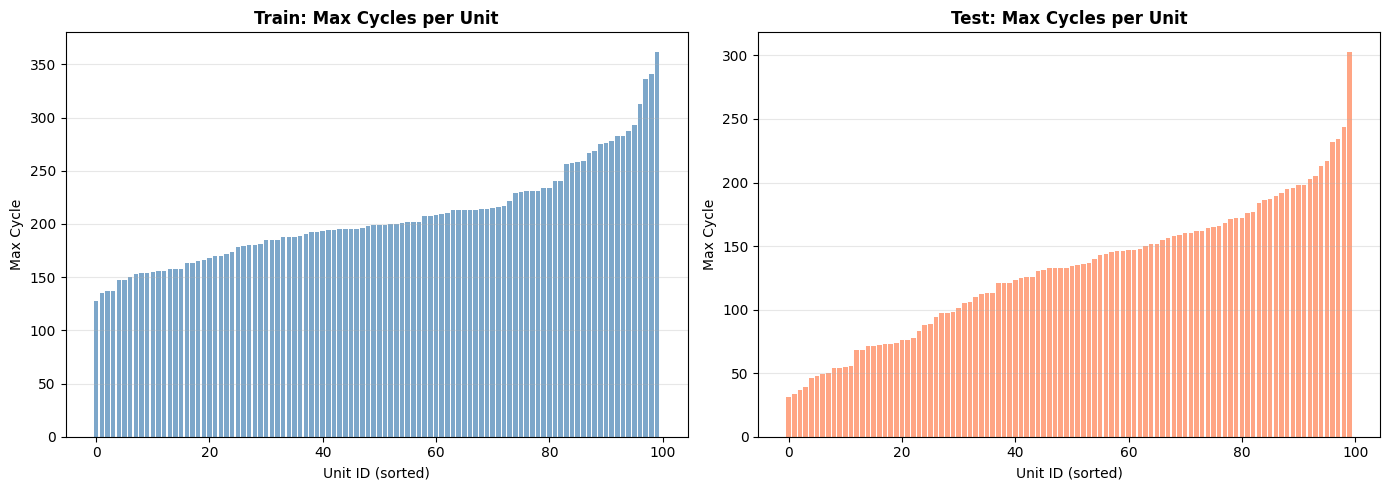

Train | avg cycles per unit : 206.3
Train | min/max cycles      : 128 / 362
Test  | avg cycles per unit : 131.0
Test  | min/max cycles      : 31 / 303


In [64]:
# 8b/ Unit lifecycle visualization
print_header("Unit Lifecycle Distribution")

# Calculate cycle counts per unit
train_cycles = train1.groupby('unit')['cycle'].max().sort_values()
test_cycles = test1.groupby('unit')['cycle'].max().sort_values()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].bar(range(len(train_cycles)), train_cycles.values, color='steelblue', alpha=0.7)
axes[0].set_title('Train: Max Cycles per Unit', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Unit ID (sorted)')
axes[0].set_ylabel('Max Cycle')
axes[0].grid(alpha=0.3, axis='y')

# Test
axes[1].bar(range(len(test_cycles)), test_cycles.values, color='coral', alpha=0.7)
axes[1].set_title('Test: Max Cycles per Unit', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Unit ID (sorted)')
axes[1].set_ylabel('Max Cycle')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary
print_kv([
    ("Train | avg cycles per unit", f"{train_cycles.mean():.1f}"),
    ("Train | min/max cycles", f"{train_cycles.min()} / {train_cycles.max()}"),
    ("Test  | avg cycles per unit", f"{test_cycles.mean():.1f}"),
    ("Test  | min/max cycles", f"{test_cycles.min()} / {test_cycles.max()}"),
])

In [65]:
# 9/ Describe (train/test) — numeric columns
print_header("Describe (numeric) — train")
print(train1.describe().T.round(3))

print_header("Describe (numeric) — test")
print(test1.describe().T.round(3))


Describe (numeric) — train
                           count      mean     std       min       25%       50%       75%       max
unit                     20631.0    51.507  29.228     1.000    26.000    52.000    77.000   100.000
cycle                    20631.0   108.808  68.881     1.000    52.000   104.000   156.000   362.000
opset1                   20631.0    -0.000   0.002    -0.009    -0.002     0.000     0.002     0.009
opset2                   20631.0     0.000   0.000    -0.001    -0.000     0.000     0.000     0.001
opset3                   20631.0   100.000   0.000   100.000   100.000   100.000   100.000   100.000
Fan_Inlet_Temp           20631.0   518.670   0.000   518.670   518.670   518.670   518.670   518.670
LPC_Outlet_Temp          20631.0   642.681   0.500   641.210   642.325   642.640   643.000   644.530
HPC_Outlet_Temp          20631.0  1590.523   6.131  1571.040  1586.260  1590.100  1594.380  1616.910
LPT_Outlet_Temp          20631.0  1408.934   9.001  1382.250  1


Correlation matrix (train)


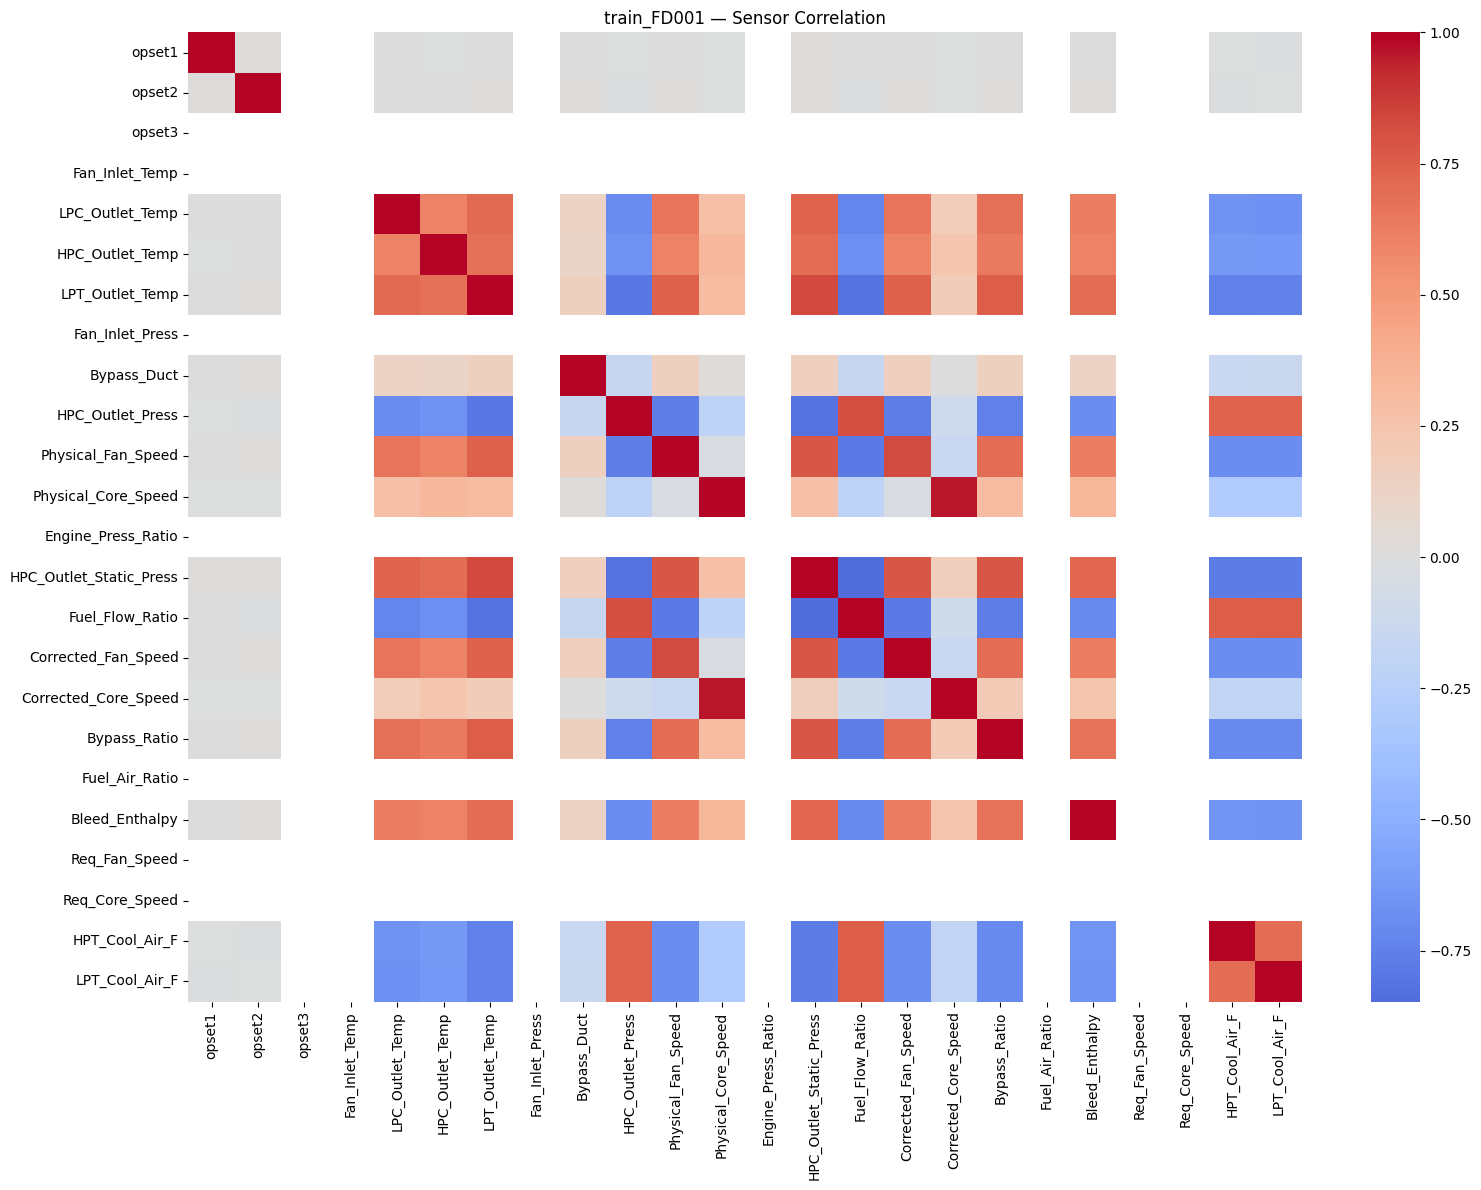

In [66]:
# 10/ Correlation (train) — heatmap
print_header("Correlation matrix (train)")

def plot_corr_heatmap(df, title):
    df_numeric = df.drop(["unit", "cycle"], axis=1, errors='ignore')
    corr = df_numeric.corr()
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_corr_heatmap(train1, "train_FD001 — Sensor Correlation")


RUL Labeling and Distribution


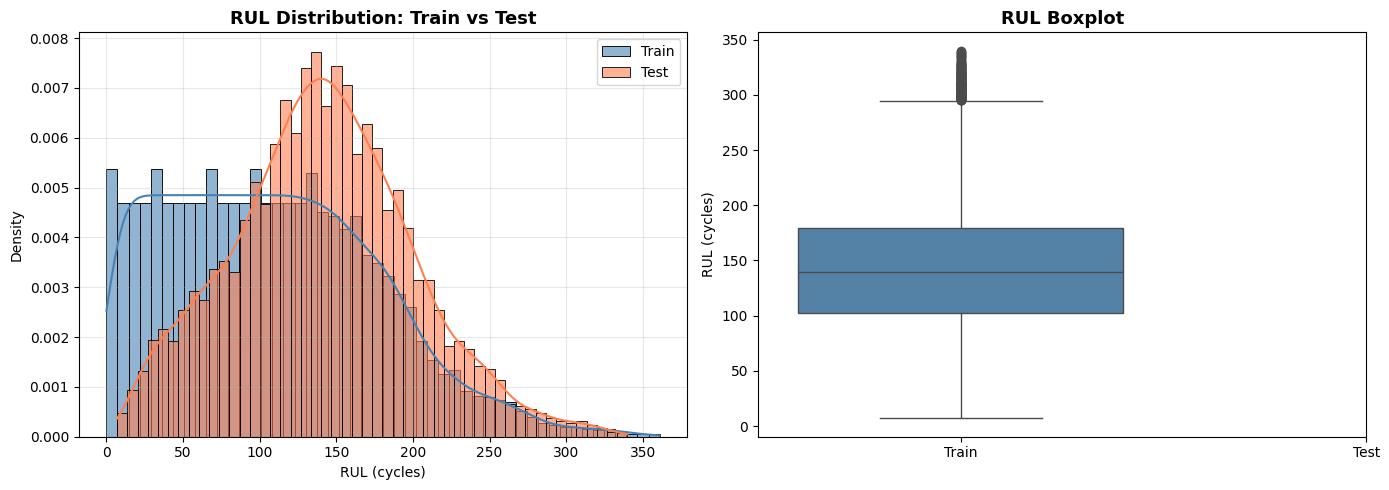


RUL Statistics
Train RUL | mean / std : 107.8 / 68.9
Train RUL | min / max  : 0 / 361
Test RUL  | mean / std : 141.2 / 59.0
Test RUL  | min / max  : 7 / 340
Low RUL (<30) % : Train: 14.5% | Test: 2.3%


In [67]:
# 11/ RUL labeling (Train: unit-based | Test: ground truth from rul.txt)
print_header("RUL Labeling and Distribution")

def add_rul_train(df):
    """Calculate RUL for train: max_cycle - current_cycle per unit"""
    df = df.copy()
    max_cycles = df.groupby('unit')['cycle'].transform('max')
    df['RUL'] = max_cycles - df['cycle']
    return df

def add_rul_test(df, rul_df):
    """Calculate RUL for test: use ground truth RUL file"""
    df = df.copy()
    # Get last cycle per unit
    last_cycles = df.groupby('unit')['cycle'].max().reset_index()
    last_cycles.columns = ['unit', 'last_cycle']
    
    # Merge ground truth RUL (rul_df is 1 value per unit, same order as unique units)
    last_cycles['RUL_at_last'] = rul_df['RUL'].values
    
    # Merge back and calculate RUL for each row
    df = df.merge(last_cycles[['unit', 'last_cycle', 'RUL_at_last']], on='unit', how='left')
    df['RUL'] = df['RUL_at_last'] + (df['last_cycle'] - df['cycle'])
    df = df.drop(['last_cycle', 'RUL_at_last'], axis=1)
    return df

# Apply RUL calculation
train_rul = add_rul_train(train1)
test_rul = add_rul_test(test1, rul1)

# Validation
assert 'RUL' in train_rul.columns and 'RUL' in test_rul.columns, "RUL column missing"
assert (train_rul['RUL'] >= 0).all(), "Train RUL contains negative values"
assert (test_rul['RUL'] >= 0).all(), "Test RUL contains negative values"

# Distribution comparison
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_rul['RUL'], kde=True, color='steelblue', label='Train', alpha=0.6, bins=50, stat='density')
sns.histplot(test_rul['RUL'], kde=True, color='coral', label='Test', alpha=0.6, bins=50, stat='density')
plt.title('RUL Distribution: Train vs Test', fontsize=13, fontweight='bold')
plt.xlabel('RUL (cycles)')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(data=[train_rul['RUL'], test_rul['RUL']], palette=['steelblue', 'coral'])
plt.xticks([0, 1], ['Train', 'Test'])
plt.title('RUL Boxplot', fontsize=13, fontweight='bold')
plt.ylabel('RUL (cycles)')
plt.tight_layout()
plt.show()

# Statistics
print_header("RUL Statistics")
print_kv([
    ("Train RUL | mean / std", f"{train_rul['RUL'].mean():.1f} / {train_rul['RUL'].std():.1f}"),
    ("Train RUL | min / max", f"{train_rul['RUL'].min()} / {train_rul['RUL'].max()}"),
    ("Test RUL  | mean / std", f"{test_rul['RUL'].mean():.1f} / {test_rul['RUL'].std():.1f}"),
    ("Test RUL  | min / max", f"{test_rul['RUL'].min()} / {test_rul['RUL'].max()}"),
])

low_train = (train_rul['RUL'] < 30).mean() * 100
low_test = (test_rul['RUL'] < 30).mean() * 100
print_kv([
    ("Low RUL (<30) %", f"Train: {low_train:.1f}% | Test: {low_test:.1f}%"),
])


Outlier Analysis (Train)
Total outliers (z>3) : 2062
Outlier ratio (%)    : 0.42

Top 5 sensors with most outliers:
  Physical_Core_Speed       : 521 (2.5%)
  Corrected_Core_Speed      : 496 (2.4%)
  Bypass_Duct               : 406 (2.0%)
  Physical_Fan_Speed        : 107 (0.5%)
  Corrected_Fan_Speed       : 83 (0.4%)


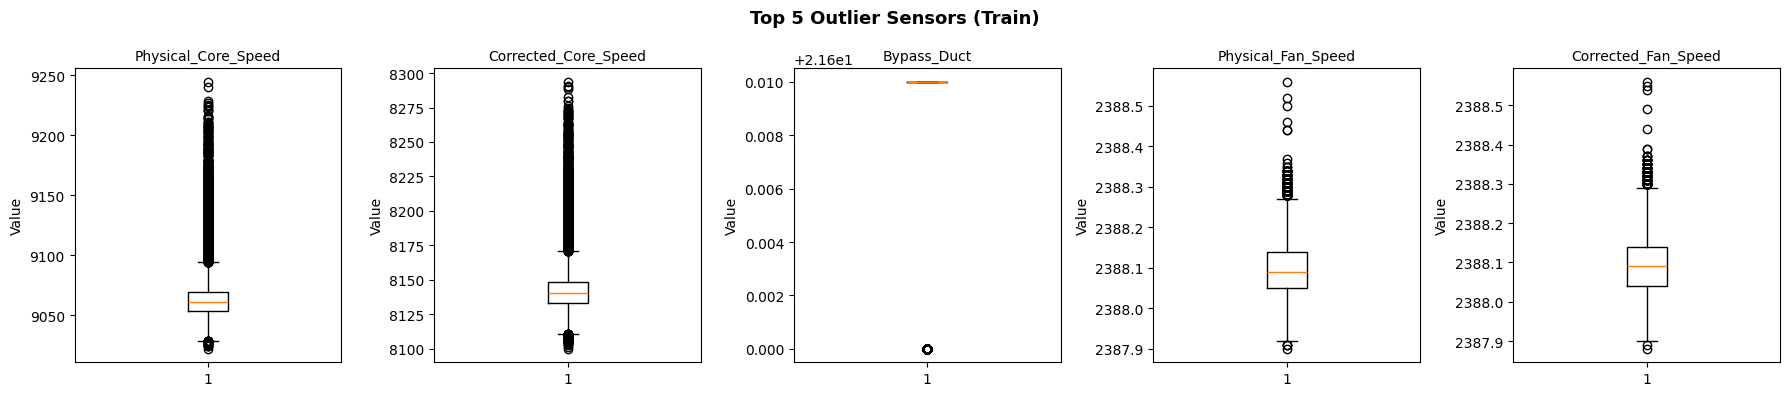

In [68]:
# 12/ Outlier detection (z-score based, Train only)
print_header("Outlier Analysis (Train)")

df_numeric = train1.drop(['unit', 'cycle'], axis=1)
z_scores = np.abs(zscore(df_numeric, nan_policy='omit'))
outlier_mask = z_scores > 3
outlier_counts = outlier_mask.sum(axis=0)

# Summary
outlier_counts = pd.Series(outlier_mask.sum(axis=0), index=df_numeric.columns)
top_5 = outlier_counts.nlargest(5)

print_kv([
    ("Total outliers (z>3)", int(outlier_counts.sum())),
    ("Outlier ratio (%)", f"{(outlier_counts.sum() / df_numeric.size * 100):.2f}"),
])

print("\nTop 5 sensors with most outliers:")
for sensor, count in top_5.items():
    print(f"  {sensor:<25} : {int(count)} ({count/len(df_numeric)*100:.1f}%)")

# Boxplot for top 5 outlier sensors
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
for ax, sensor in zip(axes, top_5.index):
    ax.boxplot(df_numeric[sensor].dropna())
    ax.set_title(sensor, fontsize=10)
    ax.set_ylabel('Value')
plt.suptitle('Top 5 Outlier Sensors (Train)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


Sensor Distribution Comparison (Train vs Test)
Total sensors             : 24
Active sensors (var>0.01) : 11


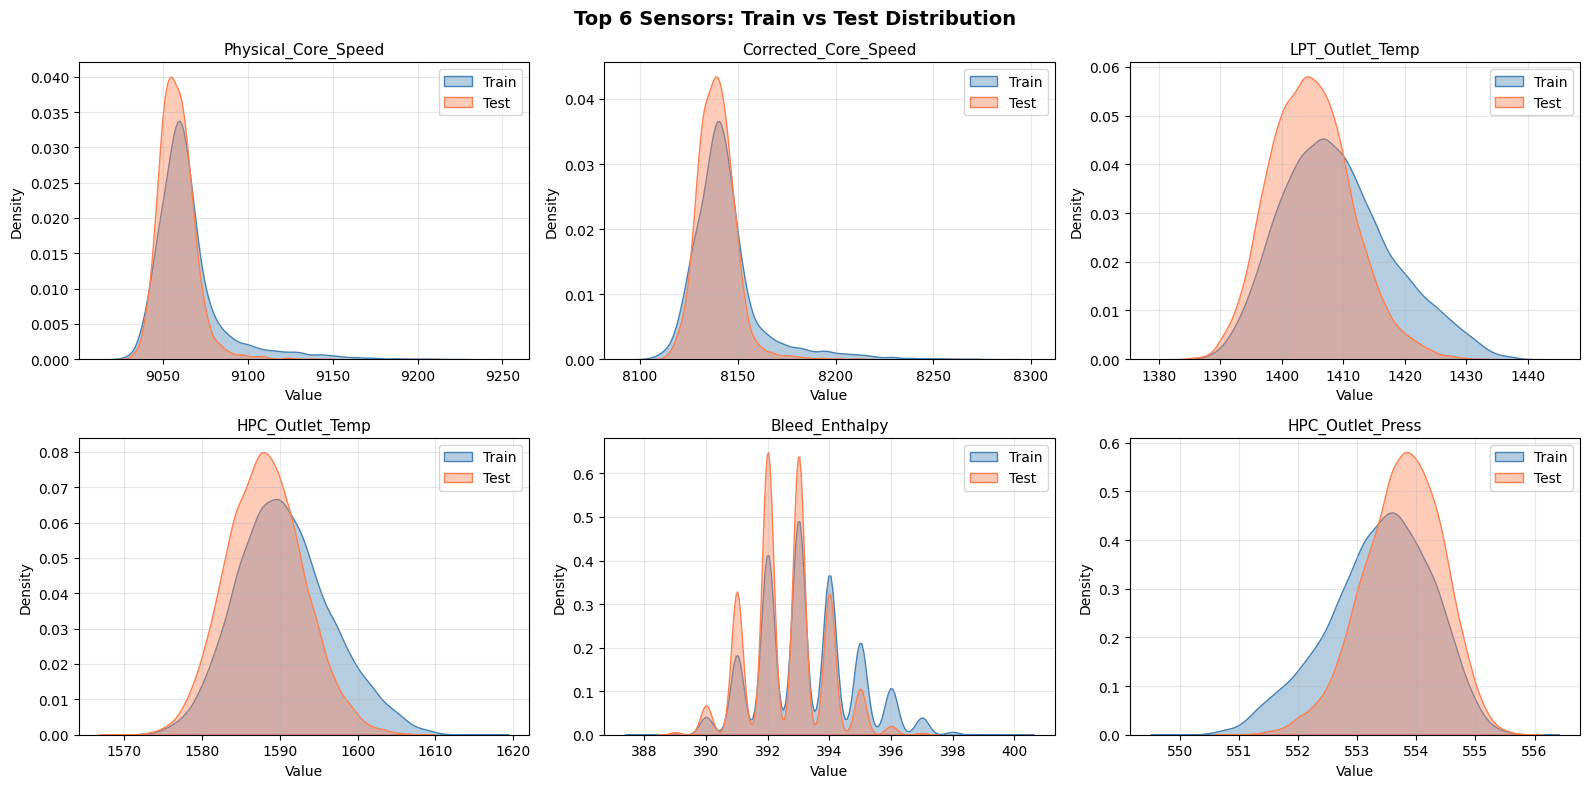


Summary statistics (top 5 active sensors):
  LPC_Outlet_Temp           | Train: mean= 642.68 std=  0.50  | Test: mean= 642.48 std=  0.40
  HPC_Outlet_Temp           | Train: mean=1590.52 std=  6.13  | Test: mean=1588.10 std=  5.00
  LPT_Outlet_Temp           | Train: mean=1408.93 std=  9.00  | Test: mean=1404.74 std=  6.69
  HPC_Outlet_Press          | Train: mean= 553.37 std=  0.89  | Test: mean= 553.76 std=  0.68
  Physical_Core_Speed       | Train: mean=9065.24 std= 22.08  | Test: mean=9058.41 std= 11.44


In [69]:
# 13/ Sensor distribution comparison (Train vs Test — top sensors only)
print_header("Sensor Distribution Comparison (Train vs Test)")

df_numeric_train = train1.drop(['unit', 'cycle'], axis=1)
df_numeric_test = test1.drop(['unit', 'cycle'], axis=1)

# Identify sensors with meaningful variance (exclude near-constant)
variances = df_numeric_train.var()
active_sensors = variances[variances > 0.01].index.tolist()
print_kv([
    ("Total sensors", len(df_numeric_train.columns)),
    ("Active sensors (var>0.01)", len(active_sensors)),
])

# Plot KDE for top 6 active sensors (by variance)
top_sensors = variances.nlargest(6).index
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, sensor in enumerate(top_sensors):
    ax = axes[i]
    sns.kdeplot(df_numeric_train[sensor], ax=ax, label='Train', color='steelblue', fill=True, alpha=0.4)
    sns.kdeplot(df_numeric_test[sensor], ax=ax, label='Test', color='coral', fill=True, alpha=0.4)
    ax.set_title(sensor, fontsize=11)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Top 6 Sensors: Train vs Test Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary stats for top active sensors (abbreviated)
print_header("Summary statistics (top 5 active sensors):")
for sensor in active_sensors[:5]:
    train_mean = df_numeric_train[sensor].mean()
    test_mean = df_numeric_test[sensor].mean()
    train_std = df_numeric_train[sensor].std()
    test_std = df_numeric_test[sensor].std()
    print(f"  {sensor:<25} | Train: mean={train_mean:>7.2f} std={train_std:>6.2f}  | Test: mean={test_mean:>7.2f} std={test_std:>6.2f}")

## 3) Feature Engineering & Preprocessing

In [70]:
# 14/ Constant & Low Variance Feature Removal
print_header("Constant & Low Variance Feature Removal")

# Identify features to drop (exclude unit, cycle, RUL)
features_to_check = train_rul.drop(['unit', 'cycle', 'RUL'], axis=1).columns

# Calculate variance for each feature
variance_threshold = 0.01
low_variance_features = []

for col in features_to_check:
    var = train_rul[col].var()
    if var < variance_threshold:
        low_variance_features.append(col)

# Show features to remove
print(f"Features with variance < {variance_threshold}:")
if len(low_variance_features) > 0:
    for feature in low_variance_features:
        var_value = train_rul[feature].var()
        print(f"  {feature:<25} : variance = {var_value:.6f}")
else:
    print("  None found")

# Remove low variance features from train and test
train_clean = train_rul.drop(low_variance_features, axis=1)
test_clean = test_rul.drop(low_variance_features, axis=1)

# Validation
assert train_clean.shape[0] == train_rul.shape[0], "Row count changed in train"
assert test_clean.shape[0] == test_rul.shape[0], "Row count changed in test"
assert 'RUL' in train_clean.columns and 'RUL' in test_clean.columns, "RUL column missing"

# Summary
remaining_features = train_clean.shape[1] - 3  # exclude unit, cycle, RUL
print_kv([
    ("Original features", len(features_to_check)),
    ("Removed features", len(low_variance_features)),
    ("Remaining features", remaining_features),
    ("Train shape after", train_clean.shape),
    ("Test shape after", test_clean.shape),
])

print("Feature removal complete")


Constant & Low Variance Feature Removal
Features with variance < 0.01:
  opset1                    : variance = 0.000005
  opset2                    : variance = 0.000000
  opset3                    : variance = 0.000000
  Fan_Inlet_Temp            : variance = 0.000000
  Fan_Inlet_Press           : variance = 0.000000
  Bypass_Duct               : variance = 0.000002
  Physical_Fan_Speed        : variance = 0.005039
  Engine_Press_Ratio        : variance = 0.000000
  Corrected_Fan_Speed       : variance = 0.005172
  Bypass_Ratio              : variance = 0.001407
  Fuel_Air_Ratio            : variance = 0.000000
  Req_Fan_Speed             : variance = 0.000000
  Req_Core_Speed            : variance = 0.000000
Original features  : 24
Removed features   : 13
Remaining features : 11
Train shape after  : (20631, 14)
Test shape after   : (13096, 14)
Feature removal complete



Variance Comparison (Before/After Removal)


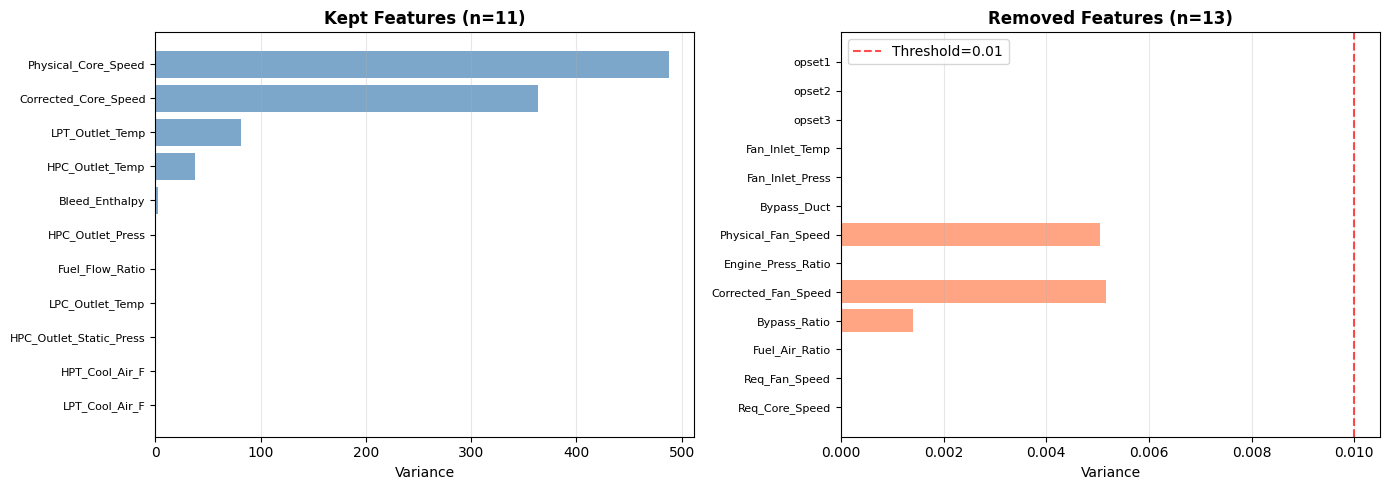

In [71]:
# 14b/ Variance comparison visualization
print_header("Variance Comparison (Before/After Removal)")

# Get variance for all features before removal
all_variances = train_rul.drop(['unit', 'cycle', 'RUL'], axis=1).var().sort_values(ascending=False)

# Separate kept vs removed
kept_features = [f for f in all_variances.index if f not in low_variance_features]
removed_features = low_variance_features

kept_variances = all_variances[kept_features]
removed_variances = all_variances[removed_features] if len(removed_features) > 0 else pd.Series()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Kept features
axes[0].barh(range(len(kept_variances)), kept_variances.values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(kept_variances)))
axes[0].set_yticklabels(kept_variances.index, fontsize=8)
axes[0].set_xlabel('Variance')
axes[0].set_title(f'Kept Features (n={len(kept_variances)})', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Removed features
if len(removed_variances) > 0:
    axes[1].barh(range(len(removed_variances)), removed_variances.values, color='coral', alpha=0.7)
    axes[1].set_yticks(range(len(removed_variances)))
    axes[1].set_yticklabels(removed_variances.index, fontsize=8)
    axes[1].set_xlabel('Variance')
    axes[1].set_title(f'Removed Features (n={len(removed_variances)})', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].axvline(x=0.01, color='red', linestyle='--', alpha=0.7, label='Threshold=0.01')
    axes[1].legend()
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'No features removed', ha='center', va='center', fontsize=14)
    axes[1].set_title('Removed Features (n=0)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [72]:
# 15/ Train/Val Split (unit-based, 80/20)
print_header("Train/Val Split (unit-based)")

from sklearn.model_selection import train_test_split

# Get unique units from train set
all_units = train_clean['unit'].unique()
total_units = len(all_units)

# Split units into train and validation (80/20)
train_units, val_units = train_test_split(
    all_units, 
    test_size=0.2, 
    random_state=42
)

# Create train and validation sets based on unit split
train_set = train_clean[train_clean['unit'].isin(train_units)].copy()
val_set = train_clean[train_clean['unit'].isin(val_units)].copy()

# Validation
assert len(train_set) + len(val_set) == len(train_clean), "Row count mismatch after split"
assert train_set['unit'].nunique() == len(train_units), "Train unit count mismatch"
assert val_set['unit'].nunique() == len(val_units), "Val unit count mismatch"

# Check no unit overlap
train_unit_set = set(train_set['unit'].unique())
val_unit_set = set(val_set['unit'].unique())
overlap = train_unit_set.intersection(val_unit_set)
assert len(overlap) == 0, f"Unit overlap detected: {overlap}"

# Summary
print_kv([
    ("Total units", total_units),
    ("Train units", len(train_units)),
    ("Val units", len(val_units)),
    ("Train rows", len(train_set)),
    ("Val rows", len(val_set)),
    ("Split ratio", f"{len(train_set)/len(train_clean)*100:.1f}% / {len(val_set)/len(train_clean)*100:.1f}%"),
])

# RUL distribution check
train_rul_mean = train_set['RUL'].mean()
val_rul_mean = val_set['RUL'].mean()
print_kv([
    ("Train RUL mean", f"{train_rul_mean:.1f}"),
    ("Val RUL mean", f"{val_rul_mean:.1f}"),
])

print_header("Train/Val split complete")


Train/Val Split (unit-based)
Total units : 100
Train units : 80
Val units   : 20
Train rows  : 16561
Val rows    : 4070
Split ratio : 80.3% / 19.7%
Train RUL mean : 108.4
Val RUL mean   : 105.5

Train/Val split complete



Scaling Effect Comparison


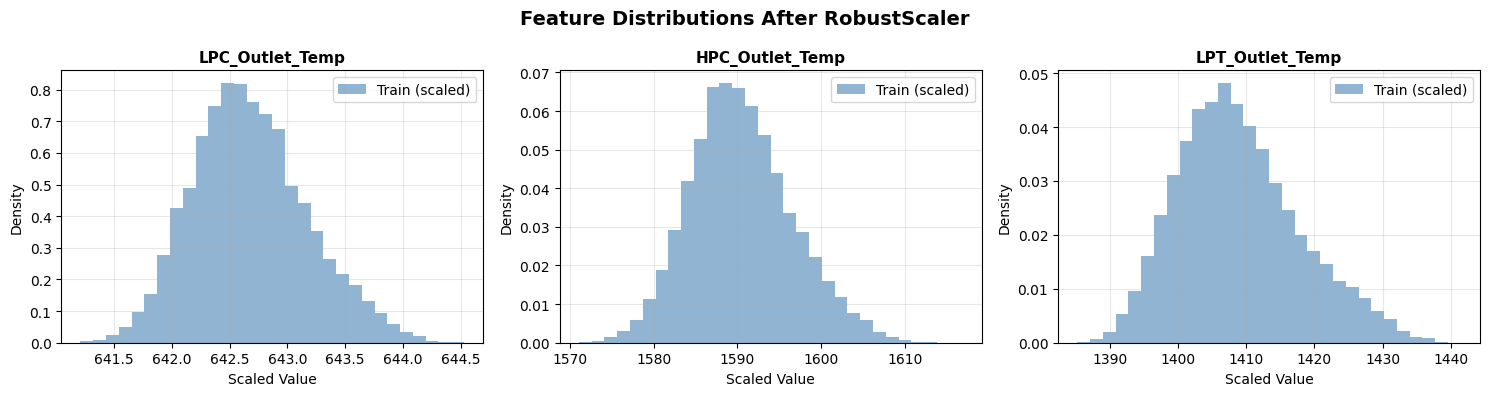

RobustScaler centers data around median=0 and scales by IQR.


In [73]:
# 16b/ Scaling effect visualization
print_header("Scaling Effect Comparison")


# Select top 3 features (by variance before scaling)
cols_to_scale = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]
top_features = cols_to_scale[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Plot train distribution
    ax.hist(train_set[feature], bins=30, color='steelblue', alpha=0.6, label='Train (scaled)', density=True)
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Distributions After RobustScaler', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("RobustScaler centers data around median=0 and scales by IQR.")

In [74]:
# 16/ Scaling (RobustScaler - fit on train only)
print_header("Feature Scaling")

# Identify columns to scale (exclude unit, cycle, RUL)
cols_to_scale = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]

# Initialize scaler
scaler = RobustScaler()

# Fit scaler on train set only
scaler.fit(train_set[cols_to_scale])

# Transform train, val, and test sets
train_set[cols_to_scale] = scaler.transform(train_set[cols_to_scale])
val_set[cols_to_scale] = scaler.transform(val_set[cols_to_scale])
test_clean[cols_to_scale] = scaler.transform(test_clean[cols_to_scale])

# Validation
assert train_set[cols_to_scale].isnull().sum().sum() == 0, "Train contains nulls after scaling"
assert val_set[cols_to_scale].isnull().sum().sum() == 0, "Val contains nulls after scaling"
assert test_clean[cols_to_scale].isnull().sum().sum() == 0, "Test contains nulls after scaling"

# Check scaling effect
train_scaled_mean = train_set[cols_to_scale].mean().mean()
train_scaled_std = train_set[cols_to_scale].std().mean()

print_kv([
            ("Scaler type", "RobustScaler"),
            ("Columns scaled", len(cols_to_scale)),
            ("Train scaled mean (avg)", f"{train_scaled_mean:.4f}"),
            ("Train scaled std (avg)", f"{train_scaled_std:.4f}"),
        ])

# Show before/after stats for first 3 features
print("\nScaling effect (first 3 features):")
for col in cols_to_scale[:3]:
    train_min = train_set[col].min()
    train_max = train_set[col].max()
    train_median = train_set[col].median()
    print(f"  {col:<25} | min={train_min:>7.2f} | max={train_max:>7.2f} | median={train_median:>7.2f}")

print("Scaling complete")


Feature Scaling
Scaler type             : RobustScaler
Columns scaled          : 11
Train scaled mean (avg) : 0.0563
Train scaled std (avg)  : 0.8605

Scaling effect (first 3 features):
  LPC_Outlet_Temp           | min=  -2.17 | max=   2.86 | median=   0.00
  HPC_Outlet_Temp           | min=  -2.37 | max=   3.35 | median=   0.00
  LPT_Outlet_Temp           | min=  -1.89 | max=   2.79 | median=   0.00
Scaling complete



Scaling Effect Comparison


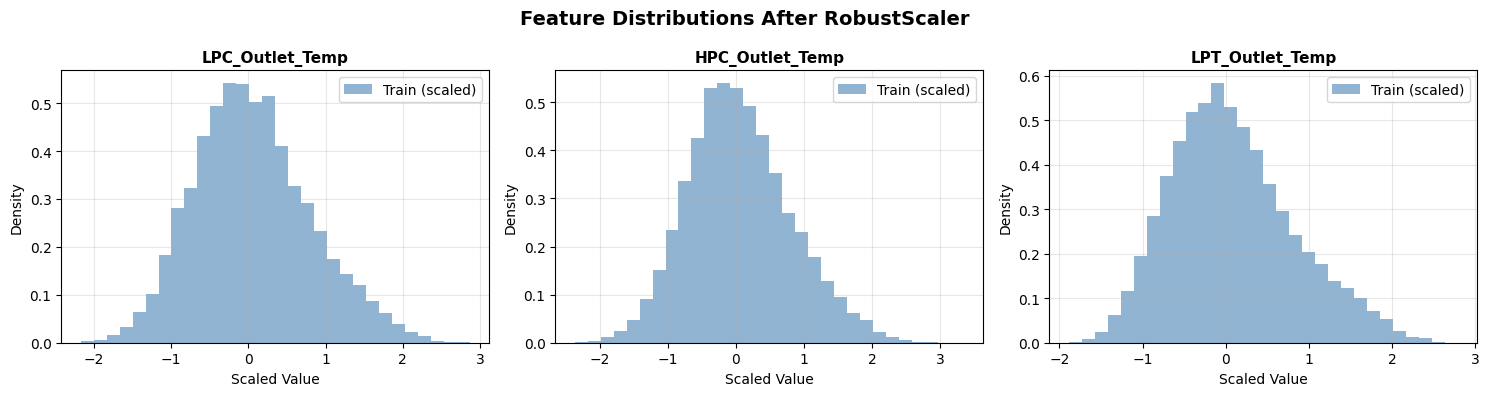

RobustScaler centers data around median=0 and scales by IQR.


In [75]:
# 16b/ Scaling effect visualization
print_header("Scaling Effect Comparison")


# Select top 3 features (by variance before scaling)
top_features = cols_to_scale[:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, feature in enumerate(top_features):
    ax = axes[i]
    
    # Plot train distribution
    ax.hist(train_set[feature], bins=30, color='steelblue', alpha=0.6, label='Train (scaled)', density=True)
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel('Scaled Value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(alpha=0.3)

plt.suptitle('Feature Distributions After RobustScaler', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("RobustScaler centers data around median=0 and scales by IQR.")

In [76]:
# 17/ Rolling Window Features (window=30 cycles)
print_header("Rolling Window Feature Engineering")

def add_rolling_features(df, window_size=30):
    """
    Add rolling window statistics for each sensor per unit.
    Features: mean, std, min, max, slope (linear trend)
    """
    df = df.copy()
    
    # Get sensor columns (exclude unit, cycle, RUL)
    sensor_cols = [col for col in df.columns if col not in ['unit', 'cycle', 'RUL']]
    
    # Initialize empty lists to store new feature columns
    new_features = []
    
    # Process each unit separately
    units = df['unit'].unique()
    
    for unit_id in units:
        # Get data for current unit
        unit_mask = df['unit'] == unit_id
        unit_data = df[unit_mask].copy()
        
        # Sort by cycle to ensure correct order
        unit_data = unit_data.sort_values('cycle')
        
        # Calculate rolling features for each sensor
        for sensor in sensor_cols:
            # Rolling mean
            unit_data[f'{sensor}_roll_mean'] = unit_data[sensor].rolling(window=window_size, min_periods=1).mean()
            
            # Rolling standard deviation
            unit_data[f'{sensor}_roll_std'] = unit_data[sensor].rolling(window=window_size, min_periods=1).std()
            
            # Rolling min
            unit_data[f'{sensor}_roll_min'] = unit_data[sensor].rolling(window=window_size, min_periods=1).min()
            
            # Rolling max
            unit_data[f'{sensor}_roll_max'] = unit_data[sensor].rolling(window=window_size, min_periods=1).max()
            
            # Rolling slope (linear trend)
            def calculate_slope(values):
                if len(values) < 2:
                    return 0
                x = np.arange(len(values))
                y = values.values
                # Simple linear regression: slope = covariance(x,y) / variance(x)
                slope = np.cov(x, y)[0, 1] / np.var(x) if np.var(x) > 0 else 0
                return slope
            
            unit_data[f'{sensor}_roll_slope'] = unit_data[sensor].rolling(window=window_size, min_periods=2).apply(calculate_slope, raw=False)
        
        # Store processed unit data
        new_features.append(unit_data)
    
    # Combine all units
    result = pd.concat(new_features, ignore_index=True)
    
    # Fill any remaining NaN values with 0 (for initial cycles with insufficient history)
    result = result.fillna(0)
    
    return result

# Apply rolling features to train, val, and test
print("Applying rolling window features (window=30)...")
train_set = add_rolling_features(train_set, window_size=30)
val_set = add_rolling_features(val_set, window_size=30)
test_clean = add_rolling_features(test_clean, window_size=30)

# Validation
assert train_set.isnull().sum().sum() == 0, "Train contains nulls after rolling features"
assert val_set.isnull().sum().sum() == 0, "Val contains nulls after rolling features"
assert test_clean.isnull().sum().sum() == 0, "Test contains nulls after rolling features"

# Get feature counts
original_features = len([col for col in cols_to_scale])
rolling_features = len([col for col in train_set.columns if 'roll_' in col])
total_features = train_set.shape[1] - 3  # exclude unit, cycle, RUL

print_kv([
            ("Window size", 30),
            ("Original sensor features", original_features),
            ("New rolling features", rolling_features),
            ("Total features (excl unit/cycle/RUL)", total_features),
            ("Train shape after", train_set.shape),
            ("Val shape after", val_set.shape),
            ("Test shape after", test_clean.shape),
        ])

# Show example of new features (first sensor)
first_sensor = cols_to_scale[0]
rolling_cols = [col for col in train_set.columns if first_sensor in col and 'roll_' in col]
print(f"\nExample rolling features for '{first_sensor}':")
for col in rolling_cols[:5]:  # show first 5
    print(f"  {col}")

print_header("Rolling window features complete")


Rolling Window Feature Engineering
Applying rolling window features (window=30)...
Window size                          : 30
Original sensor features             : 11
New rolling features                 : 55
Total features (excl unit/cycle/RUL) : 66
Train shape after                    : (16561, 69)
Val shape after                      : (4070, 69)
Test shape after                     : (13096, 69)

Example rolling features for 'LPC_Outlet_Temp':
  LPC_Outlet_Temp_roll_mean
  LPC_Outlet_Temp_roll_std
  LPC_Outlet_Temp_roll_min
  LPC_Outlet_Temp_roll_max
  LPC_Outlet_Temp_roll_slope

Rolling window features complete



Rolling Feature Example (Single Unit)


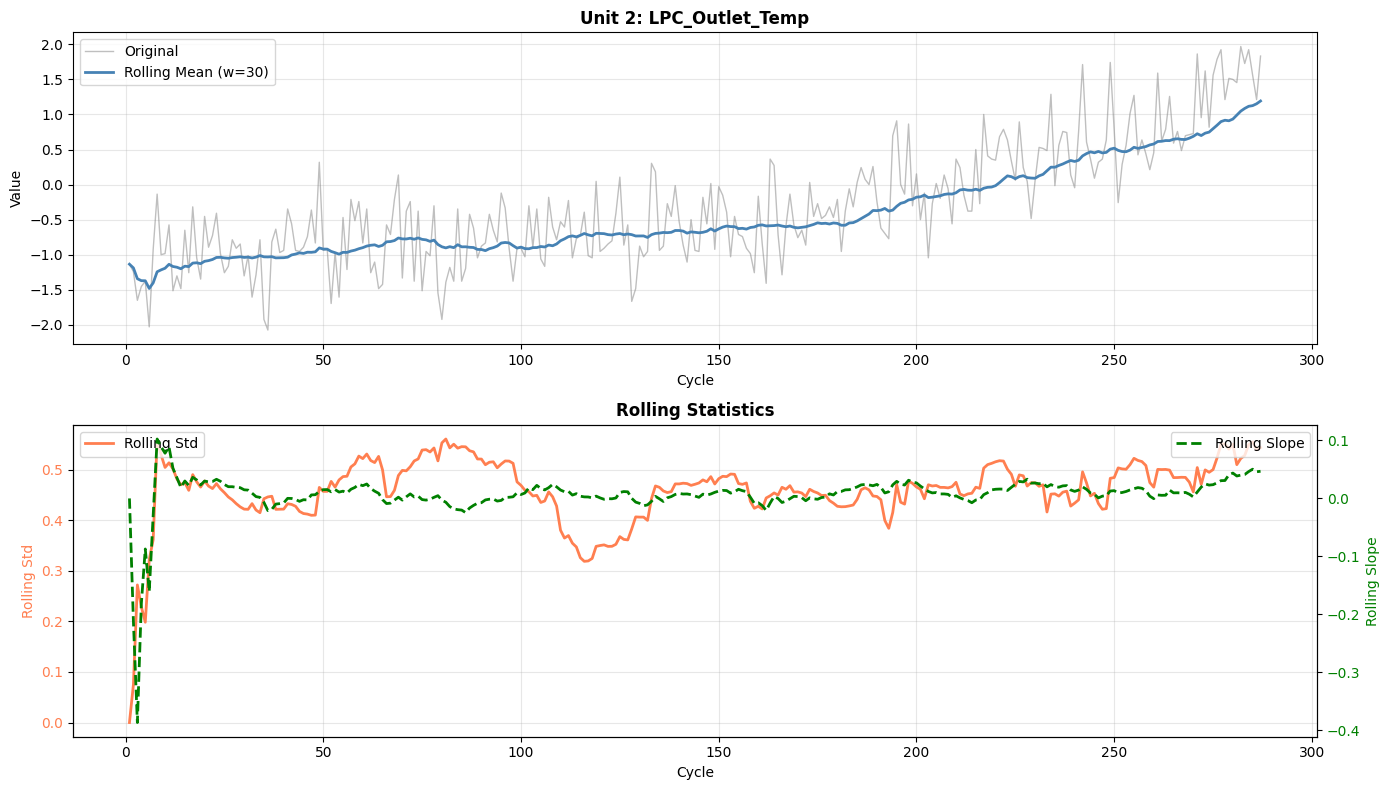

Rolling features capture temporal patterns for unit 2.


In [77]:
# 17b/ Rolling feature visualization (single unit example)
print_header("Rolling Feature Example (Single Unit)")

# Select one unit
example_unit = train_set['unit'].iloc[0]
unit_data = train_set[train_set['unit'] == example_unit].sort_values('cycle')

# Select first sensor
example_sensor = cols_to_scale[0]

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original + rolling mean
axes[0].plot(unit_data['cycle'], unit_data[example_sensor], 
             label='Original', color='gray', alpha=0.5, linewidth=1)
axes[0].plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_mean'], 
             label='Rolling Mean (w=30)', color='steelblue', linewidth=2)
axes[0].set_title(f'Unit {example_unit}: {example_sensor}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Cycle')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Rolling std + slope
ax2 = axes[1]
ax2.plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_std'], 
         label='Rolling Std', color='coral', linewidth=2)
ax2.set_xlabel('Cycle')
ax2.set_ylabel('Rolling Std', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Add slope on secondary axis
ax3 = ax2.twinx()
ax3.plot(unit_data['cycle'], unit_data[f'{example_sensor}_roll_slope'], 
         label='Rolling Slope', color='green', linewidth=2, linestyle='--')
ax3.set_ylabel('Rolling Slope', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.legend(loc='upper right')

axes[1].set_title('Rolling Statistics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Rolling features capture temporal patterns for unit {example_unit}.")

In [78]:
# 18/ Sample Weighting (give more weight to low RUL samples)
print_header("Sample Weighting")

def calculate_sample_weights(df, rul_threshold=30, low_rul_weight=2.0):
    """
    Calculate sample weights based on RUL values.
    Samples with RUL < threshold get higher weight.
    """
    df = df.copy()
    
    # Initialize weights array (default weight = 1.0)
    weights = np.ones(len(df))
    
    # Find samples with low RUL
    low_rul_mask = df['RUL'] < rul_threshold
    
    # Assign higher weight to low RUL samples
    weights[low_rul_mask] = low_rul_weight
    
    return weights

# Calculate weights for train and val sets
train_weights = calculate_sample_weights(train_set, rul_threshold=30, low_rul_weight=2.0)
val_weights = calculate_sample_weights(val_set, rul_threshold=30, low_rul_weight=2.0)

# Validation
assert len(train_weights) == len(train_set), "Train weights length mismatch"
assert len(val_weights) == len(val_set), "Val weights length mismatch"
assert (train_weights >= 1.0).all(), "Train weights contain values less than 1.0"
assert (val_weights >= 1.0).all(), "Val weights contain values less than 1.0"

# Count weighted samples
train_low_rul_count = (train_set['RUL'] < 30).sum()
train_high_weight_count = (train_weights > 1.0).sum()
val_low_rul_count = (val_set['RUL'] < 30).sum()
val_high_weight_count = (val_weights > 1.0).sum()

# Summary
print_kv([
            ("RUL threshold", 30),
            ("Low RUL weight", 2.0),
            ("High RUL weight", 1.0),
        ])

print("\nTrain set:")
print_kv([
            ("Total samples", len(train_set)),
            ("Low RUL samples (RUL<30)", train_low_rul_count),
            ("High weight samples", train_high_weight_count),
            ("Low RUL ratio (%)", f"{train_low_rul_count/len(train_set)*100:.1f}"),
        ])

print("\nVal set:")
print_kv([
            ("Total samples", len(val_set)),
            ("Low RUL samples (RUL<30)", val_low_rul_count),
            ("High weight samples", val_high_weight_count),
            ("Low RUL ratio (%)", f"{val_low_rul_count/len(val_set)*100:.1f}"),
        ])

# Weight distribution
print("\nWeight distribution (train):")
unique_weights = np.unique(train_weights)
for weight in unique_weights:
    count = (train_weights == weight).sum()
    percentage = count / len(train_weights) * 100
    print(f"  weight={weight:.1f} : {count:>6} samples ({percentage:>5.1f}%)")

print_header("Sample weighting complete")


Sample Weighting
RUL threshold   : 30
Low RUL weight  : 2.0
High RUL weight : 1.0

Train set:
Total samples            : 16561
Low RUL samples (RUL<30) : 2400
High weight samples      : 2400
Low RUL ratio (%)        : 14.5

Val set:
Total samples            : 4070
Low RUL samples (RUL<30) : 600
High weight samples      : 600
Low RUL ratio (%)        : 14.7

Weight distribution (train):
  weight=1.0 :  14161 samples ( 85.5%)
  weight=2.0 :   2400 samples ( 14.5%)

Sample weighting complete


## 4) Preprocessing


Feature Correlation Analysis

Top 10 highly correlated feature pairs (|corr| > 0.95):
   1. Physical_Core_Speed_roll_mean  <-> Corrected_Core_Speed_roll_mean | corr = 0.9882
   2. HPC_Outlet_Static_Press_roll_mean <-> Fuel_Flow_Ratio_roll_mean      | corr = 0.9867
   3. Physical_Core_Speed_roll_mean  <-> Physical_Core_Speed_roll_max   | corr = 0.9866
   4. Corrected_Core_Speed_roll_mean <-> Corrected_Core_Speed_roll_max  | corr = 0.9858
   5. LPT_Outlet_Temp_roll_mean      <-> HPC_Outlet_Static_Press_roll_mean | corr = 0.9857
   6. Physical_Core_Speed_roll_mean  <-> Corrected_Core_Speed_roll_max  | corr = 0.9841
   7. HPC_Outlet_Press_roll_mean     <-> Fuel_Flow_Ratio_roll_mean      | corr = 0.9836
   8. Physical_Core_Speed_roll_max   <-> Corrected_Core_Speed_roll_max  | corr = 0.9834
   9. HPC_Outlet_Press_roll_mean     <-> HPC_Outlet_Static_Press_roll_mean | corr = 0.9832
  10. Corrected_Core_Speed           <-> Corrected_Core_Speed_roll_max  | corr = 0.9810

  ... and 55 more pairs

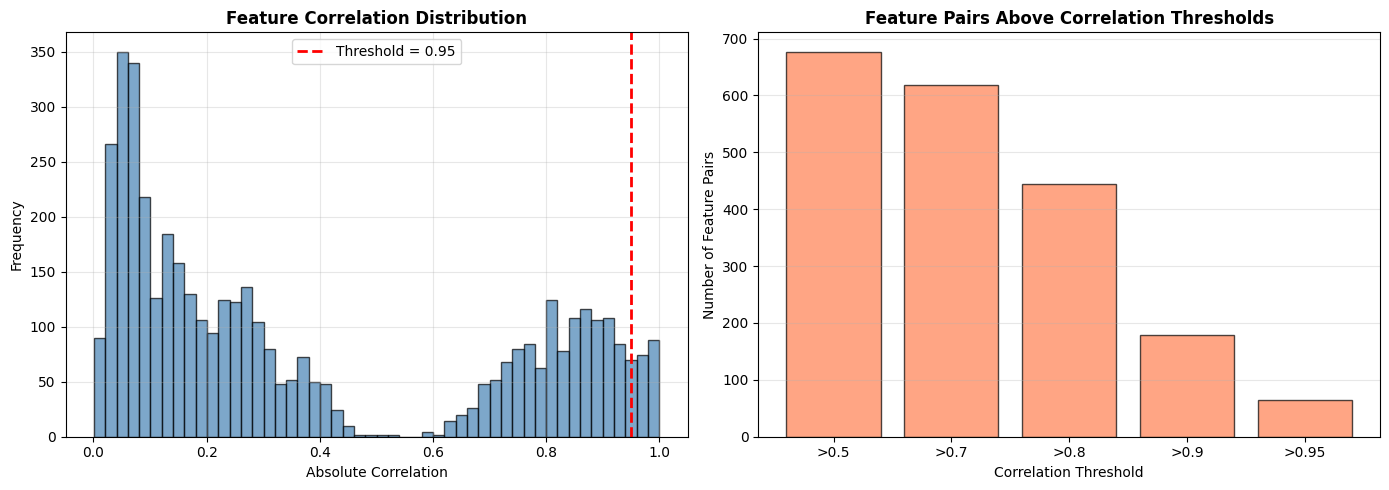


Correlation statistics:
Total feature pairs                  : 2145
High correlation pairs (>0.95)       : 65
High Correlation Pairs               : 65
Percentage of high correlation pairs : 98.5%


In [79]:
# 19a/ Feature correlation heatmap (before removal)
print_header("Feature Correlation Analysis")

# Get feature columns before removal
feature_cols = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]

# Calculate correlation matrix
corr_matrix = train_set[feature_cols].corr().abs()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if corr_value > 0.95:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            high_corr_pairs.append((feature_i, feature_j, corr_value))

# Sort by correlation value
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

# Show top 10 highly correlated pairs
print(f"\nTop 10 highly correlated feature pairs (|corr| > 0.95):")
if len(high_corr_pairs) > 0:
    for i, (feat1, feat2, corr_val) in enumerate(high_corr_pairs[:10], 1):
        print(f"  {i:>2}. {feat1:<30} <-> {feat2:<30} | corr = {corr_val:.4f}")
    if len(high_corr_pairs) > 10:
        print(f"\n  ... and {len(high_corr_pairs) - 10} more pairs")
else:
    print("None found")

# Plot correlation distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation distribution histogram
axes[0].hist(corr_matrix.values.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.95, color='red', linestyle='--', linewidth=2, label='Threshold = 0.95')
axes[0].set_title('Feature Correlation Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Absolute Correlation')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Count features by correlation threshold
thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
counts = []
for threshold in thresholds:
    count = 0
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                count += 1
    counts.append(count)

axes[1].bar(range(len(thresholds)), counts, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(thresholds)))
axes[1].set_xticklabels([f'>{t}' for t in thresholds])
axes[1].set_title('Feature Pairs Above Correlation Thresholds', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Correlation Threshold')
axes[1].set_ylabel('Number of Feature Pairs')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nCorrelation statistics:")
print_kv([
    ("Total feature pairs", int(len(corr_matrix.columns) * (len(corr_matrix.columns) - 1) / 2)),
    ("High correlation pairs (>0.95)", len(high_corr_pairs)),
    ("High Correlation Pairs", len(high_corr_pairs)),
    ("Percentage of high correlation pairs", f"{len(high_corr_pairs) / len(feature_cols) * 100:.1f}%"),
])

In [80]:
# 19/ Feature Selection (correlation-based removal)
print_header("Feature Selection")

def remove_highly_correlated_features(df, threshold=0.95):
    """
    Remove features that are highly correlated with each other.
    Keep the first feature in each correlated pair.
    """
    df = df.copy()
    
    # Get feature columns (exclude unit, cycle, RUL)
    feature_cols = [col for col in df.columns if col not in ['unit', 'cycle', 'RUL']]
    
    # Calculate correlation matrix
    corr_matrix = df[feature_cols].corr().abs()
    
    # Find features to remove
    features_to_remove = []
    
    # Loop through correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            # Get correlation value
            corr_value = corr_matrix.iloc[i, j]
            
            # If correlation is above threshold
            if corr_value > threshold:
                feature_i = corr_matrix.columns[i]
                feature_j = corr_matrix.columns[j]
                
                # Keep feature_i, remove feature_j
                if feature_j not in features_to_remove:
                    features_to_remove.append(feature_j)
    
    return features_to_remove

# Find highly correlated features
print("Finding highly correlated features (threshold=0.95)...")
features_to_remove = remove_highly_correlated_features(train_set, threshold=0.95)

# Show features to remove
print(f"\nFeatures to remove (n={len(features_to_remove)}):")
if len(features_to_remove) > 0:
    for i, feature in enumerate(features_to_remove[:10], 1):  # show first 10
        print(f"  {i:>2}. {feature}")
    if len(features_to_remove) > 10:
        print(f"  ... and {len(features_to_remove) - 10} more")
else:
    print("  None found")

# Remove correlated features from train, val, and test
train_set = train_set.drop(features_to_remove, axis=1)
val_set = val_set.drop(features_to_remove, axis=1)
test_clean = test_clean.drop(features_to_remove, axis=1)

# Validation
assert train_set.shape[0] == len(train_weights), "Row count changed in train"
assert val_set.shape[0] == len(val_weights), "Row count changed in val"
assert 'RUL' in train_set.columns, "RUL column missing in train"
assert 'RUL' in val_set.columns, "RUL column missing in val"
assert 'RUL' in test_clean.columns, "RUL column missing in test"

# Count remaining features
remaining_features = train_set.shape[1] - 3  # exclude unit, cycle, RUL

print_kv([
    ("Correlation threshold", 0.95),
    ("Features removed", len(features_to_remove)),
    ("Remaining features", remaining_features),
    ("Train shape after", train_set.shape),
    ("Val shape after", val_set.shape),
    ("Test shape after", test_clean.shape),
])

print_header("Feature selection complete")


Feature Selection
Finding highly correlated features (threshold=0.95)...

Features to remove (n=21):
   1. Corrected_Core_Speed
   2. Physical_Core_Speed_roll_mean
   3. Physical_Core_Speed_roll_max
   4. Corrected_Core_Speed_roll_mean
   5. Corrected_Core_Speed_roll_max
   6. HPC_Outlet_Temp_roll_mean
   7. LPT_Outlet_Temp_roll_mean
   8. HPC_Outlet_Press_roll_mean
   9. HPC_Outlet_Static_Press_roll_mean
  10. Fuel_Flow_Ratio_roll_mean
  ... and 11 more
Correlation threshold : 0.95
Features removed      : 21
Remaining features    : 45
Train shape after     : (16561, 48)
Val shape after       : (4070, 48)
Test shape after      : (13096, 48)

Feature selection complete



Feature Correlation Analysis

Top 10 highly correlated feature pairs (|corr| > 0.95):
None found


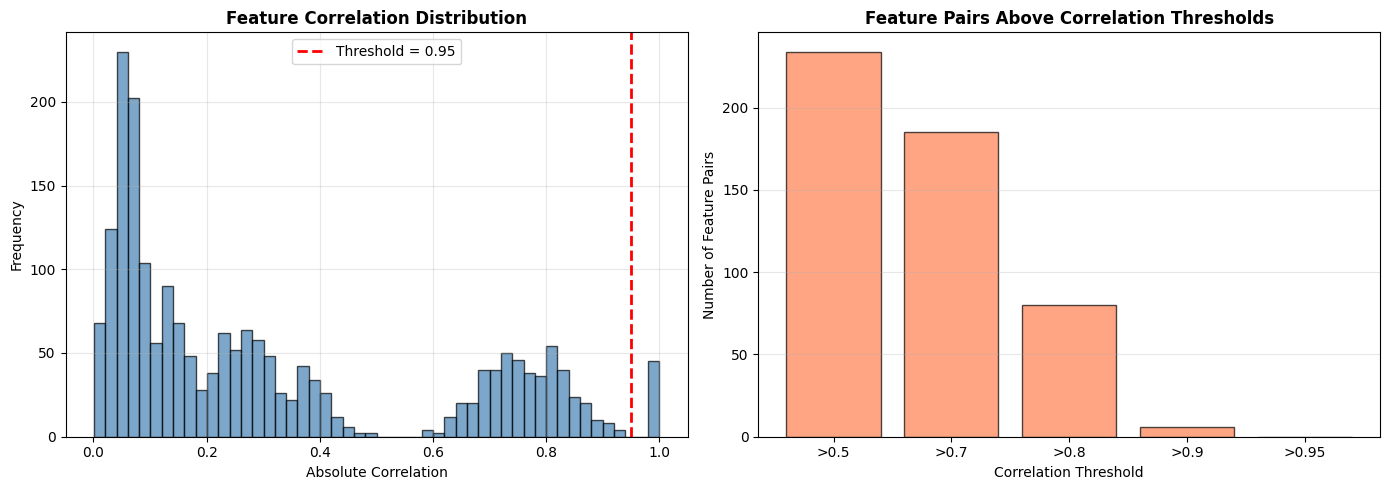


Correlation statistics:
Total feature pairs                      : 990
High correlation pairs Remaining (>0.95) : 0
Features removed                         : 21
Percentage of redundant features         : 46.7%
Removed Features                         : ['Corrected_Core_Speed', 'Physical_Core_Speed_roll_mean', 'Physical_Core_Speed_roll_max', 'Corrected_Core_Speed_roll_mean', 'Corrected_Core_Speed_roll_max', 'HPC_Outlet_Temp_roll_mean', 'LPT_Outlet_Temp_roll_mean', 'HPC_Outlet_Press_roll_mean', 'HPC_Outlet_Static_Press_roll_mean', 'Fuel_Flow_Ratio_roll_mean', 'Bleed_Enthalpy_roll_mean', 'HPT_Cool_Air_F_roll_mean', 'LPT_Cool_Air_F_roll_mean', 'LPT_Outlet_Temp_roll_max', 'HPC_Outlet_Static_Press_roll_max', 'HPC_Outlet_Press_roll_min', 'Physical_Core_Speed_roll_min', 'Corrected_Core_Speed_roll_min', 'HPC_Outlet_Static_Press_roll_min', 'Fuel_Flow_Ratio_roll_min', 'Fuel_Flow_Ratio_roll_max']


In [81]:
# 19b/ Feature correlation heatmap (after removal)
print_header("Feature Correlation Analysis")

# Get feature columns before removal
feature_cols = [col for col in train_set.columns if col not in ['unit', 'cycle', 'RUL']]

# Calculate correlation matrix
corr_matrix = train_set[feature_cols].corr().abs()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if corr_value > 0.95:
            feature_i = corr_matrix.columns[i]
            feature_j = corr_matrix.columns[j]
            high_corr_pairs.append((feature_i, feature_j, corr_value))

# Sort by correlation value
high_corr_pairs.sort(key=lambda x: x[2], reverse=True)


# Show top 10 highly correlated pairs
print(f"\nTop 10 highly correlated feature pairs (|corr| > 0.95):")
if len(high_corr_pairs) > 0:
    for i, (feat1, feat2, corr_val) in enumerate(high_corr_pairs[:10], 1):
        print(f"  {i:>2}. {feat1:<30} <-> {feat2:<30} | corr = {corr_val:.4f}")
    if len(high_corr_pairs) > 10:
        print(f"\n  ... and {len(high_corr_pairs) - 10} more pairs")
else:
    print("None found")

# Plot correlation distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation distribution histogram
axes[0].hist(corr_matrix.values.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0.95, color='red', linestyle='--', linewidth=2, label='Threshold = 0.95')
axes[0].set_title('Feature Correlation Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Absolute Correlation')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Count features by correlation threshold
thresholds = [0.5, 0.7, 0.8, 0.9, 0.95]
counts = []
for threshold in thresholds:
    count = 0
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:
                count += 1
    counts.append(count)

axes[1].bar(range(len(thresholds)), counts, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xticks(range(len(thresholds)))
axes[1].set_xticklabels([f'>{t}' for t in thresholds])
axes[1].set_title('Feature Pairs Above Correlation Thresholds', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Correlation Threshold')
axes[1].set_ylabel('Number of Feature Pairs')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nCorrelation statistics:")
print_kv([
    ("Total feature pairs", int(len(corr_matrix.columns) * (len(corr_matrix.columns) - 1) / 2)),
    ("High correlation pairs Remaining (>0.95)", len(high_corr_pairs)),
    ("Features removed", len(features_to_remove)),
    ("Percentage of redundant features", f"{len(features_to_remove) / len(feature_cols) * 100:.1f}%"),
    ("Removed Features", f"{features_to_remove}"),
])

In [82]:
# 20/ Prepare X/y splits
print_header("Prepare X/y Splits")

# Separate features (X) and target (y)
# Drop unit, cycle, and RUL columns to create feature matrix

# Train set
X_train = train_set.drop(['unit', 'cycle', 'RUL'], axis=1)
y_train = train_set['RUL'].copy()

# Validation set
X_val = val_set.drop(['unit', 'cycle', 'RUL'], axis=1)
y_val = val_set['RUL'].copy()

# Test set
X_test = test_clean.drop(['unit', 'cycle', 'RUL'], axis=1)
y_test = test_clean['RUL'].copy()

# Validation checks
assert X_train.shape[0] == len(y_train), "Train X/y row count mismatch"
assert X_val.shape[0] == len(y_val), "Val X/y row count mismatch"
assert X_test.shape[0] == len(y_test), "Test X/y row count mismatch"

assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1], "Feature count mismatch across sets"

assert X_train.isnull().sum().sum() == 0, "Train X contains nulls"
assert X_val.isnull().sum().sum() == 0, "Val X contains nulls"
assert X_test.isnull().sum().sum() == 0, "Test X contains nulls"

assert y_train.isnull().sum() == 0, "Train y contains nulls"
assert y_val.isnull().sum() == 0, "Val y contains nulls"
assert y_test.isnull().sum() == 0, "Test y contains nulls"

# Get feature names
feature_names = X_train.columns.tolist()
num_features = len(feature_names)

# Summary
print_kv([
            ("Number of features", num_features),
            ("X_train shape", X_train.shape),
            ("y_train shape", y_train.shape),
            ("X_val shape", X_val.shape),
            ("y_val shape", y_val.shape),
            ("X_test shape", X_test.shape),
            ("y_test shape", y_test.shape),
        ])

# Show first few feature names
print("\nFirst 10 features:")
for i, feature in enumerate(feature_names[:10], 1):
    print(f"  {i:>2}. {feature}")

# Target statistics
print("\nTarget (RUL) statistics:")
print_kv([
            ("y_train | mean / std", f"{y_train.mean():.1f} / {y_train.std():.1f}"),
            ("y_train | min / max", f"{y_train.min()} / {y_train.max()}"),
            ("y_val   | mean / std", f"{y_val.mean():.1f} / {y_val.std():.1f}"),
            ("y_val   | min / max", f"{y_val.min()} / {y_val.max()}"),
            ("y_test  | mean / std", f"{y_test.mean():.1f} / {y_test.std():.1f}"),
            ("y_test  | min / max", f"{y_test.min()} / {y_test.max()}"),
        ])

print("X/y split complete")


Prepare X/y Splits
Number of features : 45
X_train shape      : (16561, 45)
y_train shape      : (16561,)
X_val shape        : (4070, 45)
y_val shape        : (4070,)
X_test shape       : (13096, 45)
y_test shape       : (13096,)

First 10 features:
   1. LPC_Outlet_Temp
   2. HPC_Outlet_Temp
   3. LPT_Outlet_Temp
   4. HPC_Outlet_Press
   5. Physical_Core_Speed
   6. HPC_Outlet_Static_Press
   7. Fuel_Flow_Ratio
   8. Bleed_Enthalpy
   9. HPT_Cool_Air_F
  10. LPT_Cool_Air_F

Target (RUL) statistics:
y_train | mean / std : 108.4 / 69.6
y_train | min / max  : 0 / 361
y_val   | mean / std : 105.5 / 65.7
y_val   | min / max  : 0 / 268
y_test  | mean / std : 141.2 / 59.0
y_test  | min / max  : 7 / 340
X/y split complete



X/y Split Visualization


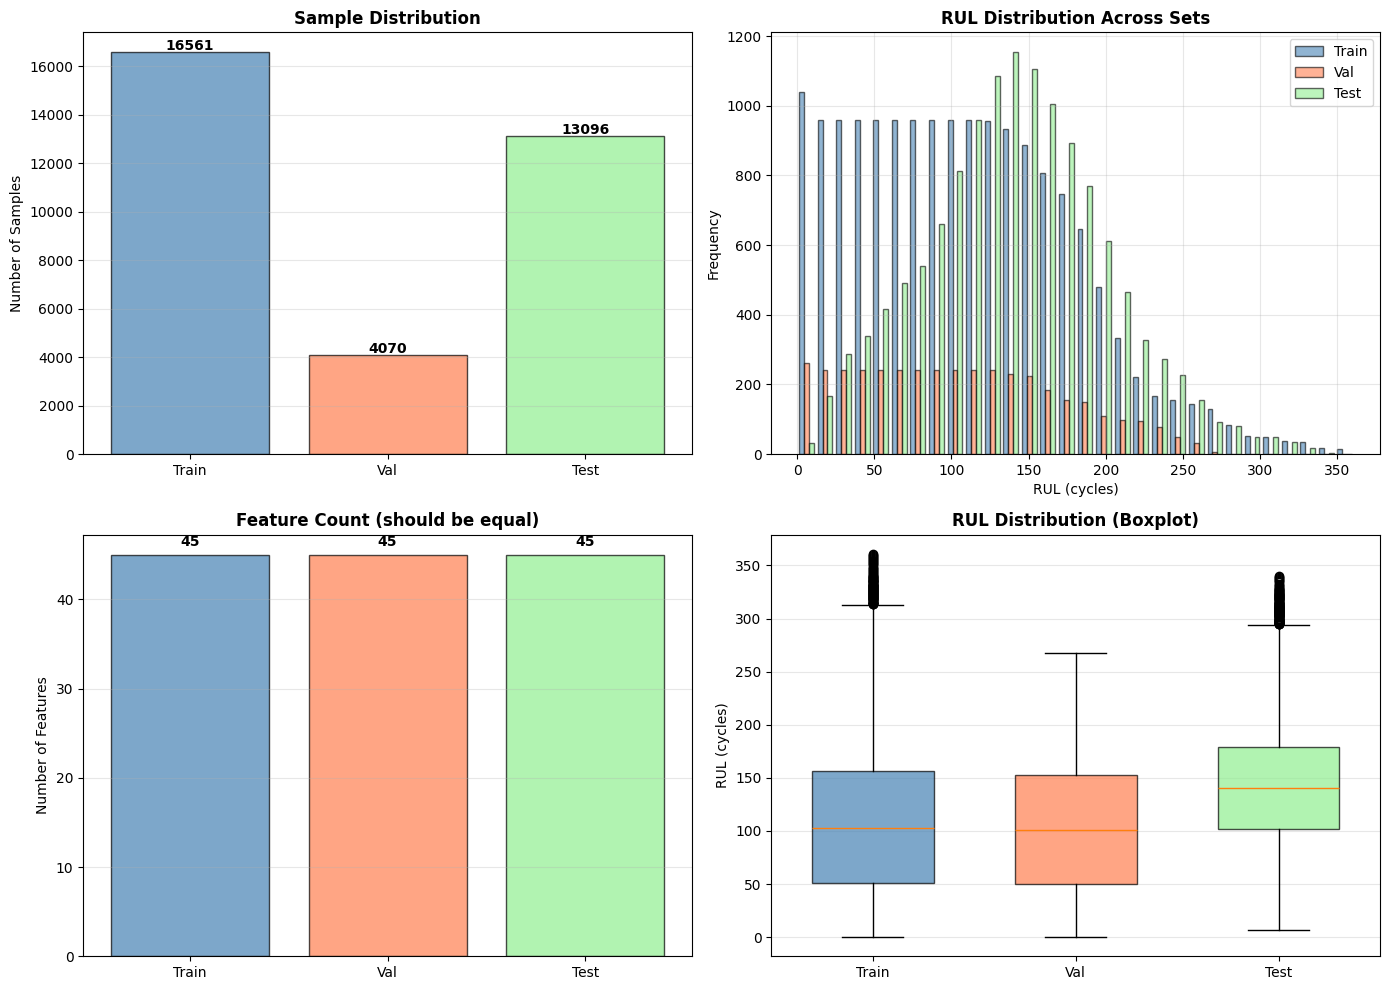


Data split summary:
Set        | Samples    | Features   | RUL mean     | RUL std     
----------------------------------------------------------------------
Train      | 16561      | 45         | 108.4        | 69.6        
Val        | 4070       | 45         | 105.5        | 65.7        
Test       | 13096      | 45         | 141.2        | 59.0        

X/y split visualization complete


In [83]:
# 20b/ X/y split visualization
print_header("X/y Split Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sample distribution across sets
axes[0, 0].bar(['Train', 'Val', 'Test'], 
               [len(X_train), len(X_val), len(X_test)],
               color=['steelblue', 'coral', 'lightgreen'],
               alpha=0.7,
               edgecolor='black')
axes[0, 0].set_title('Sample Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Samples')
axes[0, 0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, (label, count) in enumerate(zip(['Train', 'Val', 'Test'], 
                                        [len(X_train), len(X_val), len(X_test)])):
    axes[0, 0].text(i, count + 100, str(count), ha='center', fontweight='bold')

# 2. RUL distribution comparison
axes[0, 1].hist([y_train, y_val, y_test], 
                bins=30, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_title('RUL Distribution Across Sets', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('RUL (cycles)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Feature matrix shape comparison
feature_counts = [X_train.shape[1], X_val.shape[1], X_test.shape[1]]
axes[1, 0].bar(['Train', 'Val', 'Test'],
               feature_counts,
               color=['steelblue', 'coral', 'lightgreen'],
               alpha=0.7,
               edgecolor='black')
axes[1, 0].set_title('Feature Count (should be equal)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Features')
axes[1, 0].grid(alpha=0.3, axis='y')

# Add value labels
for i, count in enumerate(feature_counts):
    axes[1, 0].text(i, count + 1, str(count), ha='center', fontweight='bold')

# 4. RUL boxplot comparison
data_for_boxplot = [y_train, y_val, y_test]
box = axes[1, 1].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)

# Color the boxes
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 1].set_title('RUL Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('RUL (cycles)')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary table
print("\nData split summary:")
print(f"{'Set':<10} | {'Samples':<10} | {'Features':<10} | {'RUL mean':<12} | {'RUL std':<12}")
print("-" * 70)
print(f"{'Train':<10} | {len(X_train):<10} | {X_train.shape[1]:<10} | {y_train.mean():<12.1f} | {y_train.std():<12.1f}")
print(f"{'Val':<10} | {len(X_val):<10} | {X_val.shape[1]:<10} | {y_val.mean():<12.1f} | {y_val.std():<12.1f}")
print(f"{'Test':<10} | {len(X_test):<10} | {X_test.shape[1]:<10} | {y_test.mean():<12.1f} | {y_test.std():<12.1f}")

print("\nX/y split visualization complete")

## 5) Model Training & Evaluation

### 5.1) Random Forest

In [131]:
# 21/ Model Training - Random Forest
print_header("Model Training - Random Forest")

# Initialize model
print("Initializing Random Forest model...")
rf_model = RandomForestRegressor(
                                n_estimators=100,
                                max_depth=20,
                                min_samples_split=5,
                                min_samples_leaf=2,
                                random_state=42,
                                n_jobs=-1,
                                verbose=0
                            )

# Train model
print("Training model on train set...")
start_time = time.time()
rf_model.fit(X_train, y_train, sample_weight=train_weights)
rf_train_time = time.time() - start_time

# Make predictions on train set
print("Making predictions on train set...")
rf_y_train_pred = rf_model.predict(X_train)

# Make predictions on validation set
print("Making predictions on validation set...")
rf_y_val_pred = rf_model.predict(X_val)

# Make predictions on test set
print("Making predictions on test set...")
rf_y_test_pred = rf_model.predict(X_test)

# Calculate metrics for train set
rf_train_rmse = rmse(y_train, rf_y_train_pred)
rf_train_mae = MAE(y_train, rf_y_train_pred)
rf_train_r2 = r2_score(y_train, rf_y_train_pred)

# Calculate metrics for validation set
rf_val_rmse = rmse(y_val, rf_y_val_pred)
rf_val_mae = MAE(y_val, rf_y_val_pred)
rf_val_r2 = r2_score(y_val, rf_y_val_pred)

# Calculate metrics for test set
rf_test_rmse = rmse(y_test, rf_y_test_pred)
rf_test_mae = MAE(y_test, rf_y_test_pred)
rf_test_r2 = r2_score(y_test, rf_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("n_estimators", 100),
            ("max_depth", 20),
            ("min_samples_split", 5),
            ("min_samples_leaf", 2),
            ("Training time (seconds)", f"{rf_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{rf_train_rmse:.2f}"),
            ("MAE", f"{rf_train_mae:.2f}"),
            ("R2 Score", f"{rf_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{rf_val_rmse:.2f}"),
            ("MAE", f"{rf_val_mae:.2f}"),
            ("R2 Score", f"{rf_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{rf_test_rmse:.2f}"),
            ("MAE", f"{rf_test_mae:.2f}"),
            ("R2 Score", f"{rf_test_r2:.4f}"),
        ])

# Validation checks
assert rf_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert rf_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert rf_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

# Store results for comparison
results_dict['Random Forest'] = {
                                    'train_rmse': rf_train_rmse,
                                    'train_mae': rf_train_mae,
                                    'train_r2': rf_train_r2,
                                    'val_rmse': rf_val_rmse,
                                    'val_mae': rf_val_mae,
                                    'val_r2': rf_val_r2,
                                    'test_rmse': rf_test_rmse,
                                    'test_mae': rf_test_mae,
                                    'test_r2': rf_test_r2,
                                    'train_time': rf_train_time
                                }

print_header("Model training complete")


Model Training - Random Forest
Initializing Random Forest model...
Training model on train set...
Making predictions on train set...
Making predictions on validation set...
Making predictions on test set...

Model Parameters:
n_estimators            : 100
max_depth               : 20
min_samples_split       : 5
min_samples_leaf        : 2
Training time (seconds) : 13.57

Train Set Performance:
RMSE     : 6.25
MAE      : 3.62
R2 Score : 0.9919

Validation Set Performance:
RMSE     : 32.46
MAE      : 23.38
R2 Score : 0.7556

Test Set Performance:
RMSE     : 43.56
MAE      : 31.83
R2 Score : 0.4545

Model training complete



Model Performance Visualization


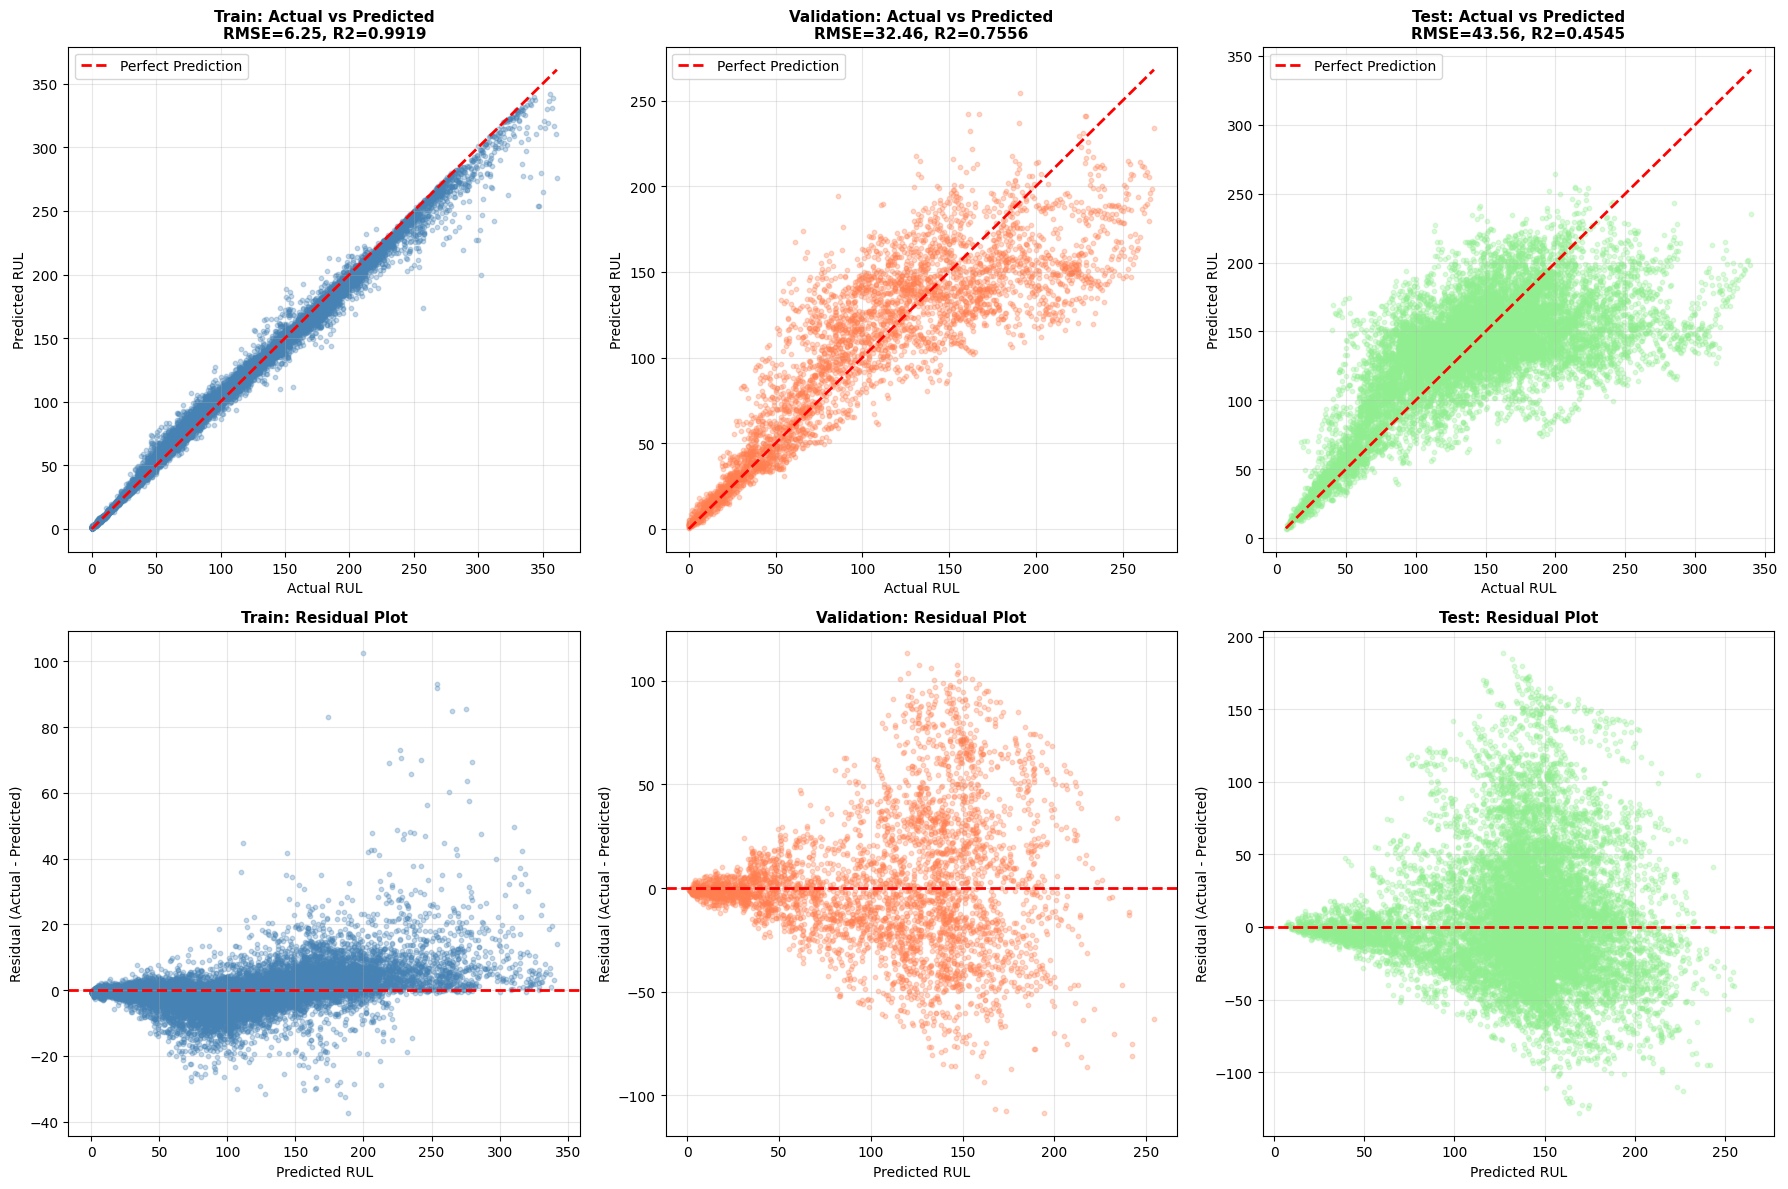


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 6.25            | 32.46           | 43.56          
MAE             | 3.62            | 23.38           | 31.83          
R2 Score        | 0.9919          | 0.7556          | 0.4545         

Visualization complete


In [132]:
# 21b/ Model Performance Visualization
print_header("Model Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, rf_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={rf_train_rmse:.2f}, R2={rf_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, rf_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={rf_val_rmse:.2f}, R2={rf_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, rf_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={rf_test_rmse:.2f}, R2={rf_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
train_residuals = y_train - rf_y_train_pred
axes[1, 0].scatter(rf_y_train_pred, train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
val_residuals = y_val - rf_y_val_pred
axes[1, 1].scatter(rf_y_val_pred, val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
test_residuals = y_test - rf_y_test_pred
axes[1, 2].scatter(rf_y_test_pred, test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {rf_train_rmse:<15.2f} | {rf_val_rmse:<15.2f} | {rf_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {rf_train_mae:<15.2f} | {rf_val_mae:<15.2f} | {rf_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {rf_train_r2:<15.4f} | {rf_val_r2:<15.4f} | {rf_test_r2:<15.4f}")

print("\nVisualization complete")


Feature Importance Analysis
Top 20 Most Important Features:
  LPT_Cool_Air_F_roll_min                  : 0.514291
  HPC_Outlet_Static_Press_roll_slope       : 0.066466
  LPC_Outlet_Temp_roll_mean                : 0.056713
  HPC_Outlet_Temp_roll_max                 : 0.042331
  Physical_Core_Speed                      : 0.033906
  LPT_Outlet_Temp_roll_slope               : 0.021463
  HPT_Cool_Air_F_roll_min                  : 0.018403
  Fuel_Flow_Ratio_roll_slope               : 0.017014
  LPT_Outlet_Temp_roll_min                 : 0.016453
  HPC_Outlet_Press_roll_max                : 0.016190
  LPC_Outlet_Temp_roll_max                 : 0.013261
  HPC_Outlet_Temp_roll_min                 : 0.012921
  HPT_Cool_Air_F_roll_slope                : 0.012245
  Corrected_Core_Speed_roll_std            : 0.010690
  Corrected_Core_Speed_roll_slope          : 0.010503
  LPC_Outlet_Temp_roll_min                 : 0.010342
  Physical_Core_Speed_roll_std             : 0.009867
  LPT_Cool_Air_F_roll

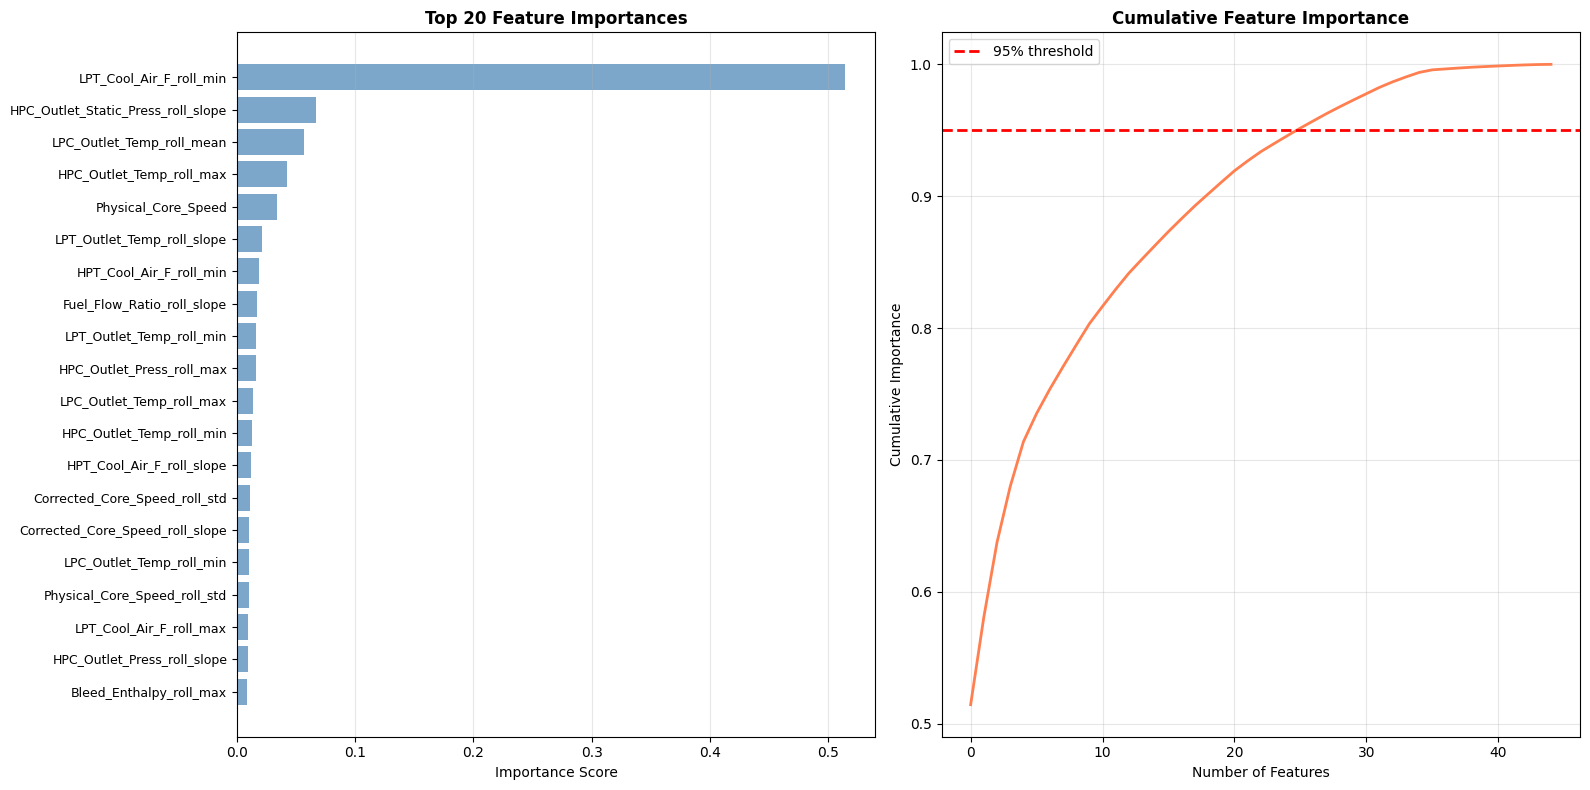


Features needed for 95% importance: 26 out of 45

Feature importance analysis complete


In [133]:
# 21c/ Feature Importance Analysis
print_header("Feature Importance Analysis")

# Get feature importances from the model
feature_importances = rf_model.feature_importances_

# Create dataframe for better handling
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
for i, row in importance_df.head(20).iterrows():
    print(f"  {row['feature']:<40} : {row['importance']:.6f}")

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - top 20
top_20 = importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Cumulative importance
cumsum = importance_df['importance'].cumsum()
axes[1].plot(range(len(cumsum)), cumsum.values, color='coral', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate how many features needed for 95% importance
features_for_95 = (cumsum <= 0.95).sum() + 1
print(f"\nFeatures needed for 95% importance: {features_for_95} out of {len(feature_names)}")

print("\nFeature importance analysis complete")


Prediction Error Distribution


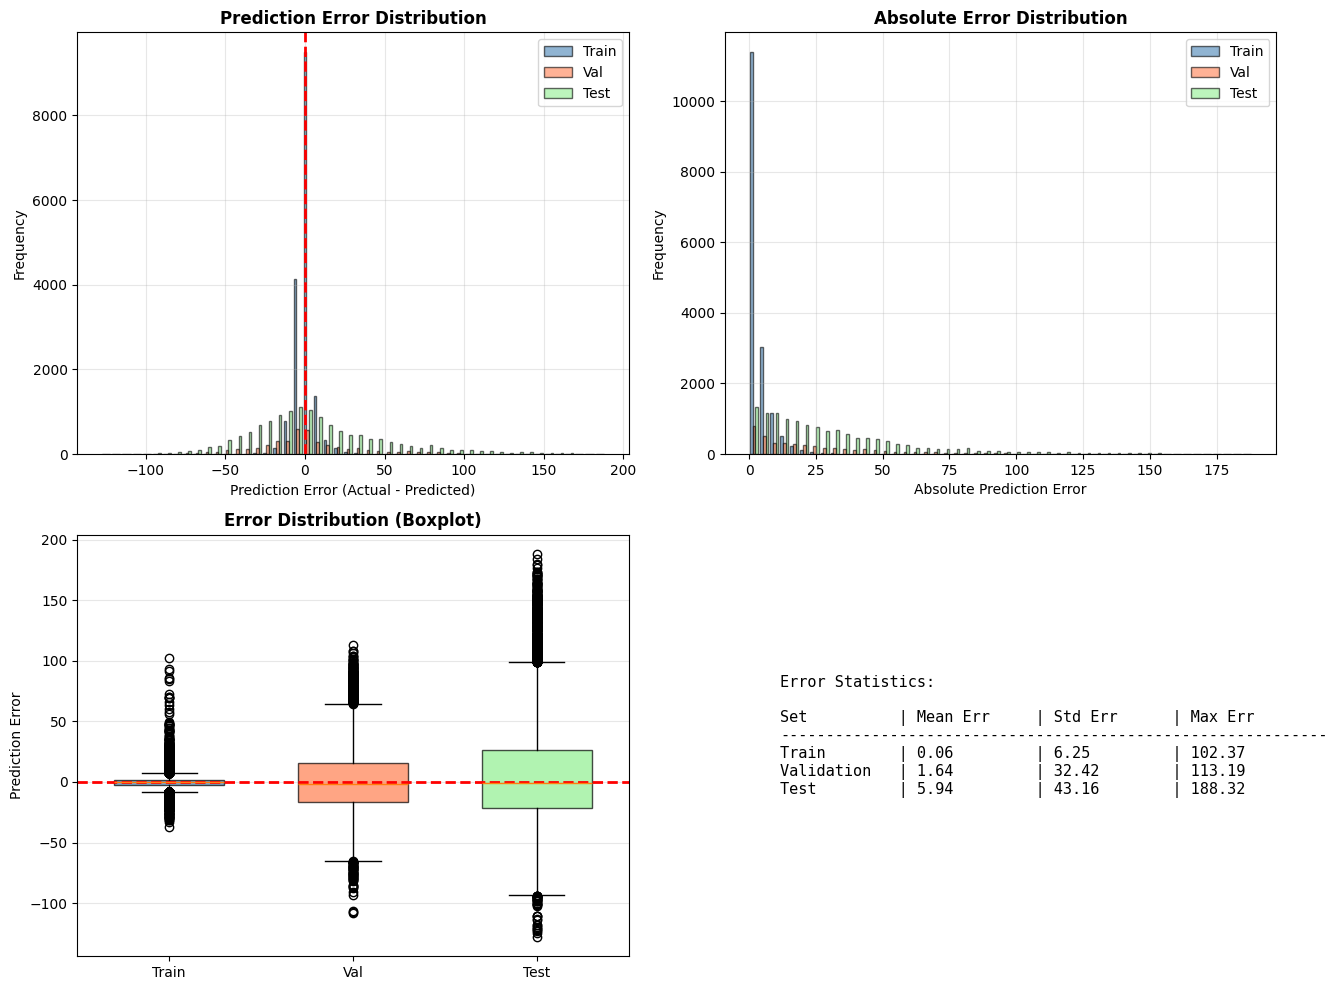


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | 0.06         | 6.25         | 102.37      
Validation   | 1.64         | 32.42        | 113.19      
Test         | 5.94         | 43.16        | 188.32      

Error distribution analysis complete


In [134]:
# 21d/ Prediction Error Distribution
print_header("Prediction Error Distribution")

# Calculate absolute errors
train_abs_errors = np.abs(train_residuals)
val_abs_errors = np.abs(val_residuals)
test_abs_errors = np.abs(test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([train_residuals, val_residuals, test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')

axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([train_abs_errors, val_abs_errors, test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')

axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [train_residuals, val_residuals, test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)

colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {train_residuals.mean():<12.2f} | {train_residuals.std():<12.2f} | {train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {val_residuals.mean():<12.2f} | {val_residuals.std():<12.2f} | {val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {test_residuals.mean():<12.2f} | {test_residuals.std():<12.2f} | {test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {train_residuals.mean():<12.2f} | {train_residuals.std():<12.2f} | {train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {val_residuals.mean():<12.2f} | {val_residuals.std():<12.2f} | {val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {test_residuals.mean():<12.2f} | {test_residuals.std():<12.2f} | {test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.2) Linear Regression - Baseline

In [135]:
# 22/ Model Training - Linear Regression (Baseline)
print_header("Model Training - Linear Regression (Baseline)")



# Initialize model
print("Initializing Linear Regression model...")
lr_model = LinearRegression()

# Train model
print("Training model on train set...")
start_time = time.time()
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start_time

# Make predictions on train set
print("Making predictions on train set...")
lr_y_train_pred = lr_model.predict(X_train)

# Make predictions on validation set
print("Making predictions on validation set...")
lr_y_val_pred = lr_model.predict(X_val)

# Make predictions on test set
print("Making predictions on test set...")
lr_y_test_pred = lr_model.predict(X_test)

# Calculate metrics for train set
lr_train_rmse = rmse(y_train, lr_y_train_pred)
lr_train_mae = MAE(y_train, lr_y_train_pred)
lr_train_r2 = r2_score(y_train, lr_y_train_pred)

# Calculate metrics for validation set
lr_val_rmse = rmse(y_val, lr_y_val_pred)
lr_val_mae = MAE(y_val, lr_y_val_pred)
lr_val_r2 = r2_score(y_val, lr_y_val_pred)

# Calculate metrics for test set
lr_test_rmse = rmse(y_test, lr_y_test_pred)
lr_test_mae = MAE(y_test, lr_y_test_pred)
lr_test_r2 = r2_score(y_test, lr_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("Model Type", "Linear Regression"),
            ("Training time (seconds)", f"{lr_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{lr_train_rmse:.2f}"),
            ("MAE", f"{lr_train_mae:.2f}"),
            ("R2 Score", f"{lr_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{lr_val_rmse:.2f}"),
            ("MAE", f"{lr_val_mae:.2f}"),
            ("R2 Score", f"{lr_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{lr_test_rmse:.2f}"),
            ("MAE", f"{lr_test_mae:.2f}"),
            ("R2 Score", f"{lr_test_r2:.4f}"),
        ])

# Validation checks
assert lr_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert lr_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert lr_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

results_dict['Linear Regression'] = {
                                        'train_rmse': lr_train_rmse,
                                        'train_mae': lr_train_mae,
                                        'train_r2': lr_train_r2,
                                        'val_rmse': lr_val_rmse,
                                        'val_mae': lr_val_mae,
                                        'val_r2': lr_val_r2,
                                        'test_rmse': lr_test_rmse,
                                        'test_mae': lr_test_mae,
                                        'test_r2': lr_test_r2,
                                        'train_time': lr_train_time
                                    }

print_header("Linear Regression training complete")


Model Training - Linear Regression (Baseline)
Initializing Linear Regression model...
Training model on train set...
Making predictions on train set...
Making predictions on validation set...
Making predictions on test set...

Model Parameters:
Model Type              : Linear Regression
Training time (seconds) : 0.07

Train Set Performance:
RMSE     : 43.15
MAE      : 32.84
R2 Score : 0.6160

Validation Set Performance:
RMSE     : 36.69
MAE      : 29.52
R2 Score : 0.6877

Test Set Performance:
RMSE     : 46.02
MAE      : 35.01
R2 Score : 0.3912

Linear Regression training complete



Linear Regression - Performance Visualization


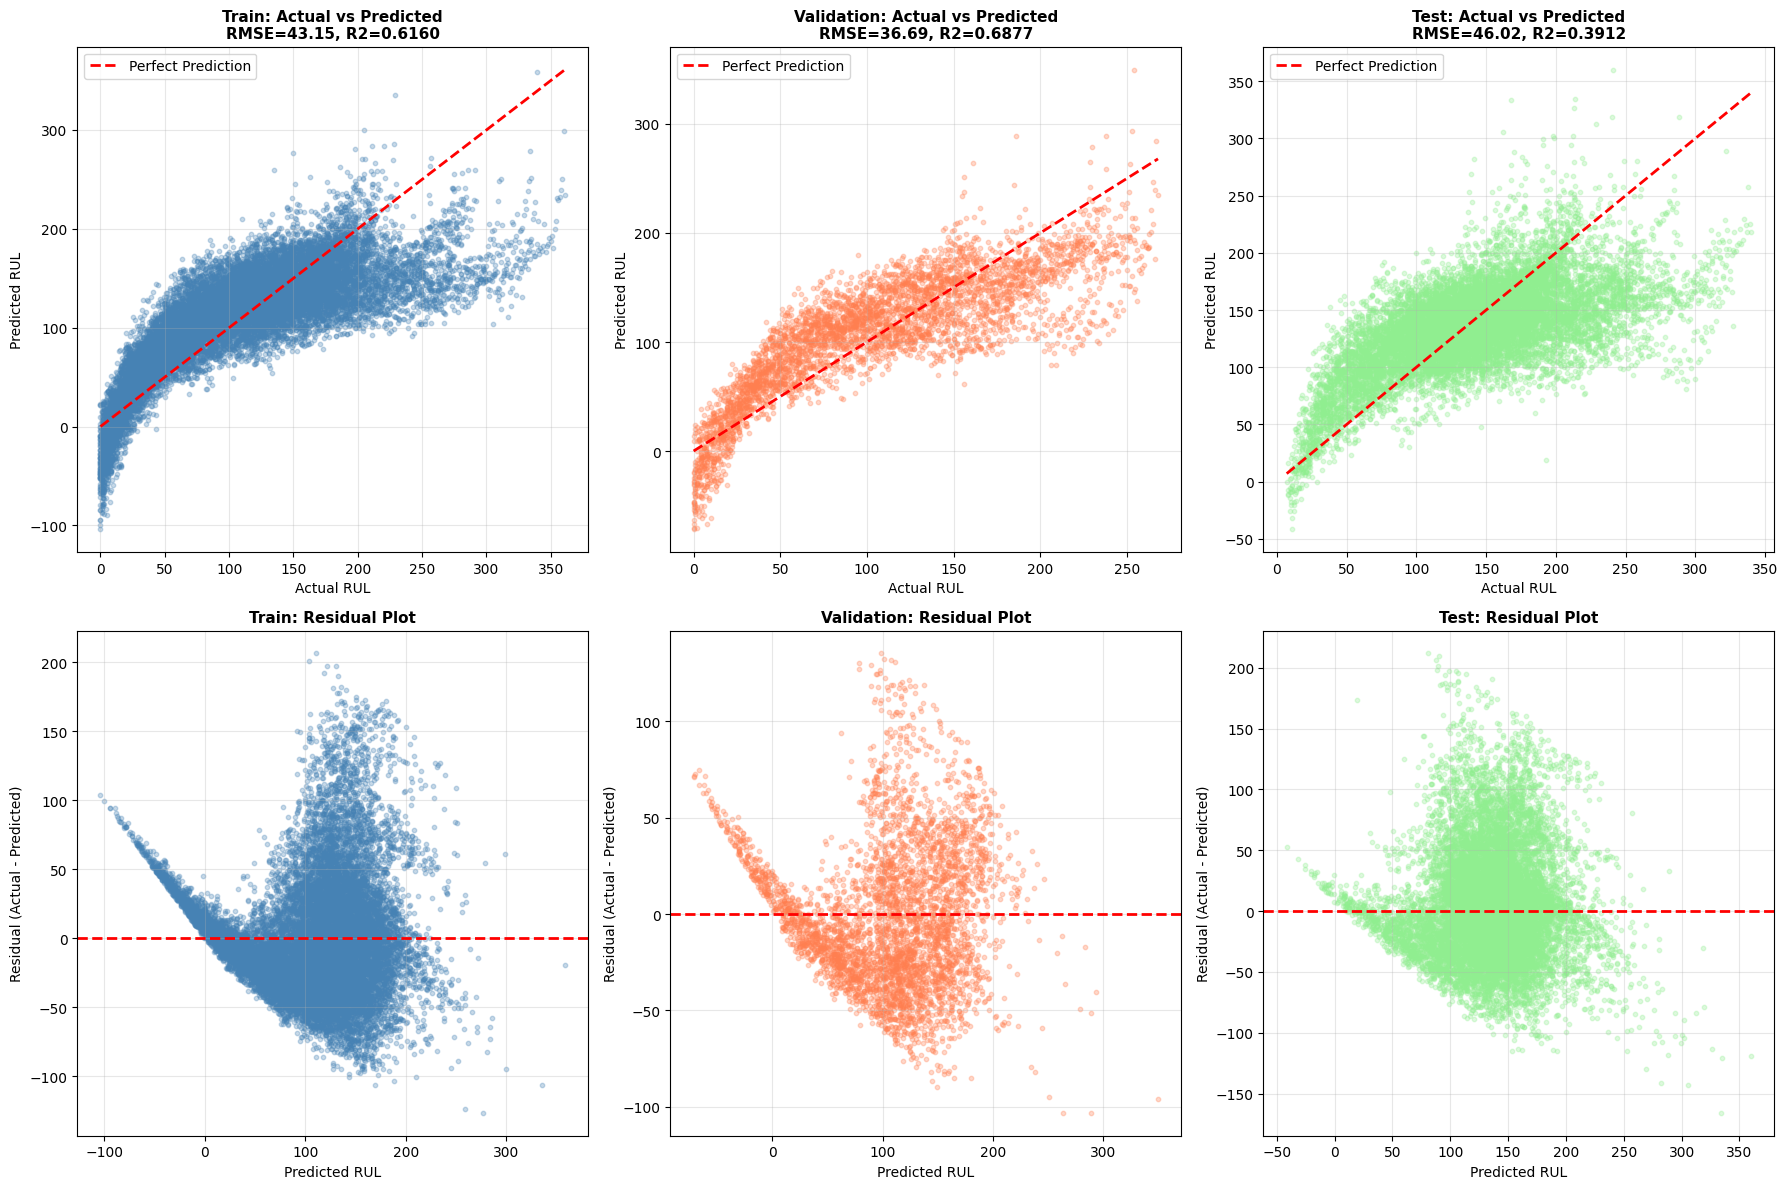


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 43.15           | 36.69           | 46.02          
MAE             | 32.84           | 29.52           | 35.01          
R2 Score        | 0.6160          | 0.6877          | 0.3912         

Visualization complete


In [136]:
# 22a-viz1/ Linear Regression - Performance Visualization
print_header("Linear Regression - Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, lr_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={lr_train_rmse:.2f}, R2={lr_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, lr_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={lr_val_rmse:.2f}, R2={lr_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, lr_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={lr_test_rmse:.2f}, R2={lr_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
lr_train_residuals = y_train - lr_y_train_pred
axes[1, 0].scatter(lr_y_train_pred, lr_train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
lr_val_residuals = y_val - lr_y_val_pred
axes[1, 1].scatter(lr_y_val_pred, lr_val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
lr_test_residuals = y_test - lr_y_test_pred
axes[1, 2].scatter(lr_y_test_pred, lr_test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {lr_train_rmse:<15.2f} | {lr_val_rmse:<15.2f} | {lr_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {lr_train_mae:<15.2f} | {lr_val_mae:<15.2f} | {lr_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {lr_train_r2:<15.4f} | {lr_val_r2:<15.4f} | {lr_test_r2:<15.4f}")

print("\nVisualization complete")


Linear Regression - Coefficients Analysis
Top 20 Features by Coefficient Magnitude:
  HPC_Outlet_Temp_roll_std                 : 112.103477
  HPC_Outlet_Static_Press_roll_std         : -57.157525
  Fuel_Flow_Ratio_roll_std                 : -49.846518
  Corrected_Core_Speed_roll_slope          :  46.058443
  LPC_Outlet_Temp_roll_mean                : -41.799477
  LPC_Outlet_Temp_roll_std                 :  30.765026
  HPC_Outlet_Temp_roll_max                 : -29.357586
  Corrected_Core_Speed_roll_std            :  27.516190
  LPT_Cool_Air_F_roll_std                  :  24.305957
  LPT_Outlet_Temp_roll_std                 : -23.113341
  HPC_Outlet_Temp_roll_min                 :  22.554426
  Physical_Core_Speed_roll_std             :  21.948986
  HPT_Cool_Air_F_roll_slope                :  21.934663
  HPT_Cool_Air_F_roll_max                  : -21.341029
  Bleed_Enthalpy_roll_std                  :  20.138173
  LPT_Outlet_Temp_roll_min                 :  18.021153
  Physical_Core_Spe

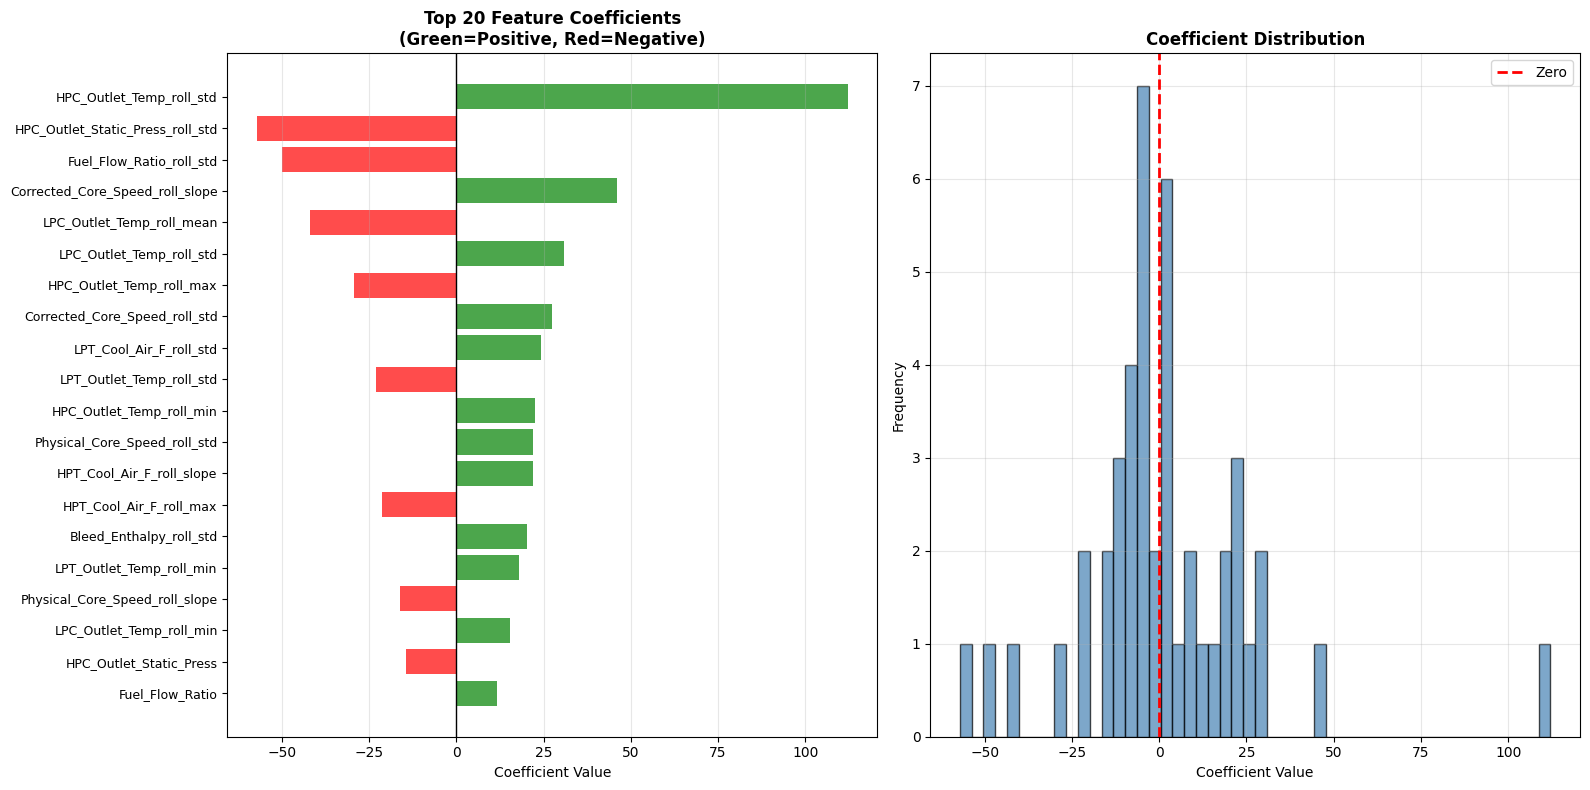


Coefficient Statistics:
Intercept             : 178.7037
Total features        : 45
Positive coefficients : 21
Negative coefficients : 24
Max coefficient       : 112.103477
Min coefficient       : -57.157525

Coefficient analysis complete


In [137]:
# 22b-viz2/ Linear Regression - Coefficients Analysis
print_header("Linear Regression - Coefficients Analysis")

# Get model coefficients
lr_coefficients = lr_model.coef_

# Create dataframe for better handling
lr_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': lr_coefficients
})

# Get absolute values for sorting
lr_coef_df['abs_coefficient'] = np.abs(lr_coef_df['coefficient'])

# Sort by absolute coefficient value
lr_coef_df = lr_coef_df.sort_values('abs_coefficient', ascending=False)

# Display top 20 features by coefficient magnitude
print("Top 20 Features by Coefficient Magnitude:")
for i, row in lr_coef_df.head(20).iterrows():
    print(f"  {row['feature']:<40} : {row['coefficient']:>10.6f}")

# Plot top 20 coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - top 20 by absolute value
top_20 = lr_coef_df.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20['coefficient'].values]
axes[0].barh(range(len(top_20)), top_20['coefficient'].values, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values, fontsize=9)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 20 Feature Coefficients\n(Green=Positive, Red=Negative)', 
                  fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Coefficient distribution
axes[1].hist(lr_coefficients, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Coefficient Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nCoefficient Statistics:")
print_kv([
    ("Intercept", f"{lr_model.intercept_:.4f}"),
    ("Total features", len(lr_coefficients)),
    ("Positive coefficients", int((lr_coefficients > 0).sum())),
    ("Negative coefficients", int((lr_coefficients < 0).sum())),
    ("Max coefficient", f"{lr_coefficients.max():.6f}"),
    ("Min coefficient", f"{lr_coefficients.min():.6f}"),
])

print("\nCoefficient analysis complete")


Linear Regression - Error Distribution


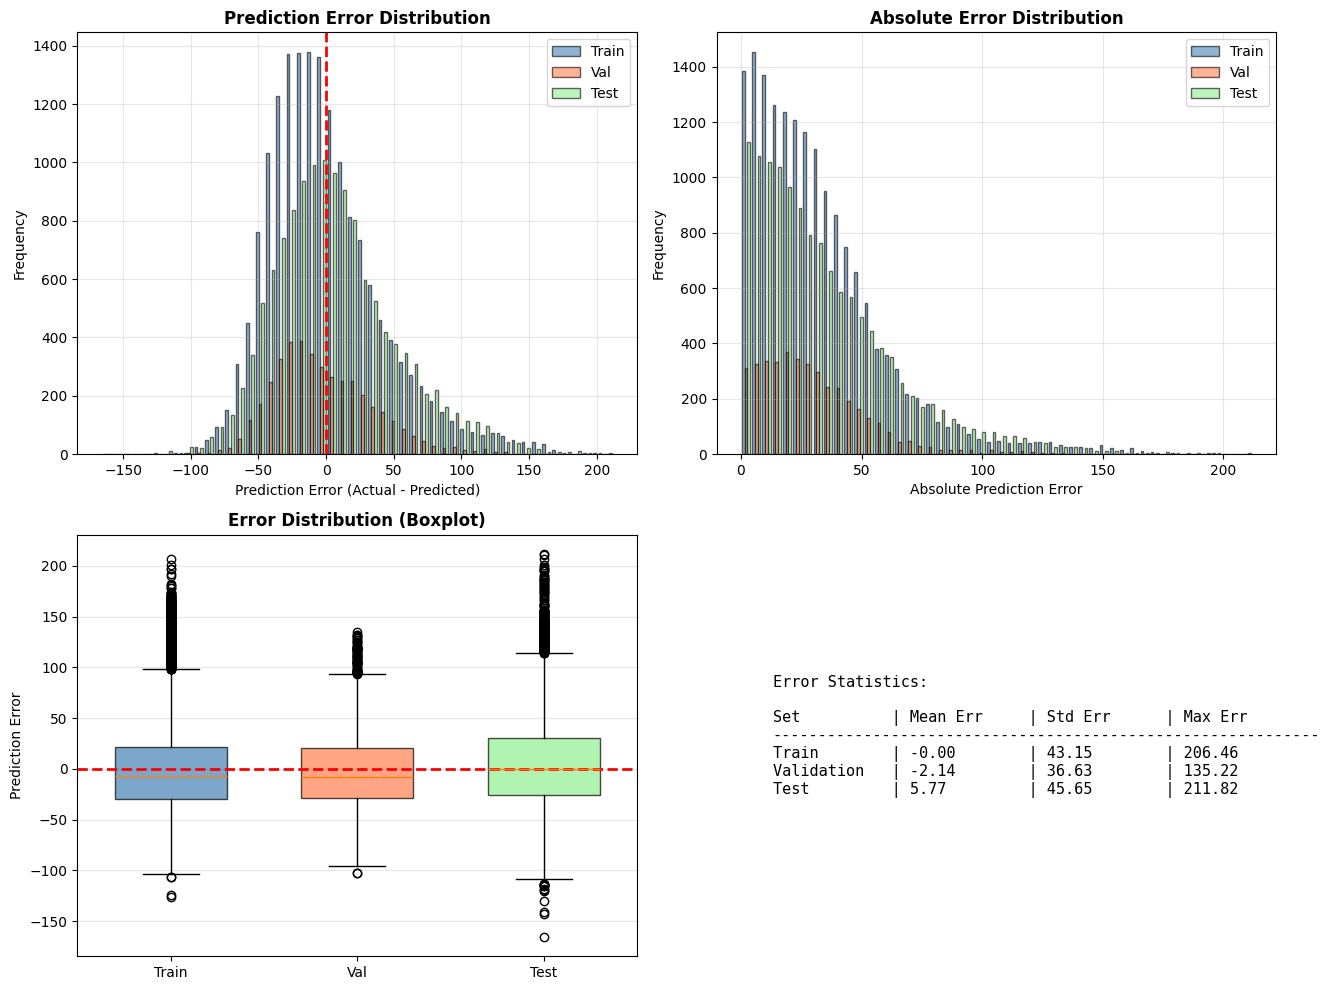


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | -0.00        | 43.15        | 206.46      
Validation   | -2.14        | 36.63        | 135.22      
Test         | 5.77         | 45.65        | 211.82      

Error distribution analysis complete


In [138]:
# 22c-viz3/ Linear Regression - Error Distribution
print_header("Linear Regression - Error Distribution")

# Calculate absolute errors
lr_train_abs_errors = np.abs(lr_train_residuals)
lr_val_abs_errors = np.abs(lr_val_residuals)
lr_test_abs_errors = np.abs(lr_test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([lr_train_residuals, lr_val_residuals, lr_test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([lr_train_abs_errors, lr_val_abs_errors, lr_test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [lr_train_residuals, lr_val_residuals, lr_test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {lr_train_residuals.mean():<12.2f} | {lr_train_residuals.std():<12.2f} | {lr_train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {lr_val_residuals.mean():<12.2f} | {lr_val_residuals.std():<12.2f} | {lr_val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {lr_test_residuals.mean():<12.2f} | {lr_test_residuals.std():<12.2f} | {lr_test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {lr_train_residuals.mean():<12.2f} | {lr_train_residuals.std():<12.2f} | {lr_train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {lr_val_residuals.mean():<12.2f} | {lr_val_residuals.std():<12.2f} | {lr_val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {lr_test_residuals.mean():<12.2f} | {lr_test_residuals.std():<12.2f} | {lr_test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.3) Ridge Regression

In [139]:
# 23/ Model Training - Ridge Regression
print_header("Model Training - Ridge Regression")



# Initialize model
print("Initializing Ridge Regression model...")
ridge_model = Ridge(alpha=1.0, random_state=42)

# Train model
print("Training model on train set...")
start_time = time.time()
ridge_model.fit(X_train, y_train)
ridge_train_time = time.time() - start_time

# Make predictions on train set
print("Making predictions on train set...")
ridge_y_train_pred = ridge_model.predict(X_train)

# Make predictions on validation set
print("Making predictions on validation set...")
ridge_y_val_pred = ridge_model.predict(X_val)

# Make predictions on test set
print("Making predictions on test set...")
ridge_y_test_pred = ridge_model.predict(X_test)

# Calculate metrics for train set
ridge_train_rmse = rmse(y_train, ridge_y_train_pred)
ridge_train_mae = MAE(y_train, ridge_y_train_pred)
ridge_train_r2 = r2_score(y_train, ridge_y_train_pred)

# Calculate metrics for validation set
ridge_val_rmse = rmse(y_val, ridge_y_val_pred)
ridge_val_mae = MAE(y_val, ridge_y_val_pred)
ridge_val_r2 = r2_score(y_val, ridge_y_val_pred)

# Calculate metrics for test set
ridge_test_rmse = rmse(y_test, ridge_y_test_pred)
ridge_test_mae = MAE(y_test, ridge_y_test_pred)
ridge_test_r2 = r2_score(y_test, ridge_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("Model Type", "Ridge Regression"),
            ("Alpha (regularization)", 1.0),
            ("Training time (seconds)", f"{ridge_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{ridge_train_rmse:.2f}"),
            ("MAE", f"{ridge_train_mae:.2f}"),
            ("R2 Score", f"{ridge_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{ridge_val_rmse:.2f}"),
            ("MAE", f"{ridge_val_mae:.2f}"),
            ("R2 Score", f"{ridge_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{ridge_test_rmse:.2f}"),
            ("MAE", f"{ridge_test_mae:.2f}"),
            ("R2 Score", f"{ridge_test_r2:.4f}"),
        ])

# Validation checks
assert ridge_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert ridge_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert ridge_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

# Store results for comparison
results_dict['Ridge Regression'] = {
                                        'train_rmse': ridge_train_rmse,
                                        'train_mae': ridge_train_mae,
                                        'train_r2': ridge_train_r2,
                                        'val_rmse': ridge_val_rmse,
                                        'val_mae': ridge_val_mae,
                                        'val_r2': ridge_val_r2,
                                        'test_rmse': ridge_test_rmse,
                                        'test_mae': ridge_test_mae,
                                        'test_r2': ridge_test_r2,
                                        'train_time': ridge_train_time
                                    }

print("\nRidge Regression training complete")


Model Training - Ridge Regression
Initializing Ridge Regression model...
Training model on train set...
Making predictions on train set...
Making predictions on validation set...
Making predictions on test set...

Model Parameters:
Model Type              : Ridge Regression
Alpha (regularization)  : 1.0
Training time (seconds) : 0.11

Train Set Performance:
RMSE     : 43.15
MAE      : 32.84
R2 Score : 0.6160

Validation Set Performance:
RMSE     : 36.65
MAE      : 29.50
R2 Score : 0.6884

Test Set Performance:
RMSE     : 45.99
MAE      : 34.99
R2 Score : 0.3919

Ridge Regression training complete



Ridge Regression - Performance Visualization


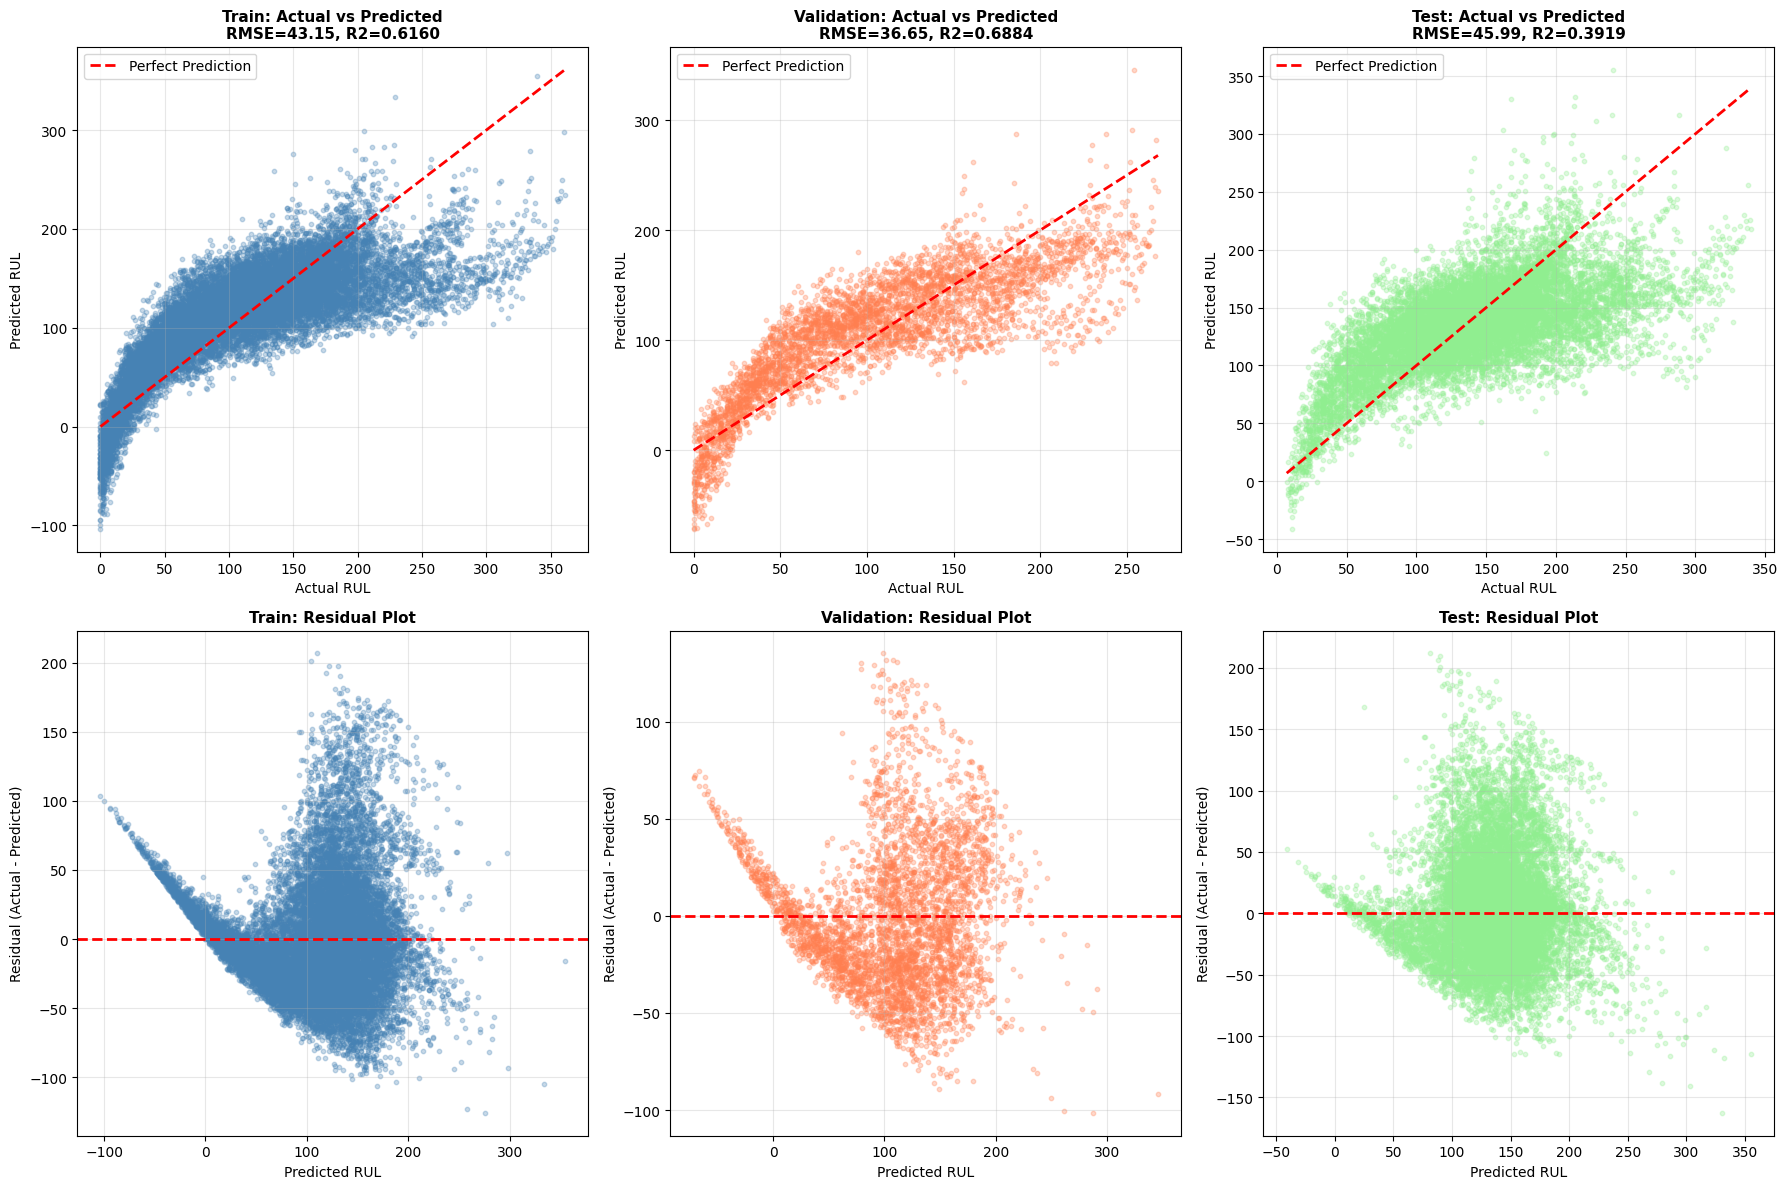


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 43.15           | 36.65           | 45.99          
MAE             | 32.84           | 29.50           | 34.99          
R2 Score        | 0.6160          | 0.6884          | 0.3919         

Visualization complete


In [140]:
# 23a-viz1/ Ridge Regression - Performance Visualization
print_header("Ridge Regression - Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, ridge_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={ridge_train_rmse:.2f}, R2={ridge_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, ridge_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={ridge_val_rmse:.2f}, R2={ridge_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, ridge_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={ridge_test_rmse:.2f}, R2={ridge_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
ridge_train_residuals = y_train - ridge_y_train_pred
axes[1, 0].scatter(ridge_y_train_pred, ridge_train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
ridge_val_residuals = y_val - ridge_y_val_pred
axes[1, 1].scatter(ridge_y_val_pred, ridge_val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
ridge_test_residuals = y_test - ridge_y_test_pred
axes[1, 2].scatter(ridge_y_test_pred, ridge_test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {ridge_train_rmse:<15.2f} | {ridge_val_rmse:<15.2f} | {ridge_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {ridge_train_mae:<15.2f} | {ridge_val_mae:<15.2f} | {ridge_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {ridge_train_r2:<15.4f} | {ridge_val_r2:<15.4f} | {ridge_test_r2:<15.4f}")

print("\nVisualization complete")


Ridge Regression - Coefficients Analysis
Top 20 Features by Coefficient Magnitude:
  HPC_Outlet_Temp_roll_std                 : 109.331804
  HPC_Outlet_Static_Press_roll_std         : -55.671667
  Fuel_Flow_Ratio_roll_std                 : -48.786544
  Corrected_Core_Speed_roll_slope          :  44.414442
  LPC_Outlet_Temp_roll_mean                : -41.452085
  LPC_Outlet_Temp_roll_std                 :  29.907274
  HPC_Outlet_Temp_roll_max                 : -28.904288
  Corrected_Core_Speed_roll_std            :  27.391066
  LPT_Cool_Air_F_roll_std                  :  23.968677
  LPT_Outlet_Temp_roll_std                 : -22.278120
  HPC_Outlet_Temp_roll_min                 :  22.109945
  Physical_Core_Speed_roll_std             :  21.932147
  HPT_Cool_Air_F_roll_slope                :  21.593629
  HPT_Cool_Air_F_roll_max                  : -21.495558
  Bleed_Enthalpy_roll_std                  :  19.715373
  LPT_Outlet_Temp_roll_min                 :  18.150756
  Physical_Core_Spee

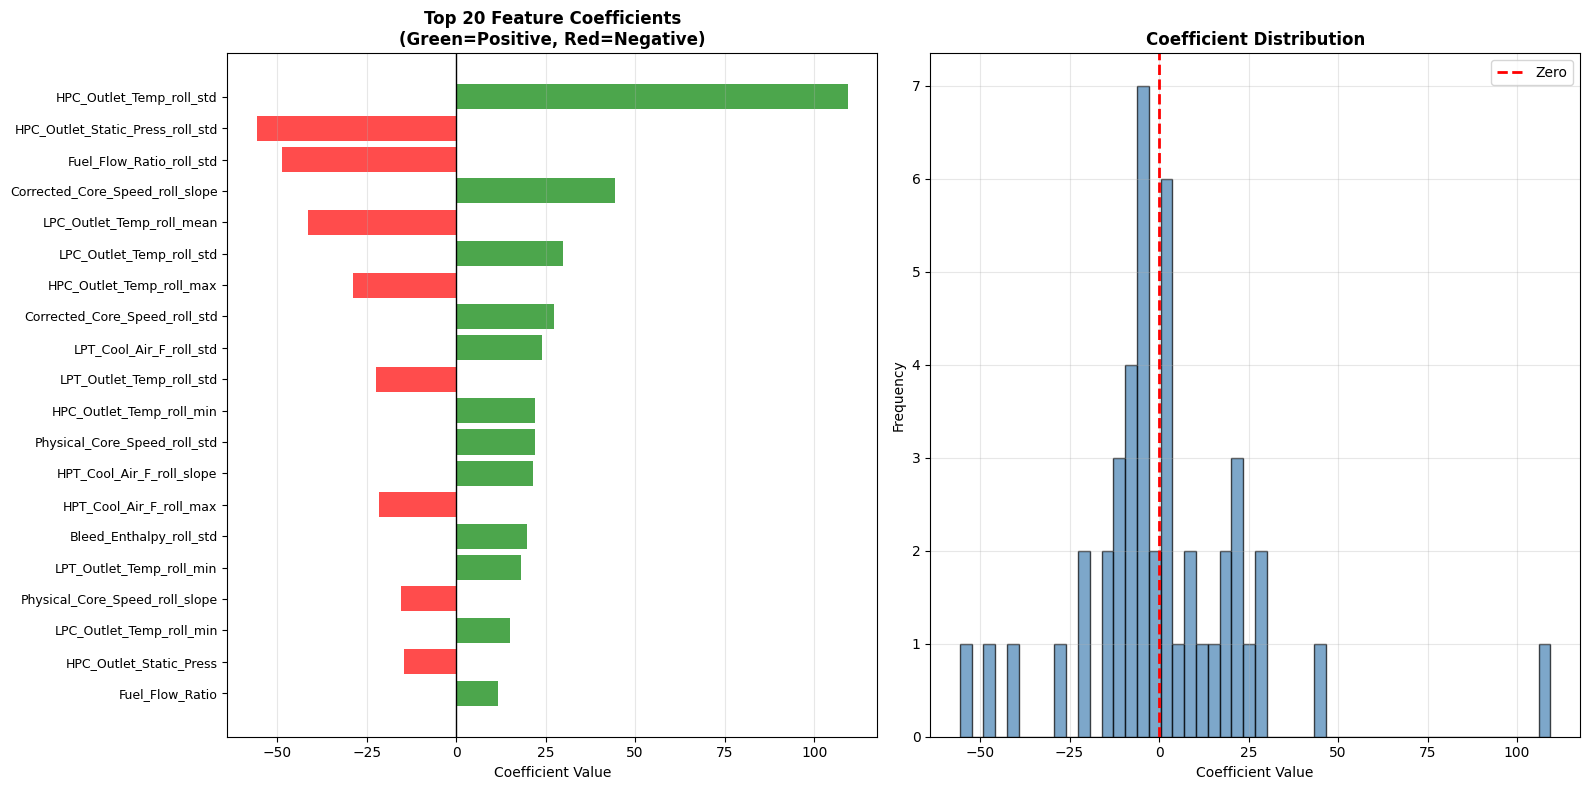


Coefficient Statistics:
Intercept             : 178.8345
Total features        : 45
Positive coefficients : 21
Negative coefficients : 24
Max coefficient       : 109.331804
Min coefficient       : -55.671667

Coefficient analysis complete


In [141]:
# 23b-viz2/ Ridge Regression - Coefficients Analysis
print_header("Ridge Regression - Coefficients Analysis")

# Get model coefficients
ridge_coefficients = ridge_model.coef_

# Create dataframe for better handling
ridge_coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': ridge_coefficients
})

# Get absolute values for sorting
ridge_coef_df['abs_coefficient'] = np.abs(ridge_coef_df['coefficient'])

# Sort by absolute coefficient value
ridge_coef_df = ridge_coef_df.sort_values('abs_coefficient', ascending=False)

# Display top 20 features by coefficient magnitude
print("Top 20 Features by Coefficient Magnitude:")
for i, row in ridge_coef_df.head(20).iterrows():
    print(f"  {row['feature']:<40} : {row['coefficient']:>10.6f}")

# Plot top 20 coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - top 20 by absolute value
top_20 = ridge_coef_df.head(20)
colors = ['green' if x > 0 else 'red' for x in top_20['coefficient'].values]
axes[0].barh(range(len(top_20)), top_20['coefficient'].values, color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values, fontsize=9)
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 20 Feature Coefficients\n(Green=Positive, Red=Negative)', 
                  fontsize=12, fontweight='bold')
axes[0].axvline(x=0, color='black', linestyle='-', linewidth=1)
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Coefficient distribution
axes[1].hist(ridge_coefficients, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Coefficient Distribution', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\nCoefficient Statistics:")
print_kv([
    ("Intercept", f"{ridge_model.intercept_:.4f}"),
    ("Total features", len(ridge_coefficients)),
    ("Positive coefficients", int((ridge_coefficients > 0).sum())),
    ("Negative coefficients", int((ridge_coefficients < 0).sum())),
    ("Max coefficient", f"{ridge_coefficients.max():.6f}"),
    ("Min coefficient", f"{ridge_coefficients.min():.6f}"),
])

print("\nCoefficient analysis complete")


Ridge Regression - Error Distribution


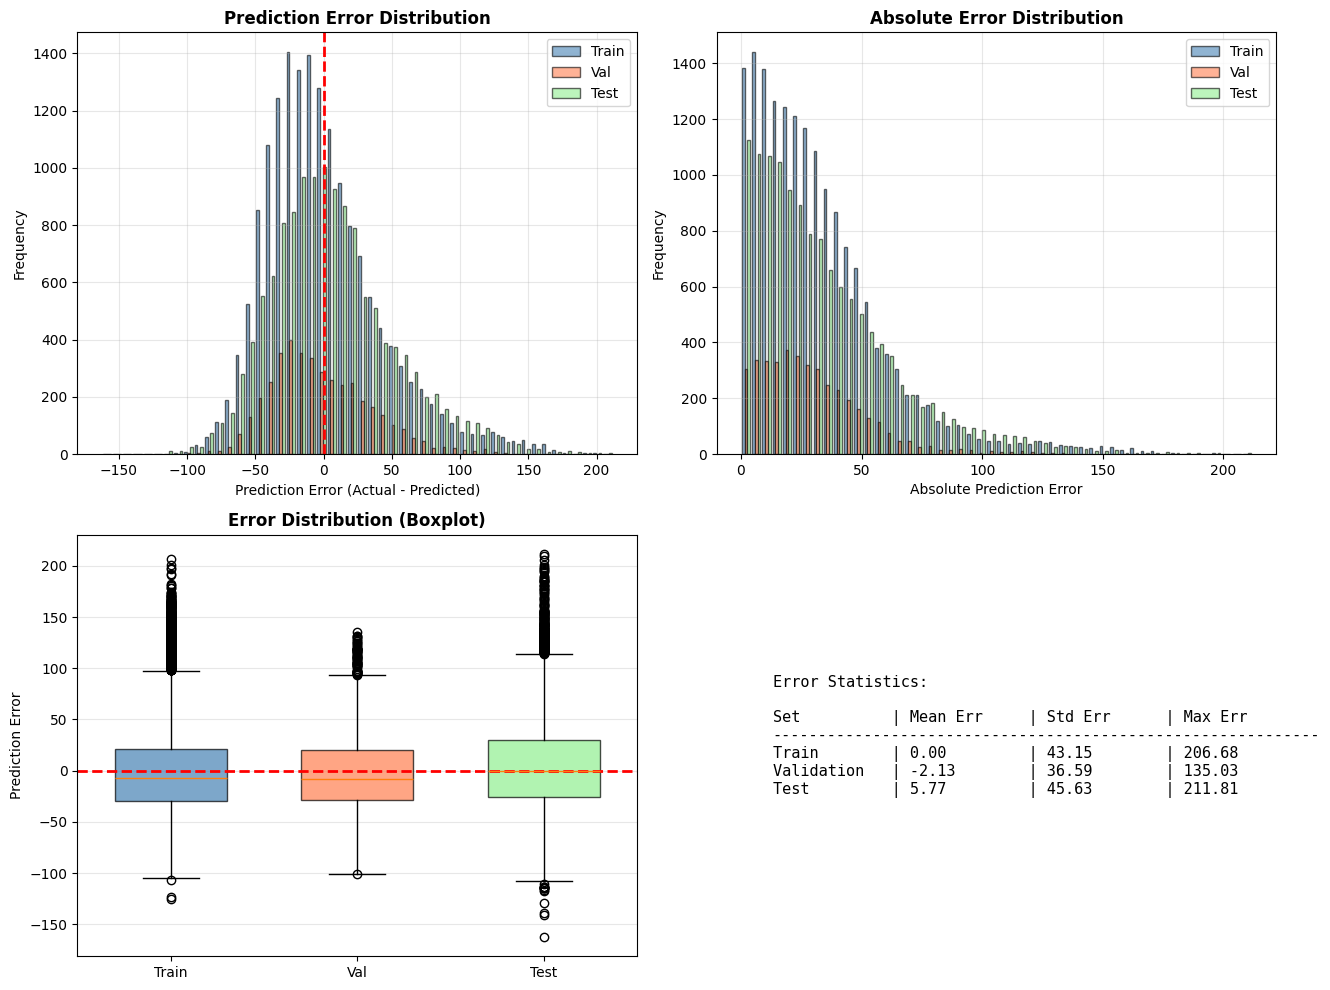


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | 0.00         | 43.15        | 206.68      
Validation   | -2.13        | 36.59        | 135.03      
Test         | 5.77         | 45.63        | 211.81      

Error distribution analysis complete


In [142]:
# 23c-viz3/ Ridge Regression - Error Distribution
print_header("Ridge Regression - Error Distribution")

# Calculate absolute errors
ridge_train_abs_errors = np.abs(ridge_train_residuals)
ridge_val_abs_errors = np.abs(ridge_val_residuals)
ridge_test_abs_errors = np.abs(ridge_test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([ridge_train_residuals, ridge_val_residuals, ridge_test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([ridge_train_abs_errors, ridge_val_abs_errors, ridge_test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [ridge_train_residuals, ridge_val_residuals, ridge_test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {ridge_train_residuals.mean():<12.2f} | {ridge_train_residuals.std():<12.2f} | {ridge_train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {ridge_val_residuals.mean():<12.2f} | {ridge_val_residuals.std():<12.2f} | {ridge_val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {ridge_test_residuals.mean():<12.2f} | {ridge_test_residuals.std():<12.2f} | {ridge_test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {ridge_train_residuals.mean():<12.2f} | {ridge_train_residuals.std():<12.2f} | {ridge_train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {ridge_val_residuals.mean():<12.2f} | {ridge_val_residuals.std():<12.2f} | {ridge_val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {ridge_test_residuals.mean():<12.2f} | {ridge_test_residuals.std():<12.2f} | {ridge_test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.4) XGBoost

In [143]:
# 24/ Model Training - XGBoost
print_header("Model Training - XGBoost")

# Initialize model
print("Initializing XGBoost model...")
xgb_model = xgb.XGBRegressor(
                                n_estimators=100,
                                max_depth=6,
                                learning_rate=0.1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=42,
                                n_jobs=-1
                            )

# Train model
print("Training model on train set...")
start_time = time.time()
xgb_model.fit(X_train, y_train, sample_weight=train_weights)
xgb_train_time = time.time() - start_time

# Make predictions on train set
print("Making predictions on train set...")
xgb_y_train_pred = xgb_model.predict(X_train)

# Make predictions on validation set
print("Making predictions on validation set...")
xgb_y_val_pred = xgb_model.predict(X_val)

# Make predictions on test set
print("Making predictions on test set...")
xgb_y_test_pred = xgb_model.predict(X_test)

# Calculate metrics for train set
xgb_train_rmse = rmse(y_train, xgb_y_train_pred)
xgb_train_mae = MAE(y_train, xgb_y_train_pred)
xgb_train_r2 = r2_score(y_train, xgb_y_train_pred)

# Calculate metrics for validation set
xgb_val_rmse = rmse(y_val, xgb_y_val_pred)
xgb_val_mae = MAE(y_val, xgb_y_val_pred)
xgb_val_r2 = r2_score(y_val, xgb_y_val_pred)

# Calculate metrics for test set
xgb_test_rmse = rmse(y_test, xgb_y_test_pred)
xgb_test_mae = MAE(y_test, xgb_y_test_pred)
xgb_test_r2 = r2_score(y_test, xgb_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("Model Type", "XGBoost"),
            ("n_estimators", 100),
            ("max_depth", 6),
            ("learning_rate", 0.1),
            ("subsample", 0.8),
            ("colsample_bytree", 0.8),
            ("Training time (seconds)", f"{xgb_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{xgb_train_rmse:.2f}"),
            ("MAE", f"{xgb_train_mae:.2f}"),
            ("R2 Score", f"{xgb_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{xgb_val_rmse:.2f}"),
            ("MAE", f"{xgb_val_mae:.2f}"),
            ("R2 Score", f"{xgb_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{xgb_test_rmse:.2f}"),
            ("MAE", f"{xgb_test_mae:.2f}"),
            ("R2 Score", f"{xgb_test_r2:.4f}"),
        ])

# Validation checks
assert xgb_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert xgb_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert xgb_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

# Store results for comparison
results_dict['XGBoost'] = {
                            'train_rmse': xgb_train_rmse,
                            'train_mae': xgb_train_mae,
                            'train_r2': xgb_train_r2,
                            'val_rmse': xgb_val_rmse,
                            'val_mae': xgb_val_mae,
                            'val_r2': xgb_val_r2,
                            'test_rmse': xgb_test_rmse,
                            'test_mae': xgb_test_mae,
                            'test_r2': xgb_test_r2,
                            'train_time': xgb_train_time
                        }

print_header("XGBoost training complete")


Model Training - XGBoost
Initializing XGBoost model...
Training model on train set...
Making predictions on train set...
Making predictions on validation set...
Making predictions on test set...

Model Parameters:
Model Type              : XGBoost
n_estimators            : 100
max_depth               : 6
learning_rate           : 0.1
subsample               : 0.8
colsample_bytree        : 0.8
Training time (seconds) : 0.91

Train Set Performance:
RMSE     : 12.90
MAE      : 9.25
R2 Score : 0.9657

Validation Set Performance:
RMSE     : 31.25
MAE      : 22.37
R2 Score : 0.7735

Test Set Performance:
RMSE     : 41.77
MAE      : 30.73
R2 Score : 0.4985

XGBoost training complete



XGBoost - Performance Visualization


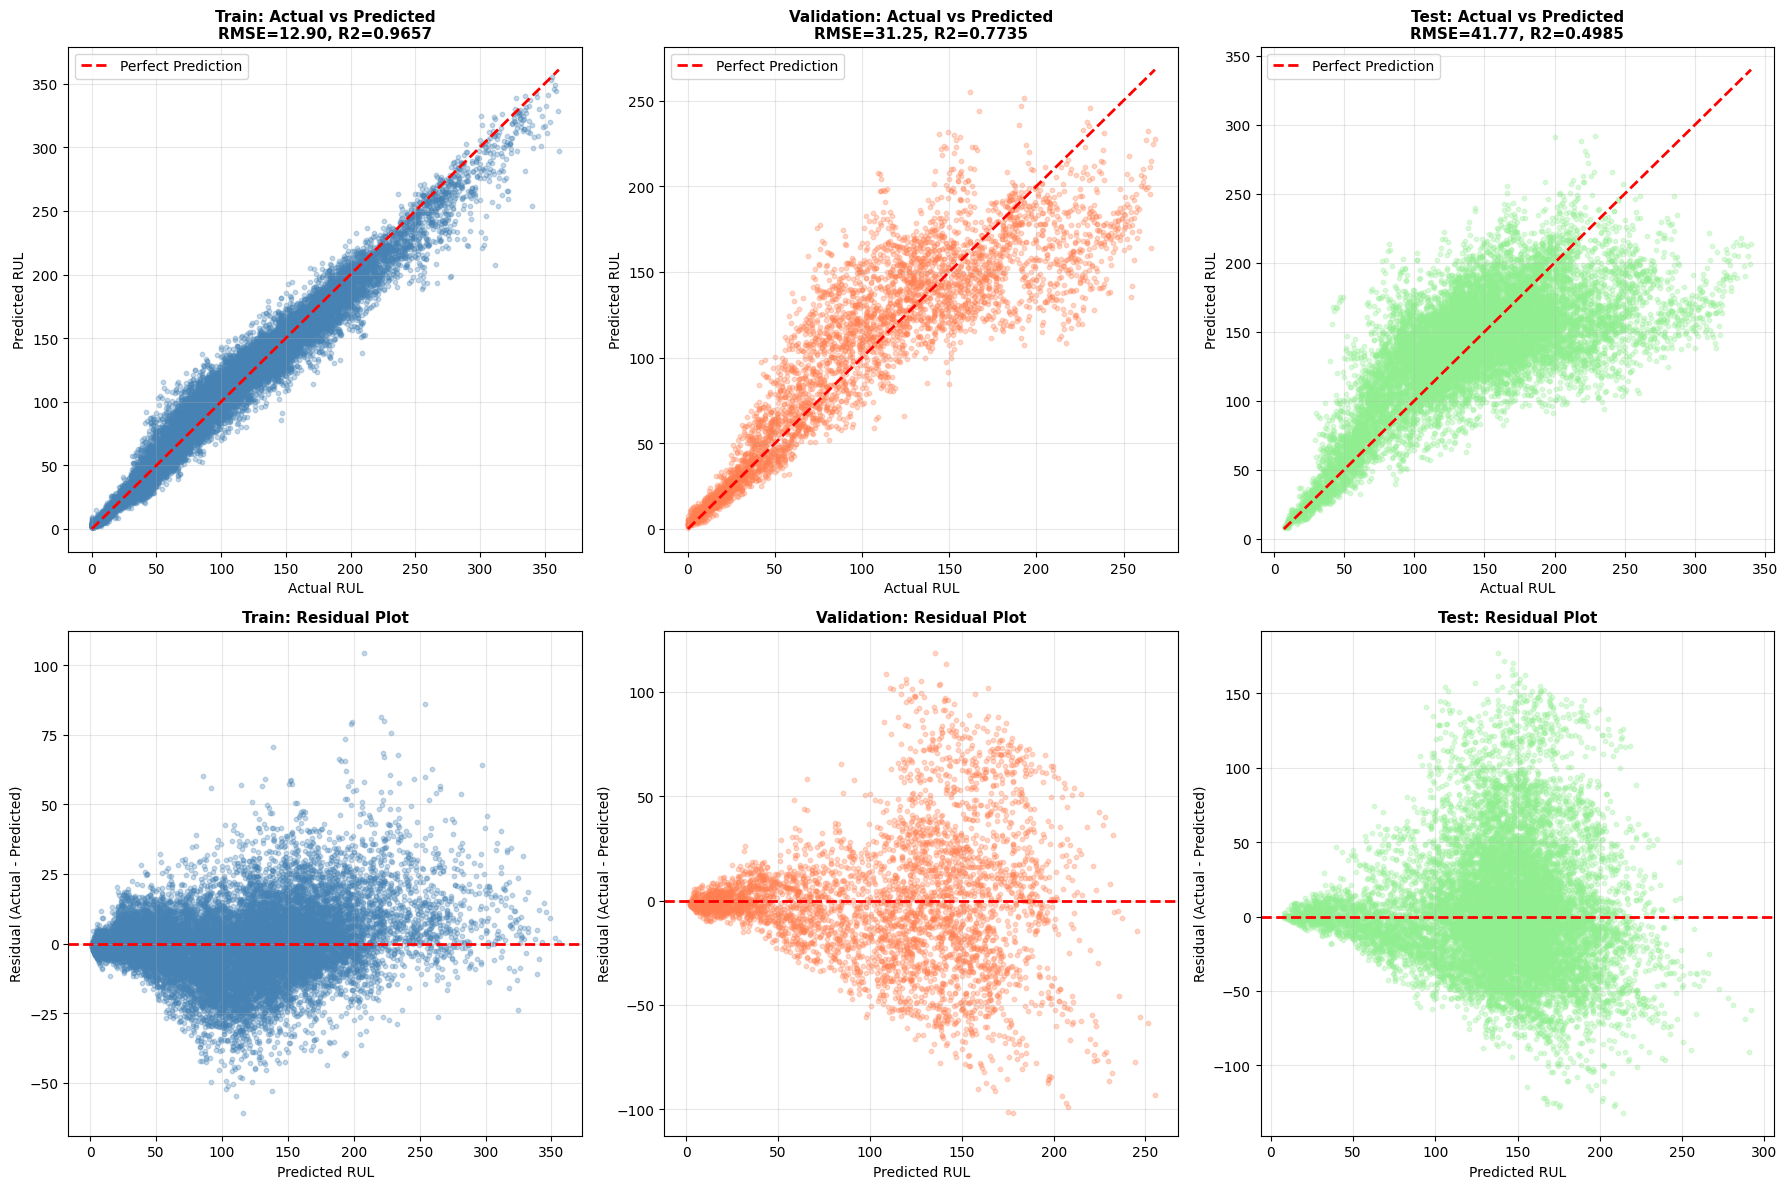


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 12.90           | 31.25           | 41.77          
MAE             | 9.25            | 22.37           | 30.73          
R2 Score        | 0.9657          | 0.7735          | 0.4985         

Visualization complete


In [144]:
# 24a-viz1/ XGBoost - Performance Visualization
print_header("XGBoost - Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, xgb_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={xgb_train_rmse:.2f}, R2={xgb_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, xgb_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={xgb_val_rmse:.2f}, R2={xgb_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, xgb_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={xgb_test_rmse:.2f}, R2={xgb_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
xgb_train_residuals = y_train - xgb_y_train_pred
axes[1, 0].scatter(xgb_y_train_pred, xgb_train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
xgb_val_residuals = y_val - xgb_y_val_pred
axes[1, 1].scatter(xgb_y_val_pred, xgb_val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
xgb_test_residuals = y_test - xgb_y_test_pred
axes[1, 2].scatter(xgb_y_test_pred, xgb_test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {xgb_train_rmse:<15.2f} | {xgb_val_rmse:<15.2f} | {xgb_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {xgb_train_mae:<15.2f} | {xgb_val_mae:<15.2f} | {xgb_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {xgb_train_r2:<15.4f} | {xgb_val_r2:<15.4f} | {xgb_test_r2:<15.4f}")

print("\nVisualization complete")


XGBoost - Feature Importance Analysis
Top 20 Most Important Features:
  LPT_Cool_Air_F_roll_min                  : 0.150731
  LPC_Outlet_Temp_roll_mean                : 0.127591
  HPC_Outlet_Static_Press                  : 0.088624
  HPC_Outlet_Static_Press_roll_slope       : 0.072969
  Bleed_Enthalpy_roll_max                  : 0.063299
  HPT_Cool_Air_F_roll_min                  : 0.053612
  HPC_Outlet_Temp_roll_max                 : 0.040717
  Physical_Core_Speed                      : 0.038924
  LPT_Outlet_Temp_roll_slope               : 0.031072
  Fuel_Flow_Ratio_roll_slope               : 0.026291
  HPT_Cool_Air_F_roll_slope                : 0.025902
  LPT_Outlet_Temp                          : 0.024712
  LPC_Outlet_Temp_roll_max                 : 0.018915
  HPC_Outlet_Press_roll_slope              : 0.016154
  HPC_Outlet_Temp_roll_slope               : 0.014227
  LPT_Cool_Air_F_roll_slope                : 0.014075
  Corrected_Core_Speed_roll_std            : 0.012316
  Physical_

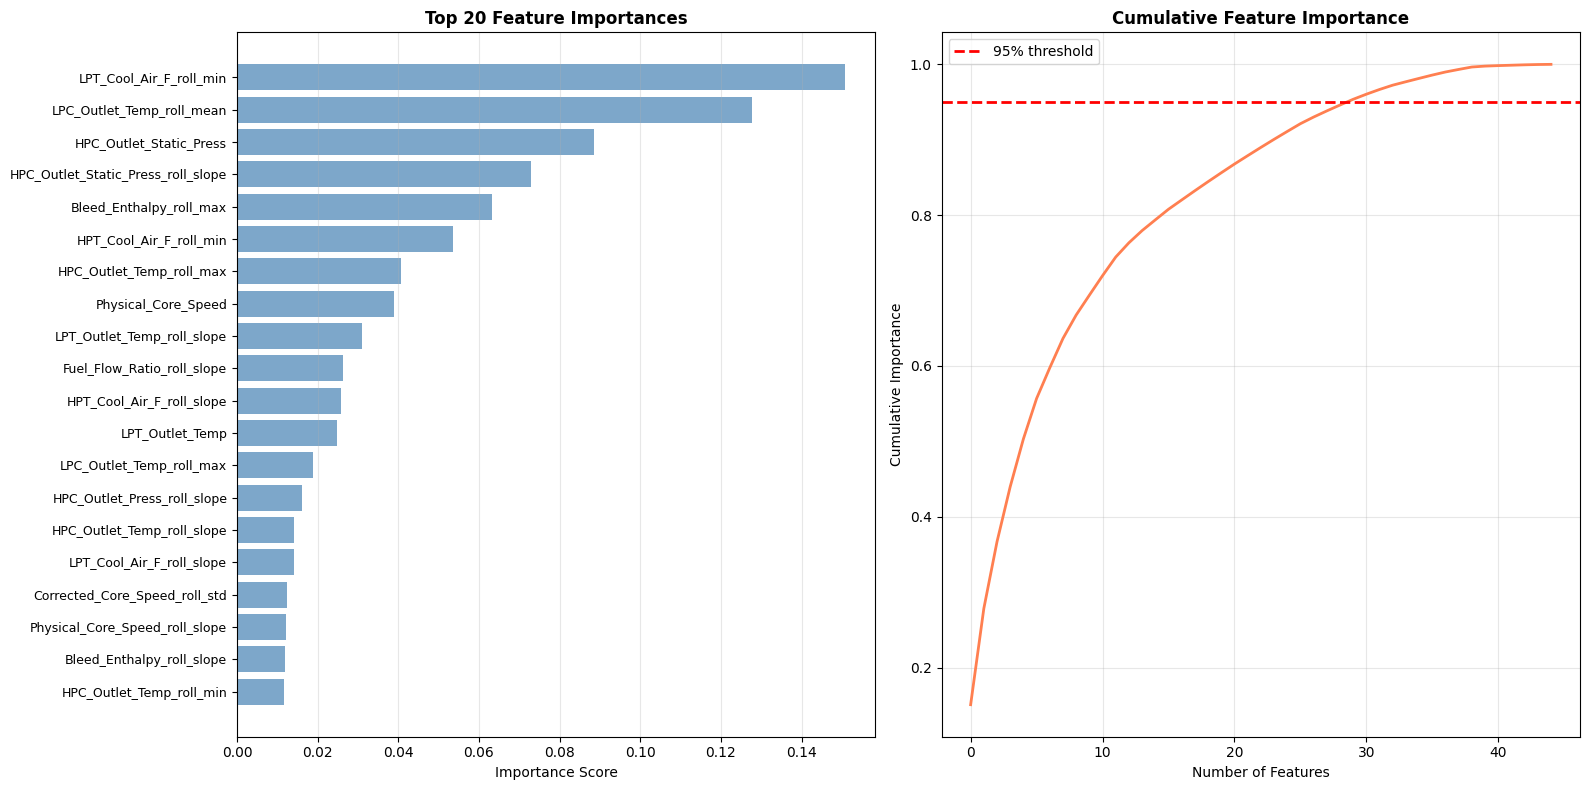


Features needed for 95% importance: 30 out of 45

Feature importance analysis complete


In [145]:
# 24b-viz2/ XGBoost - Feature Importance Analysis
print_header("XGBoost - Feature Importance Analysis")

# Get feature importances from the model
xgb_feature_importances = xgb_model.feature_importances_

# Create dataframe for better handling
xgb_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_feature_importances
})

# Sort by importance
xgb_importance_df = xgb_importance_df.sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
for i, row in xgb_importance_df.head(20).iterrows():
    print(f"  {row['feature']:<40} : {row['importance']:.6f}")

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - top 20
top_20 = xgb_importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Cumulative importance
cumsum = xgb_importance_df['importance'].cumsum()
axes[1].plot(range(len(cumsum)), cumsum.values, color='coral', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate how many features needed for 95% importance
features_for_95 = (cumsum <= 0.95).sum() + 1
print(f"\nFeatures needed for 95% importance: {features_for_95} out of {len(feature_names)}")

print("\nFeature importance analysis complete")


XGBoost - Error Distribution


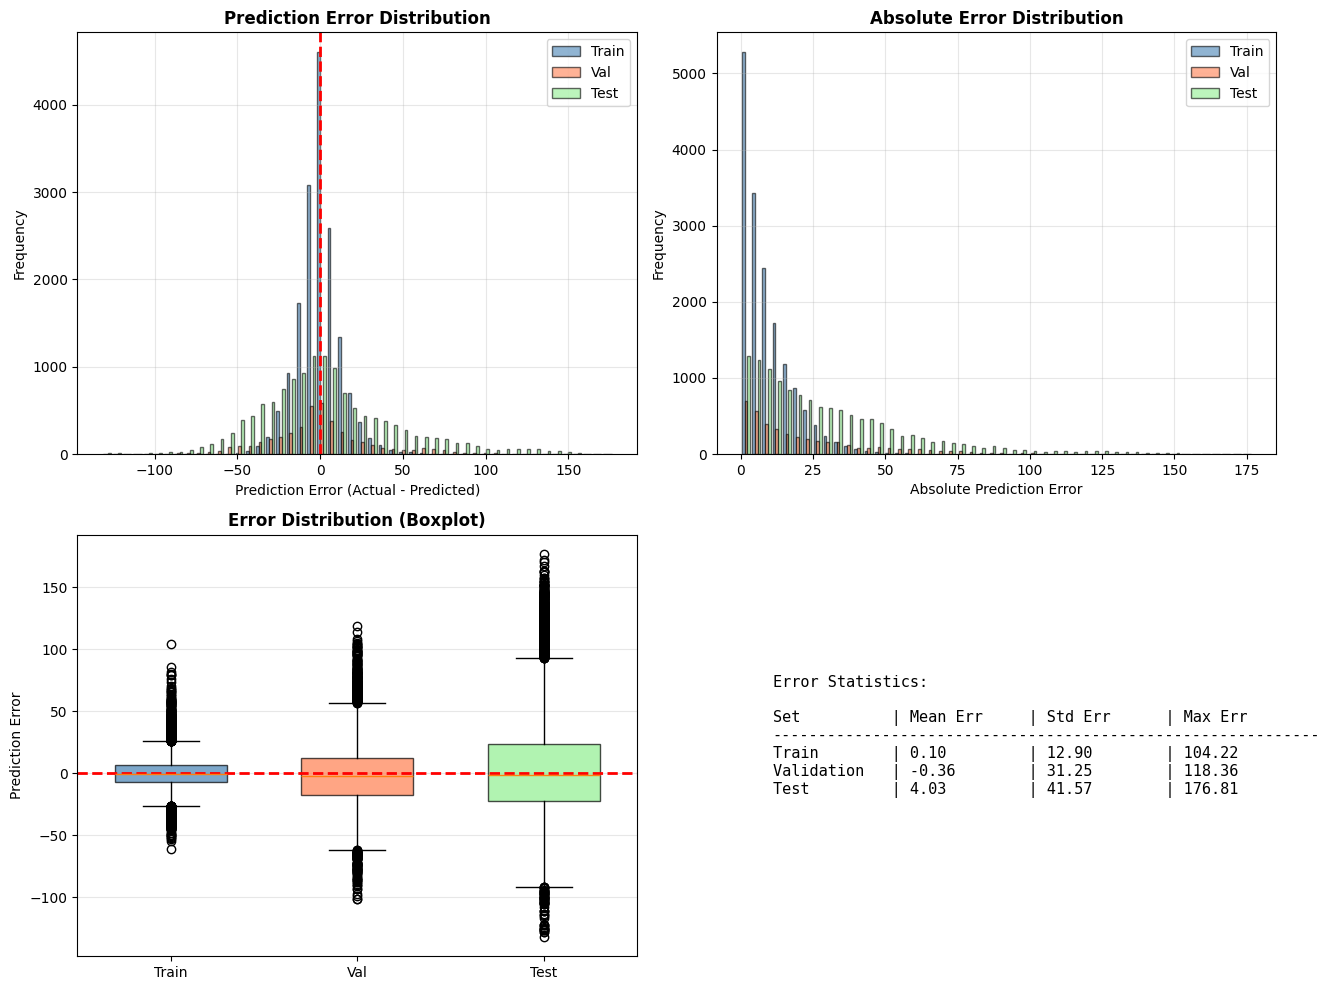


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | 0.10         | 12.90        | 104.22      
Validation   | -0.36        | 31.25        | 118.36      
Test         | 4.03         | 41.57        | 176.81      

Error distribution analysis complete


In [146]:
# 24c-viz3/ XGBoost - Error Distribution
print_header("XGBoost - Error Distribution")

# Calculate absolute errors
xgb_train_abs_errors = np.abs(xgb_train_residuals)
xgb_val_abs_errors = np.abs(xgb_val_residuals)
xgb_test_abs_errors = np.abs(xgb_test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([xgb_train_residuals, xgb_val_residuals, xgb_test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([xgb_train_abs_errors, xgb_val_abs_errors, xgb_test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [xgb_train_residuals, xgb_val_residuals, xgb_test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {xgb_train_residuals.mean():<12.2f} | {xgb_train_residuals.std():<12.2f} | {xgb_train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {xgb_val_residuals.mean():<12.2f} | {xgb_val_residuals.std():<12.2f} | {xgb_val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {xgb_test_residuals.mean():<12.2f} | {xgb_test_residuals.std():<12.2f} | {xgb_test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {xgb_train_residuals.mean():<12.2f} | {xgb_train_residuals.std():<12.2f} | {xgb_train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {xgb_val_residuals.mean():<12.2f} | {xgb_val_residuals.std():<12.2f} | {xgb_val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {xgb_test_residuals.mean():<12.2f} | {xgb_test_residuals.std():<12.2f} | {xgb_test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.5) LightGBM

In [147]:
# 25/ Model Training - LightGBM
print_header("Model Training - LightGBM")

# Initialize model
print("Initializing LightGBM model...")
lgbm_model = lgb.LGBMRegressor(
                                n_estimators=100,
                                max_depth=6,
                                learning_rate=0.1,
                                subsample=0.8,
                                colsample_bytree=0.8,
                                random_state=42,
                                n_jobs=-1,
                                verbose=-1
                            )

# Train model
print("Training model on train set...")
start_time = time.time()
lgbm_model.fit(X_train, y_train, sample_weight=train_weights)
lgbm_train_time = time.time() - start_time

# Make predictions on train set
print("Making predictions on train set...")
lgbm_y_train_pred = lgbm_model.predict(X_train)

# Make predictions on validation set
print("Making predictions on validation set...")
lgbm_y_val_pred = lgbm_model.predict(X_val)

# Make predictions on test set
print("Making predictions on test set...")
lgbm_y_test_pred = lgbm_model.predict(X_test)

# Calculate metrics for train set
lgbm_train_rmse = rmse(y_train, lgbm_y_train_pred)
lgbm_train_mae = MAE(y_train, lgbm_y_train_pred)
lgbm_train_r2 = r2_score(y_train, lgbm_y_train_pred)

# Calculate metrics for validation set
lgbm_val_rmse = rmse(y_val, lgbm_y_val_pred)
lgbm_val_mae = MAE(y_val, lgbm_y_val_pred)
lgbm_val_r2 = r2_score(y_val, lgbm_y_val_pred)

# Calculate metrics for test set
lgbm_test_rmse = rmse(y_test, lgbm_y_test_pred)
lgbm_test_mae = MAE(y_test, lgbm_y_test_pred)
lgbm_test_r2 = r2_score(y_test, lgbm_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("Model Type", "LightGBM"),
            ("n_estimators", 100),
            ("max_depth", 6),
            ("learning_rate", 0.1),
            ("subsample", 0.8),
            ("colsample_bytree", 0.8),
            ("Training time (seconds)", f"{lgbm_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{lgbm_train_rmse:.2f}"),
            ("MAE", f"{lgbm_train_mae:.2f}"),
            ("R2 Score", f"{lgbm_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{lgbm_val_rmse:.2f}"),
            ("MAE", f"{lgbm_val_mae:.2f}"),
            ("R2 Score", f"{lgbm_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{lgbm_test_rmse:.2f}"),
            ("MAE", f"{lgbm_test_mae:.2f}"),
            ("R2 Score", f"{lgbm_test_r2:.4f}"),
        ])

# Validation checks
assert lgbm_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert lgbm_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert lgbm_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

# Store results for comparison
results_dict['LightGBM'] = {
                                'train_rmse': lgbm_train_rmse,
                                'train_mae': lgbm_train_mae,
                                'train_r2': lgbm_train_r2,
                                'val_rmse': lgbm_val_rmse,
                                'val_mae': lgbm_val_mae,
                                'val_r2': lgbm_val_r2,
                                'test_rmse': lgbm_test_rmse,
                                'test_mae': lgbm_test_mae,
                                'test_r2': lgbm_test_r2,
                                'train_time': lgbm_train_time
                            }

print("\nLightGBM training complete")


Model Training - LightGBM
Initializing LightGBM model...
Training model on train set...
Making predictions on train set...
Making predictions on validation set...
Making predictions on test set...

Model Parameters:
Model Type              : LightGBM
n_estimators            : 100
max_depth               : 6
learning_rate           : 0.1
subsample               : 0.8
colsample_bytree        : 0.8
Training time (seconds) : 0.85

Train Set Performance:
RMSE     : 15.47
MAE      : 11.21
R2 Score : 0.9507

Validation Set Performance:
RMSE     : 30.59
MAE      : 21.97
R2 Score : 0.7828

Test Set Performance:
RMSE     : 41.63
MAE      : 30.69
R2 Score : 0.5018

LightGBM training complete



LightGBM - Performance Visualization


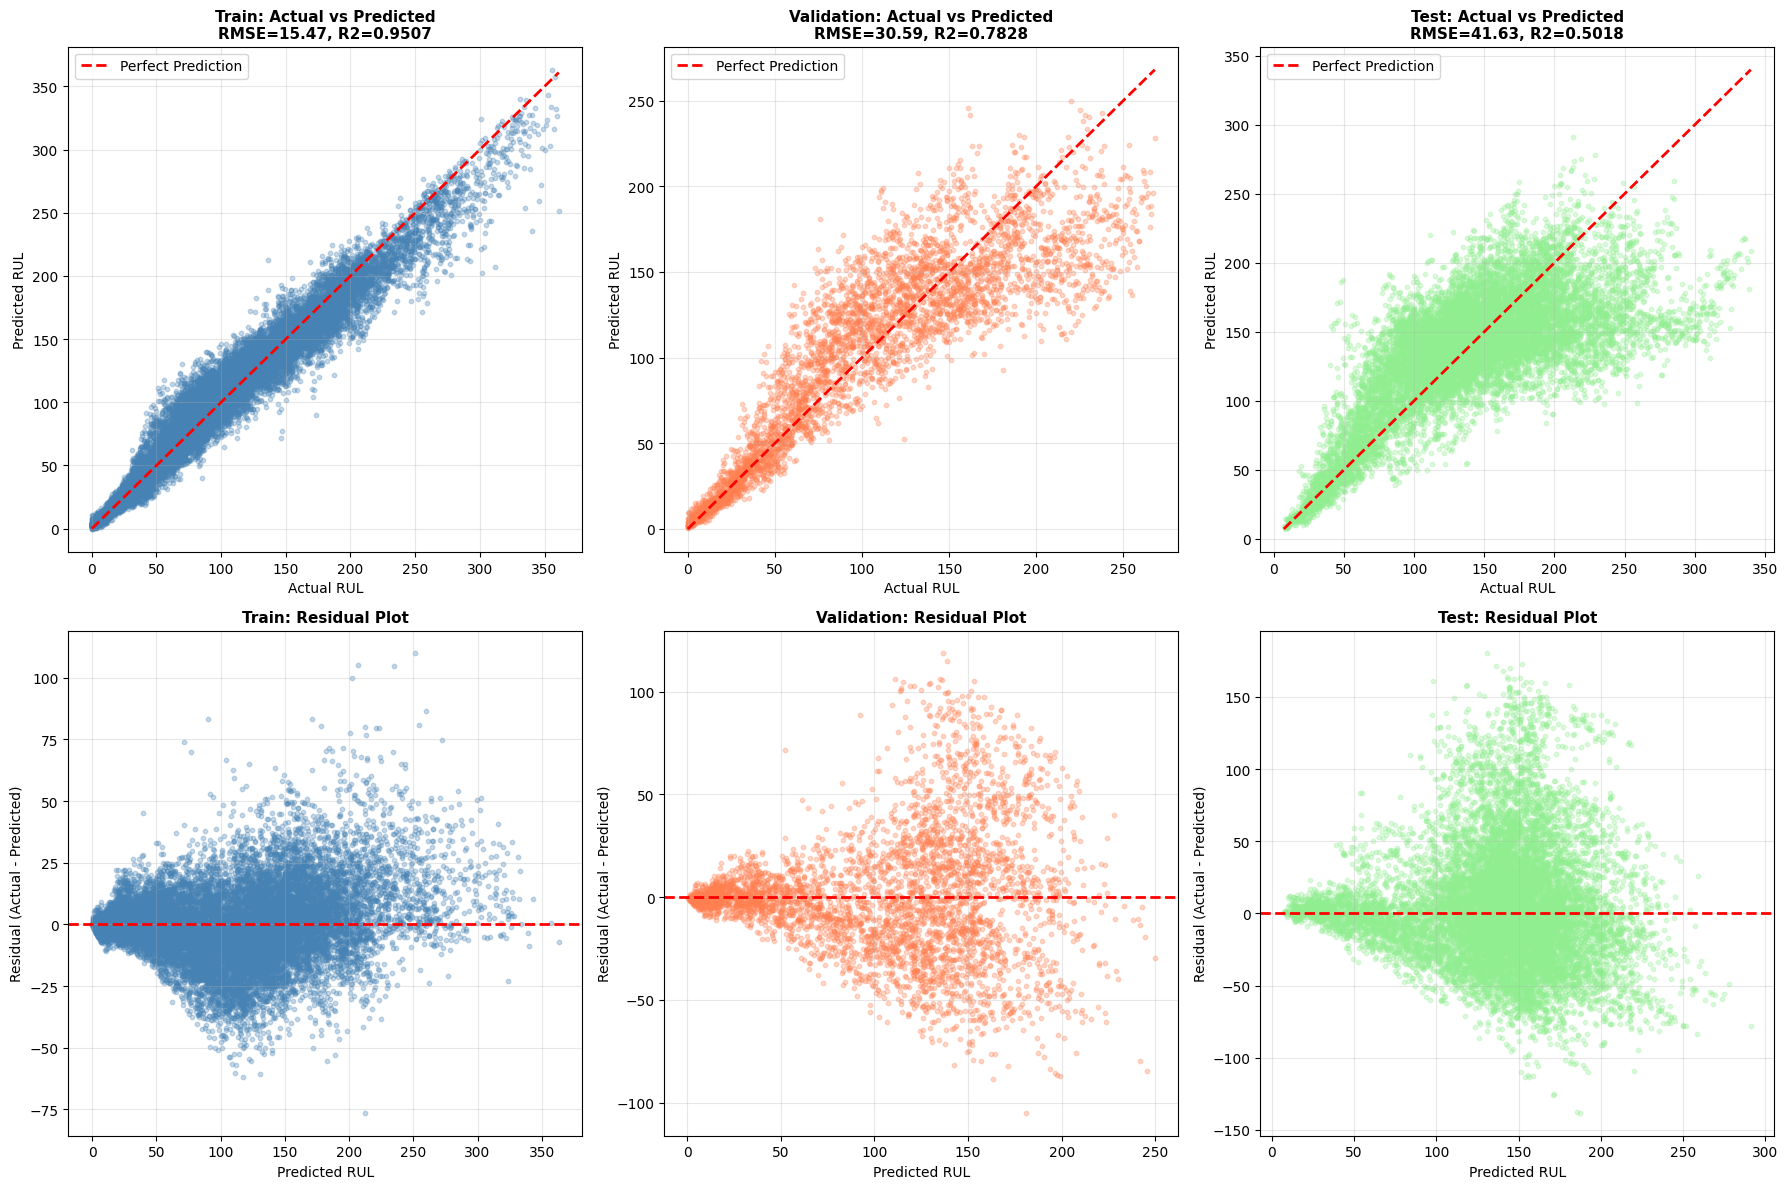


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 15.47           | 30.59           | 41.63          
MAE             | 11.21           | 21.97           | 30.69          
R2 Score        | 0.9507          | 0.7828          | 0.5018         

Visualization complete


In [148]:
# 25a-viz1/ LightGBM - Performance Visualization
print_header("LightGBM - Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, lgbm_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={lgbm_train_rmse:.2f}, R2={lgbm_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, lgbm_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={lgbm_val_rmse:.2f}, R2={lgbm_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, lgbm_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={lgbm_test_rmse:.2f}, R2={lgbm_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
lgbm_train_residuals = y_train - lgbm_y_train_pred
axes[1, 0].scatter(lgbm_y_train_pred, lgbm_train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
lgbm_val_residuals = y_val - lgbm_y_val_pred
axes[1, 1].scatter(lgbm_y_val_pred, lgbm_val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
lgbm_test_residuals = y_test - lgbm_y_test_pred
axes[1, 2].scatter(lgbm_y_test_pred, lgbm_test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {lgbm_train_rmse:<15.2f} | {lgbm_val_rmse:<15.2f} | {lgbm_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {lgbm_train_mae:<15.2f} | {lgbm_val_mae:<15.2f} | {lgbm_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {lgbm_train_r2:<15.4f} | {lgbm_val_r2:<15.4f} | {lgbm_test_r2:<15.4f}")

print("\nVisualization complete")


LightGBM - Feature Importance Analysis
Top 20 Most Important Features:
  LPT_Cool_Air_F_roll_min                  : 196.000000
  LPT_Outlet_Temp_roll_min                 : 167.000000
  HPC_Outlet_Temp_roll_max                 : 164.000000
  HPC_Outlet_Temp_roll_min                 : 157.000000
  LPC_Outlet_Temp_roll_max                 : 151.000000
  LPT_Cool_Air_F_roll_max                  : 149.000000
  LPC_Outlet_Temp_roll_min                 : 140.000000
  HPC_Outlet_Press_roll_max                : 137.000000
  HPT_Cool_Air_F_roll_max                  : 118.000000
  HPT_Cool_Air_F_roll_min                  : 106.000000
  LPC_Outlet_Temp_roll_mean                : 102.000000
  Corrected_Core_Speed_roll_std            : 84.000000
  Physical_Core_Speed_roll_std             : 79.000000
  LPT_Outlet_Temp_roll_slope               : 73.000000
  Fuel_Flow_Ratio_roll_slope               : 70.000000
  HPC_Outlet_Static_Press_roll_slope       : 67.000000
  Physical_Core_Speed                

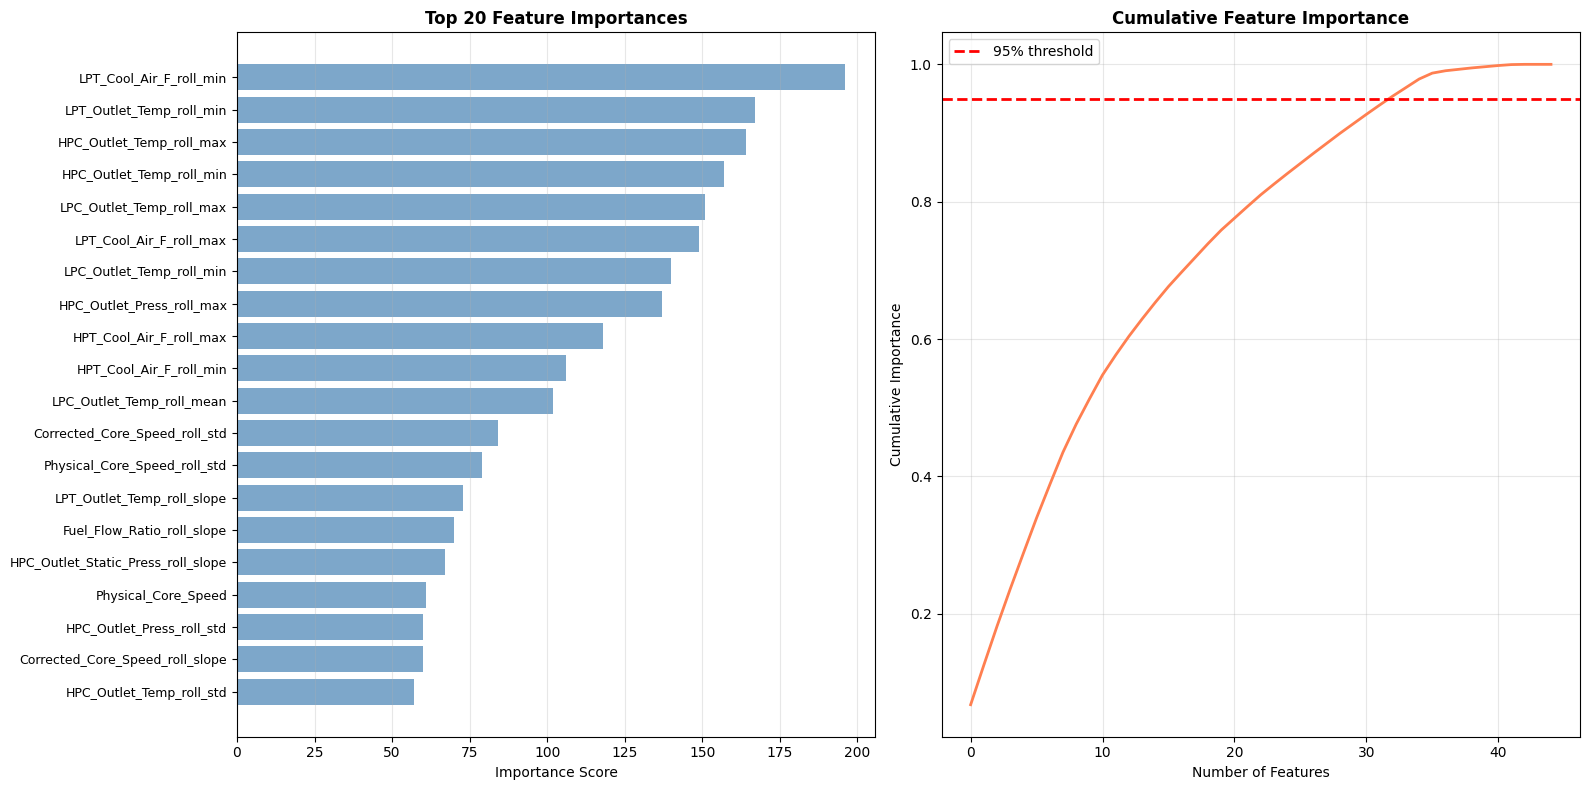


Features needed for 95% importance: 33 out of 45

Feature importance analysis complete


In [149]:
# 25b-viz2/ LightGBM - Feature Importance Analysis
print_header("LightGBM - Feature Importance Analysis")

# Get feature importances from the model
lgbm_feature_importances = lgbm_model.feature_importances_

# Create dataframe for better handling
lgbm_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': lgbm_feature_importances
})

# Sort by importance
lgbm_importance_df = lgbm_importance_df.sort_values('importance', ascending=False)

# Display top 20 features
print("Top 20 Most Important Features:")
for i, row in lgbm_importance_df.head(20).iterrows():
    print(f"  {row['feature']:<40} : {row['importance']:.6f}")

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot - top 20
top_20 = lgbm_importance_df.head(20)
axes[0].barh(range(len(top_20)), top_20['importance'].values, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_20)))
axes[0].set_yticklabels(top_20['feature'].values, fontsize=9)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 20 Feature Importances', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Cumulative importance
cumsum = lgbm_importance_df['importance'].cumsum()
total_importance = lgbm_importance_df['importance'].sum()
cumsum_normalized = cumsum / total_importance
axes[1].plot(range(len(cumsum_normalized)), cumsum_normalized.values, color='coral', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
axes[1].set_xlabel('Number of Features')
axes[1].set_ylabel('Cumulative Importance')
axes[1].set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate how many features needed for 95% importance
features_for_95 = (cumsum_normalized <= 0.95).sum() + 1
print(f"\nFeatures needed for 95% importance: {features_for_95} out of {len(feature_names)}")

print("\nFeature importance analysis complete")


LightGBM - Error Distribution


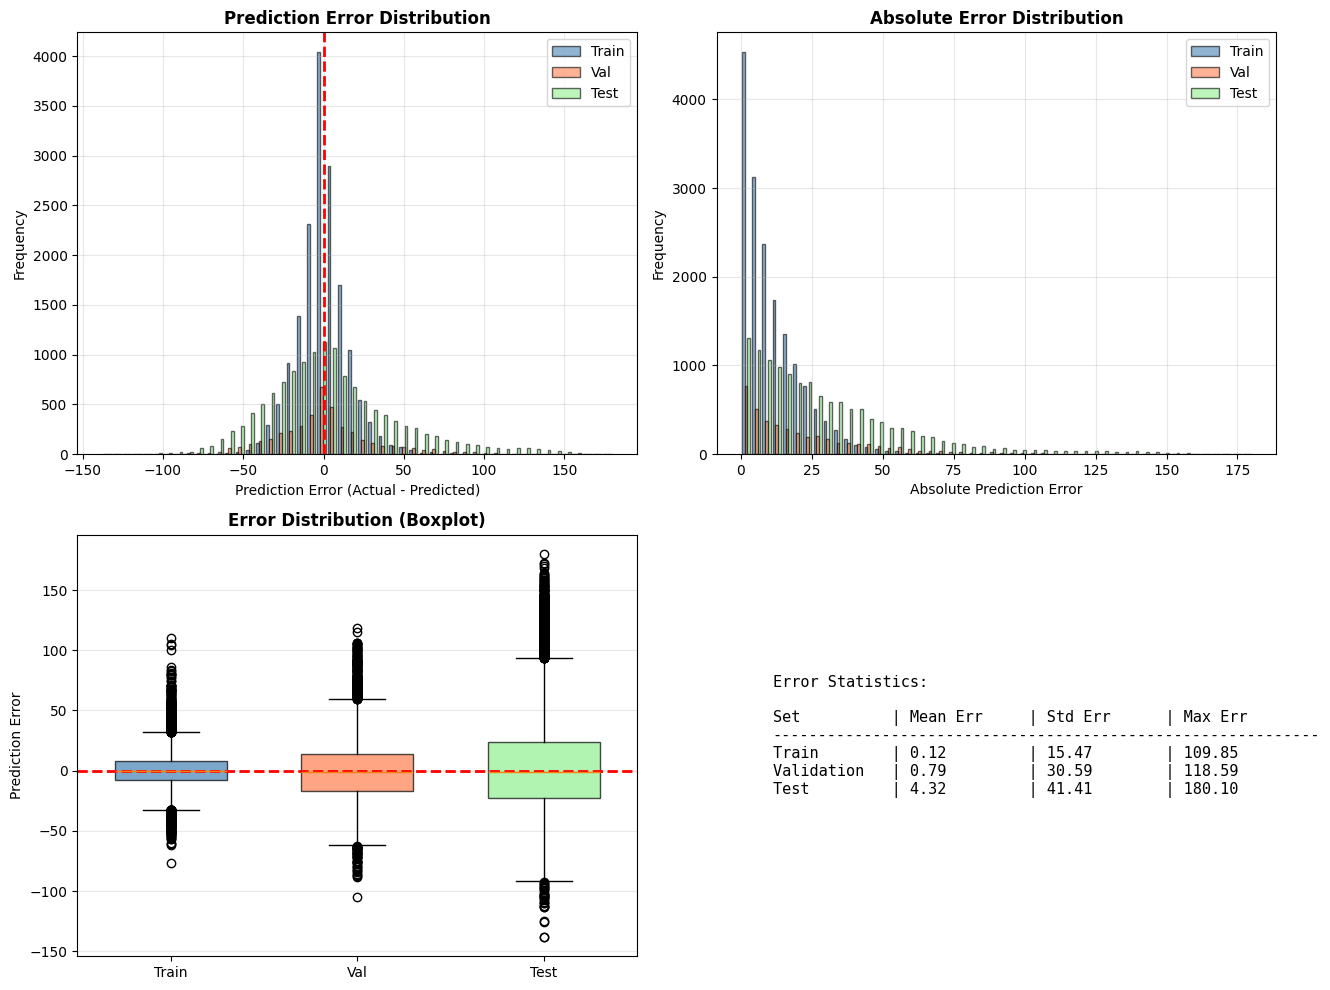


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | 0.12         | 15.47        | 109.85      
Validation   | 0.79         | 30.59        | 118.59      
Test         | 4.32         | 41.41        | 180.10      

Error distribution analysis complete


In [150]:
# 25c-viz3/ LightGBM - Error Distribution
print_header("LightGBM - Error Distribution")

# Calculate absolute errors
lgbm_train_abs_errors = np.abs(lgbm_train_residuals)
lgbm_val_abs_errors = np.abs(lgbm_val_residuals)
lgbm_test_abs_errors = np.abs(lgbm_test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([lgbm_train_residuals, lgbm_val_residuals, lgbm_test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([lgbm_train_abs_errors, lgbm_val_abs_errors, lgbm_test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [lgbm_train_residuals, lgbm_val_residuals, lgbm_test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {lgbm_train_residuals.mean():<12.2f} | {lgbm_train_residuals.std():<12.2f} | {lgbm_train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {lgbm_val_residuals.mean():<12.2f} | {lgbm_val_residuals.std():<12.2f} | {lgbm_val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {lgbm_test_residuals.mean():<12.2f} | {lgbm_test_residuals.std():<12.2f} | {lgbm_test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {lgbm_train_residuals.mean():<12.2f} | {lgbm_train_residuals.std():<12.2f} | {lgbm_train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {lgbm_val_residuals.mean():<12.2f} | {lgbm_val_residuals.std():<12.2f} | {lgbm_val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {lgbm_test_residuals.mean():<12.2f} | {lgbm_test_residuals.std():<12.2f} | {lgbm_test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.6) LSTM

In [151]:
# 26/ Model Training - LSTM 
print_header("Model Training - LSTM")

# Reshape data for LSTM (samples, timesteps, features)
# LSTM expects 3D input: (batch_size, timesteps, features) -> treat each sample as a sequence of length 1
print("Reshaping data for LSTM input...")
X_train_lstm = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_lstm = X_val.values.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_lstm = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

print(f"Reshaped train data: {X_train_lstm.shape}")
print(f"Reshaped val data: {X_val_lstm.shape}")
print(f"Reshaped test data: {X_test_lstm.shape}")

# Build LSTM model
print("\nBuilding LSTM model...")
lstm_model = keras.Sequential([
                                layers.LSTM(64, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True),
                                layers.Dropout(0.2),
                                layers.LSTM(32, activation='relu'),
                                layers.Dropout(0.2),
                                layers.Dense(16, activation='relu'),
                                layers.Dense(1)
                            ])

# Compile model
print("Compiling model...")
lstm_model.compile(
                    optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    loss='mse',
                    metrics=['mae']
                )

# Display model architecture
print("\nModel Architecture:")
lstm_model.summary()

# Train model
print("\nTraining model...")
start_time = time.time()

history = lstm_model.fit(
                            X_train_lstm, y_train,
                            validation_data=(X_val_lstm, y_val),
                            epochs=50,
                            batch_size=32,
                            verbose=1,
                            sample_weight=train_weights
                        )

lstm_train_time = time.time() - start_time

# Make predictions on train set
print("\nMaking predictions on train set...")
lstm_y_train_pred = lstm_model.predict(X_train_lstm, verbose=0)
lstm_y_train_pred = lstm_y_train_pred.flatten()

# Make predictions on validation set
print("Making predictions on validation set...")
lstm_y_val_pred = lstm_model.predict(X_val_lstm, verbose=0)
lstm_y_val_pred = lstm_y_val_pred.flatten()

# Make predictions on test set
print("Making predictions on test set...")
lstm_y_test_pred = lstm_model.predict(X_test_lstm, verbose=0)
lstm_y_test_pred = lstm_y_test_pred.flatten()

# Calculate metrics for train set
lstm_train_rmse = rmse(y_train, lstm_y_train_pred)
lstm_train_mae = MAE(y_train, lstm_y_train_pred)
lstm_train_r2 = r2_score(y_train, lstm_y_train_pred)

# Calculate metrics for validation set
lstm_val_rmse = rmse(y_val, lstm_y_val_pred)
lstm_val_mae = MAE(y_val, lstm_y_val_pred)
lstm_val_r2 = r2_score(y_val, lstm_y_val_pred)

# Calculate metrics for test set
lstm_test_rmse = rmse(y_test, lstm_y_test_pred)
lstm_test_mae = MAE(y_test, lstm_y_test_pred)
lstm_test_r2 = r2_score(y_test, lstm_y_test_pred)

# Display results
print("\nModel Parameters:")
print_kv([
            ("Model Type", "LSTM"),
            ("LSTM layers", "64 -> 32"),
            ("Dense layers", "16 -> 1"),
            ("Dropout rate", 0.2),
            ("Epochs", 50),
            ("Batch size", 32),
            ("Learning rate", 0.001),
            ("Training time (seconds)", f"{lstm_train_time:.2f}"),
        ])

print("\nTrain Set Performance:")
print_kv([
            ("RMSE", f"{lstm_train_rmse:.2f}"),
            ("MAE", f"{lstm_train_mae:.2f}"),
            ("R2 Score", f"{lstm_train_r2:.4f}"),
        ])

print("\nValidation Set Performance:")
print_kv([
            ("RMSE", f"{lstm_val_rmse:.2f}"),
            ("MAE", f"{lstm_val_mae:.2f}"),
            ("R2 Score", f"{lstm_val_r2:.4f}"),
        ])

print("\nTest Set Performance:")
print_kv([
            ("RMSE", f"{lstm_test_rmse:.2f}"),
            ("MAE", f"{lstm_test_mae:.2f}"),
            ("R2 Score", f"{lstm_test_r2:.4f}"),
        ])

# Validation checks
assert lstm_y_train_pred.shape[0] == len(y_train), "Train prediction count mismatch"
assert lstm_y_val_pred.shape[0] == len(y_val), "Val prediction count mismatch"
assert lstm_y_test_pred.shape[0] == len(y_test), "Test prediction count mismatch"

# Store results for comparison
results_dict['LSTM'] = {
                            'train_rmse': lstm_train_rmse,
                            'train_mae': lstm_train_mae,
                            'train_r2': lstm_train_r2,
                            'val_rmse': lstm_val_rmse,
                            'val_mae': lstm_val_mae,
                            'val_r2': lstm_val_r2,
                            'test_rmse': lstm_test_rmse,
                            'test_mae': lstm_test_mae,
                            'test_r2': lstm_test_r2,
                            'train_time': lstm_train_time
                        }

print("\nLSTM training complete")


Model Training - LSTM
Reshaping data for LSTM input...
Reshaped train data: (16561, 1, 45)
Reshaped val data: (4070, 1, 45)
Reshaped test data: (13096, 1, 45)

Building LSTM model...
Compiling model...

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        28,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,121 (160.63 KB)

 Trainable params: 41,121 (160.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model...
Epoch 1/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 4919.9858 - mae: 49.2046 - val_loss: 1758.9843 - val_mae: 29.7418
Epoch 2/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2504.2437 - mae: 35.4735 - val_loss: 1524.0300 - val_mae: 27.4960
Epoch 3/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2240.0601 - mae: 33.4458 - val_loss: 1392.0964 - val_mae: 26.5960
Epoch 4/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2116.1858 - mae: 32.5076 - val_loss: 1299.7382 - val_mae: 26.7154
Epoch 5/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2010.7380 - mae: 31.6941 - val_loss: 1247.9913 - val_mae: 25.6982
Epoch 6/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2008.7263 - mae: 31.5714 - val_loss: 1258.1982 - val_mae: 26.1884
Epoch 7/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1948.3774 - mae: 31.0902 - val_loss: 1227.0986 - val_mae: 25.8066
Epoch 8/50
518/518 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1936.9399 - mae: 31.1164 - val_loss: 12


LSTM - Training History


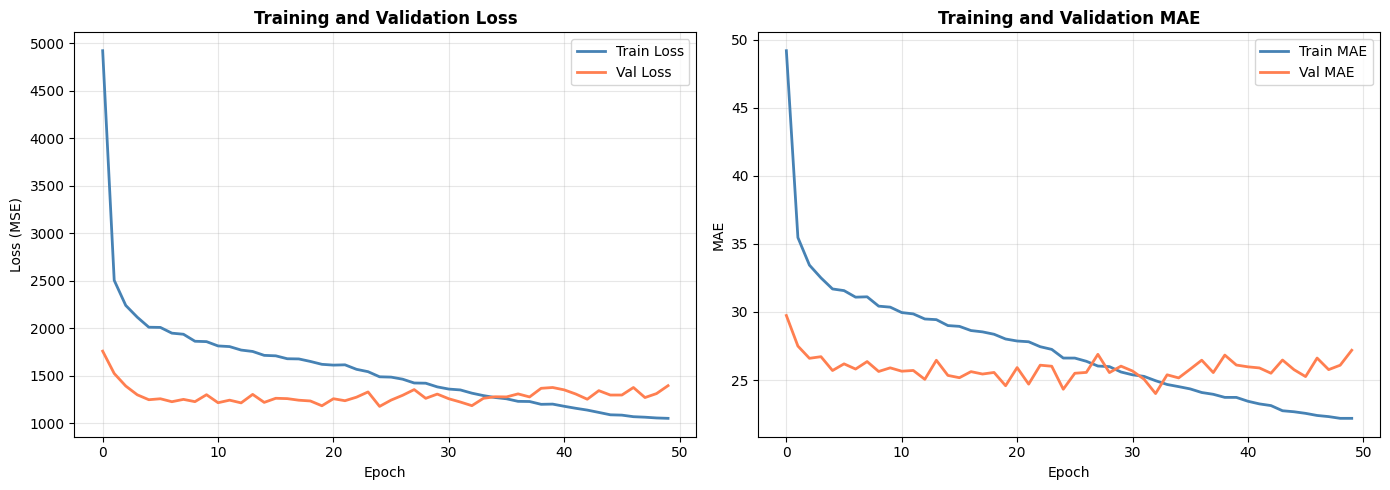


Training Summary:
Final train loss      : 1052.1378
Final val loss        : 1395.9138
Final train MAE       : 22.18
Final val MAE         : 27.19
Best epoch (val_loss) : 25
Best val loss         : 1177.8768

Training history visualization complete


In [152]:
# 26a-viz1/ LSTM - Training History
print_header("LSTM - Training History")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training loss
axes[0].plot(history.history['loss'], label='Train Loss', color='steelblue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', color='coral', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot training MAE
axes[1].plot(history.history['mae'], label='Train MAE', color='steelblue', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', color='coral', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Training and Validation MAE', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
print("\nTraining Summary:")
print_kv([
            ("Final train loss", f"{history.history['loss'][-1]:.4f}"),
            ("Final val loss", f"{history.history['val_loss'][-1]:.4f}"),
            ("Final train MAE", f"{history.history['mae'][-1]:.2f}"),
            ("Final val MAE", f"{history.history['val_mae'][-1]:.2f}"),
            ("Best epoch (val_loss)", int(np.argmin(history.history['val_loss']) + 1)),
            ("Best val loss", f"{np.min(history.history['val_loss']):.4f}"),
        ])

print("\nTraining history visualization complete")


LSTM - Performance Visualization


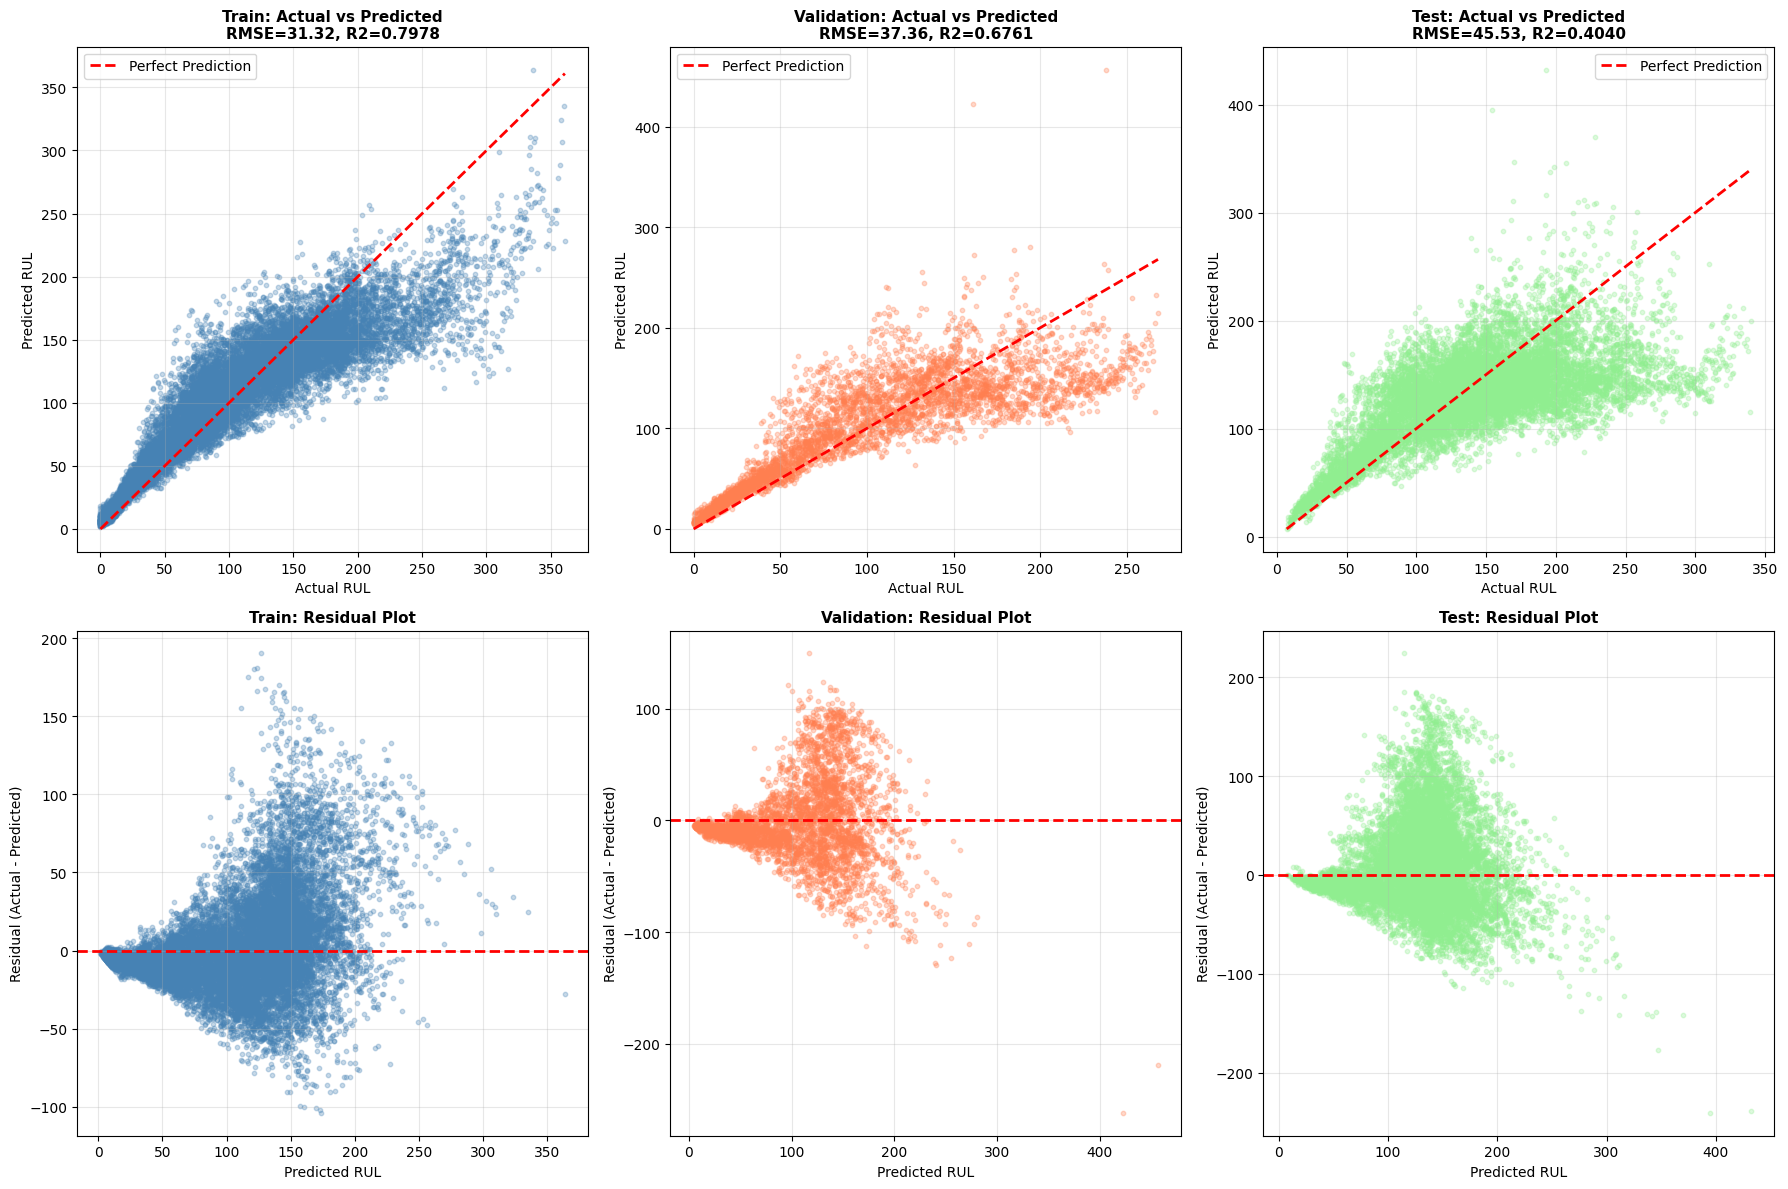


Performance Comparison:
Metric          | Train           | Validation      | Test           
----------------------------------------------------------------------
RMSE            | 31.32           | 37.36           | 45.53          
MAE             | 21.90           | 27.19           | 33.69          
R2 Score        | 0.7978          | 0.6761          | 0.4040         

Visualization complete


In [153]:
# 26b-viz2/ LSTM - Performance Visualization
print_header("LSTM - Performance Visualization")

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Train: Actual vs Predicted (scatter)
axes[0, 0].scatter(y_train, lstm_y_train_pred, alpha=0.3, s=10, color='steelblue')
axes[0, 0].plot([y_train.min(), y_train.max()], 
                [y_train.min(), y_train.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual RUL')
axes[0, 0].set_ylabel('Predicted RUL')
axes[0, 0].set_title(f'Train: Actual vs Predicted\nRMSE={lstm_train_rmse:.2f}, R2={lstm_train_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Validation: Actual vs Predicted (scatter)
axes[0, 1].scatter(y_val, lstm_y_val_pred, alpha=0.3, s=10, color='coral')
axes[0, 1].plot([y_val.min(), y_val.max()], 
                [y_val.min(), y_val.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual RUL')
axes[0, 1].set_ylabel('Predicted RUL')
axes[0, 1].set_title(f'Validation: Actual vs Predicted\nRMSE={lstm_val_rmse:.2f}, R2={lstm_val_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Test: Actual vs Predicted (scatter)
axes[0, 2].scatter(y_test, lstm_y_test_pred, alpha=0.3, s=10, color='lightgreen')
axes[0, 2].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', linewidth=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual RUL')
axes[0, 2].set_ylabel('Predicted RUL')
axes[0, 2].set_title(f'Test: Actual vs Predicted\nRMSE={lstm_test_rmse:.2f}, R2={lstm_test_r2:.4f}', 
                     fontsize=11, fontweight='bold')
axes[0, 2].legend()
axes[0, 2].grid(alpha=0.3)

# 4. Train: Residuals (prediction error)
lstm_train_residuals = y_train - lstm_y_train_pred
axes[1, 0].scatter(lstm_y_train_pred, lstm_train_residuals, alpha=0.3, s=10, color='steelblue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted RUL')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)')
axes[1, 0].set_title('Train: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# 5. Validation: Residuals
lstm_val_residuals = y_val - lstm_y_val_pred
axes[1, 1].scatter(lstm_y_val_pred, lstm_val_residuals, alpha=0.3, s=10, color='coral')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted RUL')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)')
axes[1, 1].set_title('Validation: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Test: Residuals
lstm_test_residuals = y_test - lstm_y_test_pred
axes[1, 2].scatter(lstm_y_test_pred, lstm_test_residuals, alpha=0.3, s=10, color='lightgreen')
axes[1, 2].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 2].set_xlabel('Predicted RUL')
axes[1, 2].set_ylabel('Residual (Actual - Predicted)')
axes[1, 2].set_title('Test: Residual Plot', fontsize=11, fontweight='bold')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Performance comparison table
print("\nPerformance Comparison:")
print(f"{'Metric':<15} | {'Train':<15} | {'Validation':<15} | {'Test':<15}")
print("-" * 70)
print(f"{'RMSE':<15} | {lstm_train_rmse:<15.2f} | {lstm_val_rmse:<15.2f} | {lstm_test_rmse:<15.2f}")
print(f"{'MAE':<15} | {lstm_train_mae:<15.2f} | {lstm_val_mae:<15.2f} | {lstm_test_mae:<15.2f}")
print(f"{'R2 Score':<15} | {lstm_train_r2:<15.4f} | {lstm_val_r2:<15.4f} | {lstm_test_r2:<15.4f}")

print("\nVisualization complete")


LSTM - Error Distribution


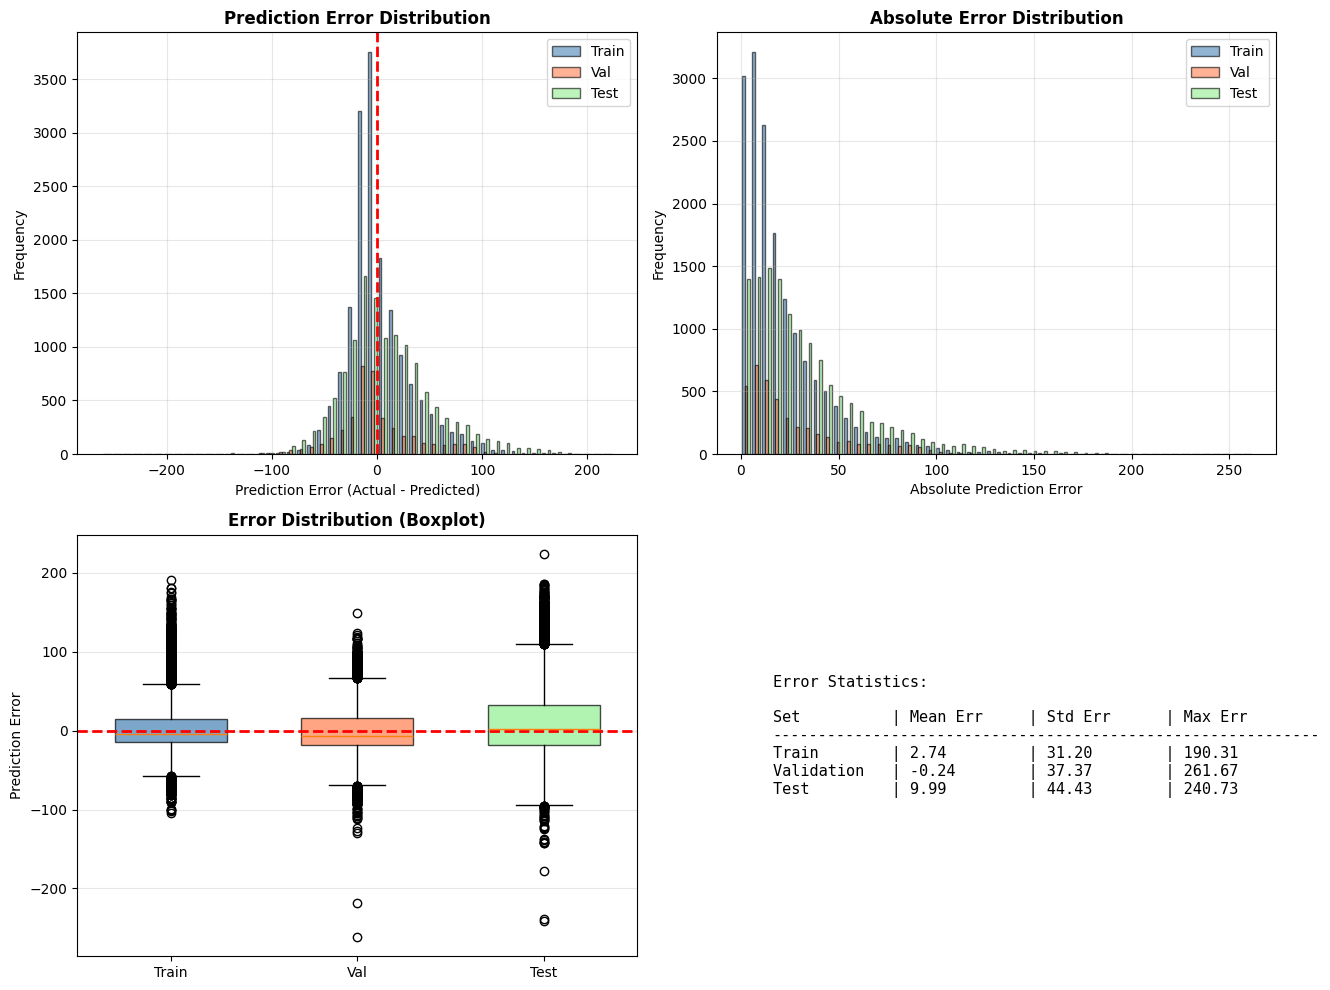


Error Statistics:
Set          | Mean Error   | Std Error    | Max Abs Error
------------------------------------------------------------
Train        | 2.74         | 31.20        | 190.31      
Validation   | -0.24        | 37.37        | 261.67      
Test         | 9.99         | 44.43        | 240.73      

Error distribution analysis complete


In [154]:
# 26c-viz3/ LSTM - Error Distribution
print_header("LSTM - Error Distribution")

# Calculate absolute errors
lstm_train_abs_errors = np.abs(lstm_train_residuals)
lstm_val_abs_errors = np.abs(lstm_val_residuals)
lstm_test_abs_errors = np.abs(lstm_test_residuals)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Error distribution histogram
axes[0, 0].hist([lstm_train_residuals, lstm_val_residuals, lstm_test_residuals], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Prediction Error Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Absolute error distribution
axes[0, 1].hist([lstm_train_abs_errors, lstm_val_abs_errors, lstm_test_abs_errors], 
                bins=50, 
                label=['Train', 'Val', 'Test'],
                color=['steelblue', 'coral', 'lightgreen'],
                alpha=0.6,
                edgecolor='black')
axes[0, 1].set_xlabel('Absolute Prediction Error')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Absolute Error Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Error boxplot
data_for_boxplot = [lstm_train_residuals, lstm_val_residuals, lstm_test_residuals]
box = axes[1, 0].boxplot(data_for_boxplot,
                          labels=['Train', 'Val', 'Test'],
                          patch_artist=True,
                          widths=0.6)
colors = ['steelblue', 'coral', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_ylabel('Prediction Error')
axes[1, 0].set_title('Error Distribution (Boxplot)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3, axis='y')

# 4. Error statistics table (as text)
axes[1, 1].axis('off')
error_stats_text = "Error Statistics:\n\n"
error_stats_text += f"{'Set':<12} | {'Mean Err':<12} | {'Std Err':<12} | {'Max Err':<12}\n"
error_stats_text += "-" * 60 + "\n"
error_stats_text += f"{'Train':<12} | {lstm_train_residuals.mean():<12.2f} | {lstm_train_residuals.std():<12.2f} | {lstm_train_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Validation':<12} | {lstm_val_residuals.mean():<12.2f} | {lstm_val_residuals.std():<12.2f} | {lstm_val_abs_errors.max():<12.2f}\n"
error_stats_text += f"{'Test':<12} | {lstm_test_residuals.mean():<12.2f} | {lstm_test_residuals.std():<12.2f} | {lstm_test_abs_errors.max():<12.2f}\n"

axes[1, 1].text(0.1, 0.5, error_stats_text, 
                fontsize=11, 
                fontfamily='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"{'Set':<12} | {'Mean Error':<12} | {'Std Error':<12} | {'Max Abs Error':<12}")
print("-" * 60)
print(f"{'Train':<12} | {lstm_train_residuals.mean():<12.2f} | {lstm_train_residuals.std():<12.2f} | {lstm_train_abs_errors.max():<12.2f}")
print(f"{'Validation':<12} | {lstm_val_residuals.mean():<12.2f} | {lstm_val_residuals.std():<12.2f} | {lstm_val_abs_errors.max():<12.2f}")
print(f"{'Test':<12} | {lstm_test_residuals.mean():<12.2f} | {lstm_test_residuals.std():<12.2f} | {lstm_test_abs_errors.max():<12.2f}")

print("\nError distribution analysis complete")

### 5.6) Model Comparison & Selection

In [168]:
# 27/ Model Comparison & Selection
print_header("Model Comparison & Selection")

# Create comparison dataframe from results_dict
print("Preparing model comparison table...")

comparison_data = []
for model_name, metrics in results_dict.items():
    comparison_data.append({
                            'Model': model_name,
                            'Train_RMSE': metrics['train_rmse'],
                            'Train_MAE': metrics['train_mae'],
                            'Train_R2': metrics['train_r2'],
                            'Val_RMSE': metrics['val_rmse'],
                            'Val_MAE': metrics['val_mae'],
                            'Val_R2': metrics['val_r2'],
                            'Test_RMSE': metrics['test_rmse'],
                            'Test_MAE': metrics['test_mae'],
                            'Test_R2': metrics['test_r2'],
                            'Train_Time': metrics['train_time']
                        })

comparison_df = pd.DataFrame(comparison_data)

# Display full comparison table
print("\nFull Model Comparison Table:")
print("=" * 120)
print(f"{'Model':<20}        | {'Train RMSE':<12} | {'Val RMSE':<12} | {'Test RMSE':<12} | {'Train R2':<10} | {'Val R2':<10} | {'Test R2':<10}")
print("-" * 120)
for idx, row in comparison_df.iterrows():
    print(f"{row['Model']:<20}        | {row['Train_RMSE']:<12.2f} | {row['Val_RMSE']:<12.2f} | {row['Test_RMSE']:<12.2f} | {row['Train_R2']:<10.4f} | {row['Val_R2']:<10.4f} | {row['Test_R2']:<10.4f}")
print("=" * 120)

# Display training time comparison
print("\nTraining Time Comparison:")
print(f"{'Model':<20} | {'Training Time (seconds)':<25}")
print("-" * 45)
for idx, row in comparison_df.iterrows():
    print(f"{row['Model']:<20} | {row['Train_Time']:<25.2f}")

# Find best models based on different metrics
print("\nBest Models by Metric:")
print("-" * 60)

best_test_rmse_idx = comparison_df['Test_RMSE'].idxmin()
best_test_rmse_model = comparison_df.loc[best_test_rmse_idx, 'Model']
best_test_rmse_value = comparison_df.loc[best_test_rmse_idx, 'Test_RMSE']
print(f"Best Test RMSE        : {best_test_rmse_model:<20} ({best_test_rmse_value:.2f})")

best_test_mae_idx = comparison_df['Test_MAE'].idxmin()
best_test_mae_model = comparison_df.loc[best_test_mae_idx, 'Model']
best_test_mae_value = comparison_df.loc[best_test_mae_idx, 'Test_MAE']
print(f"Best Test MAE         : {best_test_mae_model:<20} ({best_test_mae_value:.2f})")

best_test_r2_idx = comparison_df['Test_R2'].idxmax()
best_test_r2_model = comparison_df.loc[best_test_r2_idx, 'Model']
best_test_r2_value = comparison_df.loc[best_test_r2_idx, 'Test_R2']
print(f"Best Test R2          : {best_test_r2_model:<20} ({best_test_r2_value:.4f})")

fastest_model_idx = comparison_df['Train_Time'].idxmin()
fastest_model_name = comparison_df.loc[fastest_model_idx, 'Model']
fastest_model_time = comparison_df.loc[fastest_model_idx, 'Train_Time']
print(f"Fastest Training      : {fastest_model_name:<20} ({fastest_model_time:.2f}s)")

# Select overall best model based on validation RMSE
print("\nOverall Best Model Selection:")
print("-" * 60)
best_overall_idx = comparison_df['Val_RMSE'].idxmin()
best_overall_model = comparison_df.loc[best_overall_idx, 'Model']
best_overall_val_rmse = comparison_df.loc[best_overall_idx, 'Val_RMSE']
best_overall_test_rmse = comparison_df.loc[best_overall_idx, 'Test_RMSE']

print(f"Selected Model        : {best_overall_model}")
print(f"Validation RMSE       : {best_overall_val_rmse:.2f}")
print(f"Test RMSE             : {best_overall_test_rmse:.2f}")
print(f"Selection Criterion   : Lowest Validation RMSE")

# Model ranking by validation performance
print("\nModel Ranking by Validation RMSE:")
comparison_df_sorted = comparison_df.sort_values('Val_RMSE')
for rank, (idx, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    print(f"  {rank}. {row['Model']:<20} - Val RMSE: {row['Val_RMSE']:.2f}, Test RMSE: {row['Test_RMSE']:.2f}")

# Ensemble discussion
print("\nEnsemble Model Discussion:")
print("-" * 60)
print("Potential ensemble strategies:")
print("  1. Simple Average: Average predictions from top 3 models")
print("  2. Weighted Average: Weight by inverse validation RMSE")
print("  3. Stacking: Use meta-model to combine predictions")
print("  4. Voting: Median of predictions from multiple models")
print("\nEnsemble benefits:")
print("  - Reduces overfitting risk")
print("  - Combines strengths of different algorithms")
print("  - Often improves generalization")
print("\nConsiderations:")
print("  - Increased computational cost")
print("  - More complex deployment")
print("  - Diminishing returns if models are too similar")

# Calculate potential simple ensemble (top 3 models)
print("\nSimple Ensemble Analysis (Top 3 Models):")
top_3_models = comparison_df_sorted.head(3)['Model'].tolist()
print(f"Top 3 models: {', '.join(top_3_models)}")

print("\nModel comparison complete")


Model Comparison & Selection
Preparing model comparison table...

Full Model Comparison Table:
Model                       | Train RMSE   | Val RMSE     | Test RMSE    | Train R2   | Val R2     | Test R2   
------------------------------------------------------------------------------------------------------------------------
LSTM                        | 31.32        | 37.36        | 45.53        | 0.7978     | 0.6761     | 0.4040    
Random Forest               | 6.25         | 32.46        | 43.56        | 0.9919     | 0.7556     | 0.4545    
Linear Regression           | 43.15        | 36.69        | 46.02        | 0.6160     | 0.6877     | 0.3912    
Ridge Regression            | 43.15        | 36.65        | 45.99        | 0.6160     | 0.6884     | 0.3919    
XGBoost                     | 12.90        | 31.25        | 41.77        | 0.9657     | 0.7735     | 0.4985    
LightGBM                    | 15.47        | 30.59        | 41.63        | 0.9507     | 0.7828     | 0.5018    


Model Comparison - Bar Charts


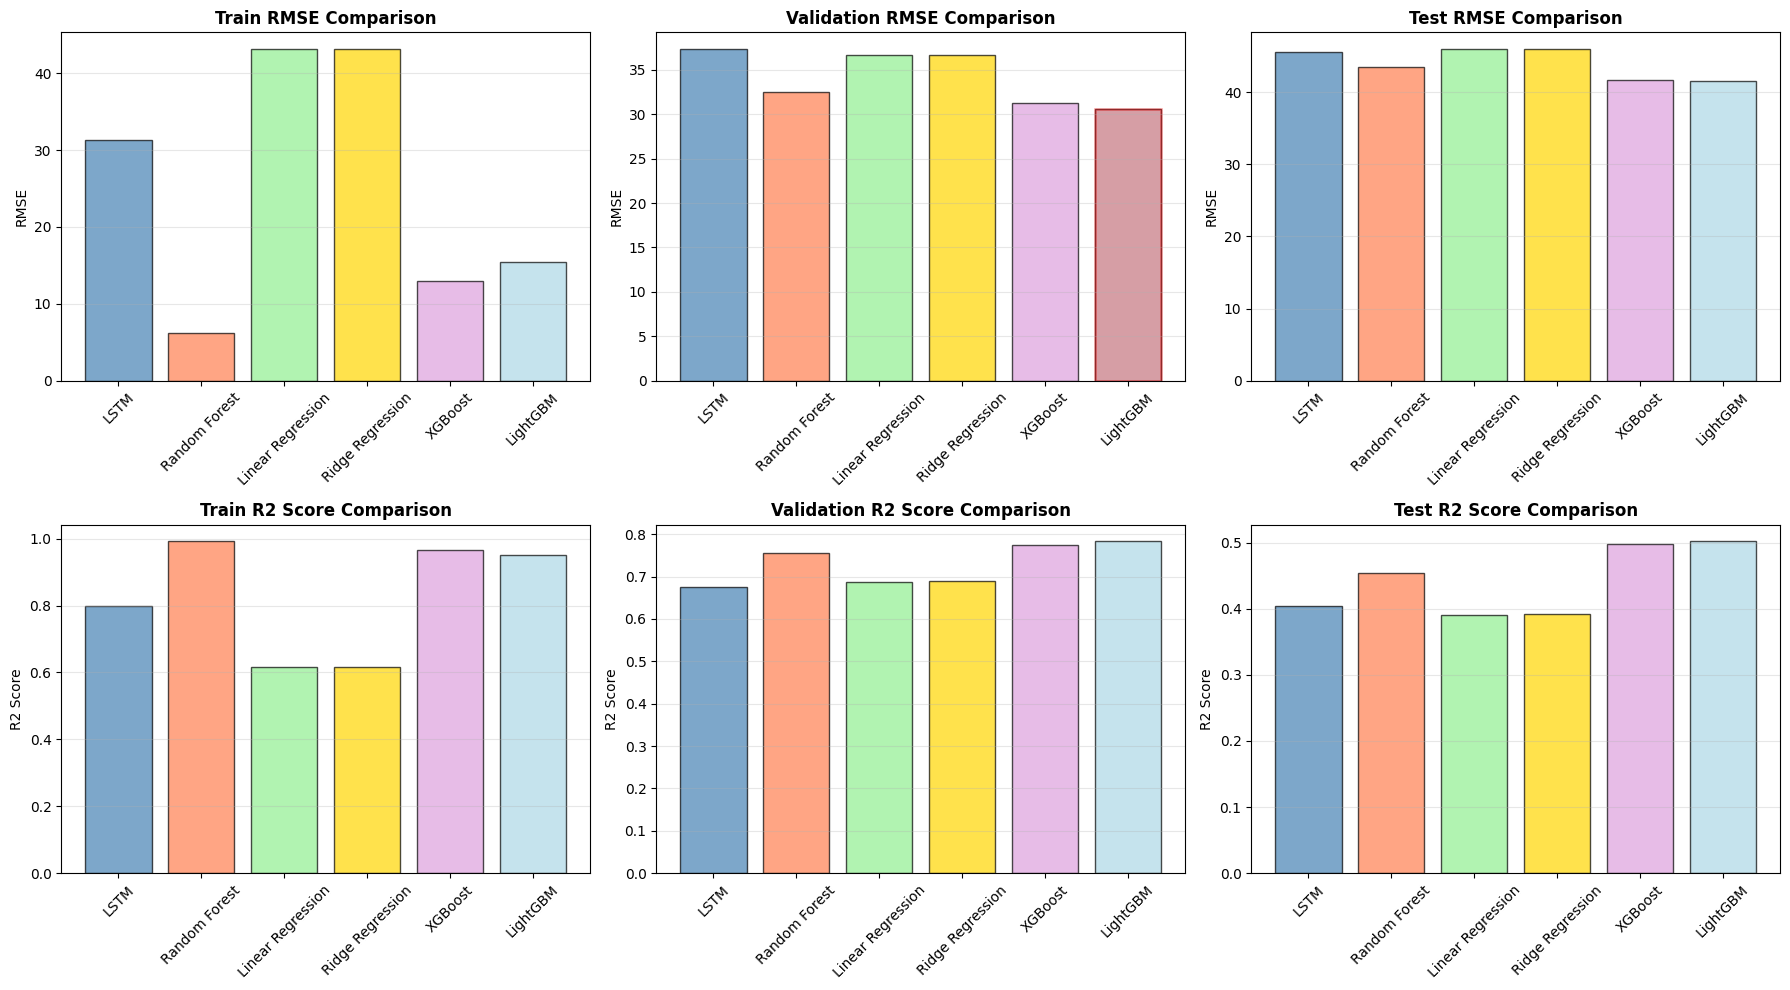


Bar chart comparison complete


In [156]:
# 27a-viz1/ Model Comparison - Bar Charts
print_header("Model Comparison - Bar Charts")

# Get model names and colors
model_names = comparison_df['Model'].tolist()
colors = ['steelblue', 'coral', 'lightgreen', 'gold', 'plum', 'lightblue'][:len(model_names)]

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Train RMSE comparison
axes[0, 0].bar(model_names, comparison_df['Train_RMSE'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('Train RMSE Comparison', fontsize=12, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Validation RMSE comparison
axes[0, 1].bar(model_names, comparison_df['Val_RMSE'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('Validation RMSE Comparison', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(alpha=0.3, axis='y')
# Highlight best model
best_val_idx = comparison_df['Val_RMSE'].idxmin()
axes[0, 1].bar(best_val_idx, comparison_df.loc[best_val_idx, 'Val_RMSE'], 
               color='red', alpha=0.3, edgecolor='red', linewidth=2)

# 3. Test RMSE comparison
axes[0, 2].bar(model_names, comparison_df['Test_RMSE'], color=colors, alpha=0.7, edgecolor='black')
axes[0, 2].set_ylabel('RMSE')
axes[0, 2].set_title('Test RMSE Comparison', fontsize=12, fontweight='bold')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(alpha=0.3, axis='y')

# 4. Train R2 comparison
axes[1, 0].bar(model_names, comparison_df['Train_R2'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('R2 Score')
axes[1, 0].set_title('Train R2 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(alpha=0.3, axis='y')

# 5. Validation R2 comparison
axes[1, 1].bar(model_names, comparison_df['Val_R2'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('R2 Score')
axes[1, 1].set_title('Validation R2 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(alpha=0.3, axis='y')

# 6. Test R2 comparison
axes[1, 2].bar(model_names, comparison_df['Test_R2'], color=colors, alpha=0.7, edgecolor='black')
axes[1, 2].set_ylabel('R2 Score')
axes[1, 2].set_title('Test R2 Score Comparison', fontsize=12, fontweight='bold')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nBar chart comparison complete")


Model Comparison - Performance Heatmap


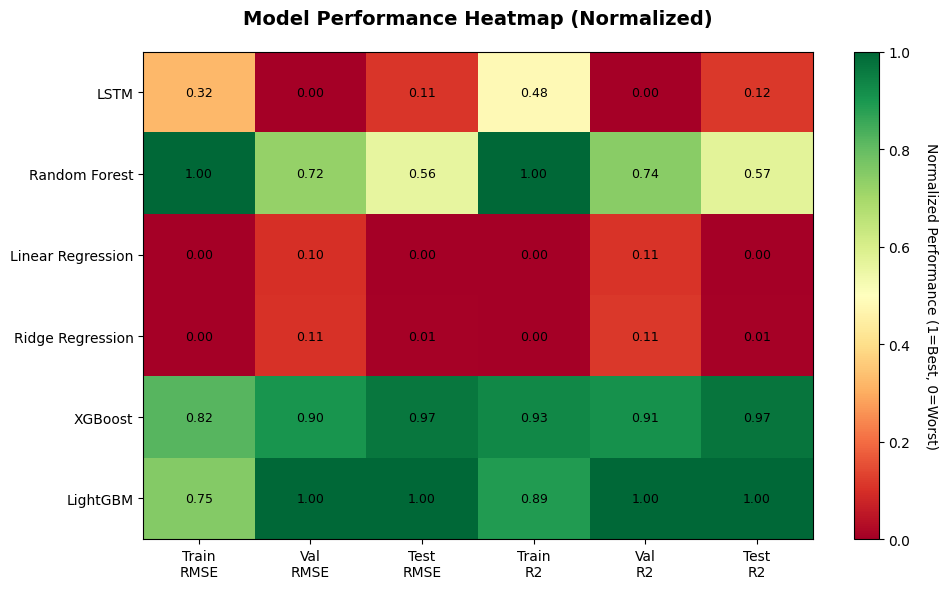


Heatmap visualization complete
Note: Green = Better performance, Red = Worse performance


In [ ]:
# 27b-viz2/ Model Comparison - Performance Heatmap
print_header("Model Comparison - Performance Heatmap")

# Prepare data for heatmap (normalized scores)
heatmap_data = comparison_df[['Model', 
                              'Train_RMSE', 
                              'Val_RMSE', 
                              'Test_RMSE', 
                                'Train_R2', 
                                'Val_R2', 
                                'Test_R2']].copy()

# Normalize RMSE (lower is better, so invert)
for col in ['Train_RMSE', 'Val_RMSE', 'Test_RMSE']:
    max_val = heatmap_data[col].max()
    min_val = heatmap_data[col].min()
    heatmap_data[col + '_norm'] = 1 - ((heatmap_data[col] - min_val) / (max_val - min_val))

# Normalize R2 (higher is better)
for col in ['Train_R2', 'Val_R2', 'Test_R2']:
    max_val = heatmap_data[col].max()
    min_val = heatmap_data[col].min()
    heatmap_data[col + '_norm'] = (heatmap_data[col] - min_val) / (max_val - min_val)

# Create heatmap matrix
heatmap_matrix = heatmap_data[['Train_RMSE_norm', 
                               'Val_RMSE_norm', 
                               'Test_RMSE_norm',
                                'Train_R2_norm', 
                                'Val_R2_norm', 
                                'Test_R2_norm']].values

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(heatmap_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Set ticks and labels
ax.set_xticks(range(6))
ax.set_yticks(range(len(model_names)))
ax.set_xticklabels(['Train\nRMSE', 
                    'Val\nRMSE', 
                    'Test\nRMSE', 
                    'Train\nR2', 
                    'Val\nR2', 
                    'Test\nR2'])
ax.set_yticklabels(model_names)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Normalized Performance (1=Best, 0=Worst)', rotation=270, labelpad=20)

# Add text annotations
for i in range(len(model_names)):
    for j in range(6):
        text = ax.text(j, i, f'{heatmap_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=9)

ax.set_title('Model Performance Heatmap (Normalized)', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nHeatmap visualization complete")
print("Note: Green = Better performance,\n      Red = Worse performance")


Model Comparison - Training Time vs Performance


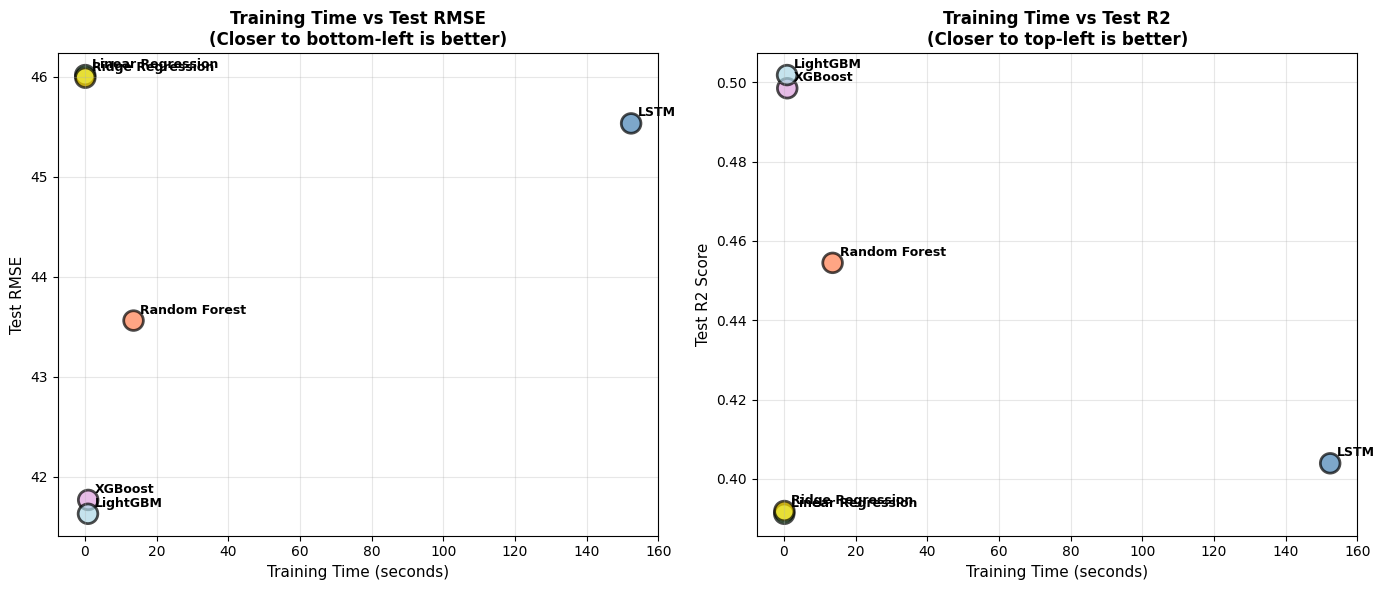


Training time comparison complete
Note: Ideal models are fast (left) and accurate (low RMSE/high R2)


In [158]:
# 27c-viz3/ Model Comparison - Training Time vs Performance
print_header("Model Comparison - Training Time vs Performance")

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Training time vs Test RMSE
axes[0].scatter(comparison_df['Train_Time'], comparison_df['Test_RMSE'], 
                s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for idx, row in comparison_df.iterrows():
    axes[0].annotate(row['Model'], 
                    (row['Train_Time'], row['Test_RMSE']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')
axes[0].set_xlabel('Training Time (seconds)', fontsize=11)
axes[0].set_ylabel('Test RMSE', fontsize=11)
axes[0].set_title('Training Time vs Test RMSE\n(Closer to bottom-left is better)', 
                 fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# 2. Training time vs Test R2
axes[1].scatter(comparison_df['Train_Time'], comparison_df['Test_R2'], 
                s=200, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for idx, row in comparison_df.iterrows():
    axes[1].annotate(row['Model'], 
                    (row['Train_Time'], row['Test_R2']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, fontweight='bold')
axes[1].set_xlabel('Training Time (seconds)', fontsize=11)
axes[1].set_ylabel('Test R2 Score', fontsize=11)
axes[1].set_title('Training Time vs Test R2\n(Closer to top-left is better)', 
                 fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining time comparison complete")
print("Note: Ideal models are fast (left) and accurate (low RMSE/high R2)")


Model Comparison - Radar Chart


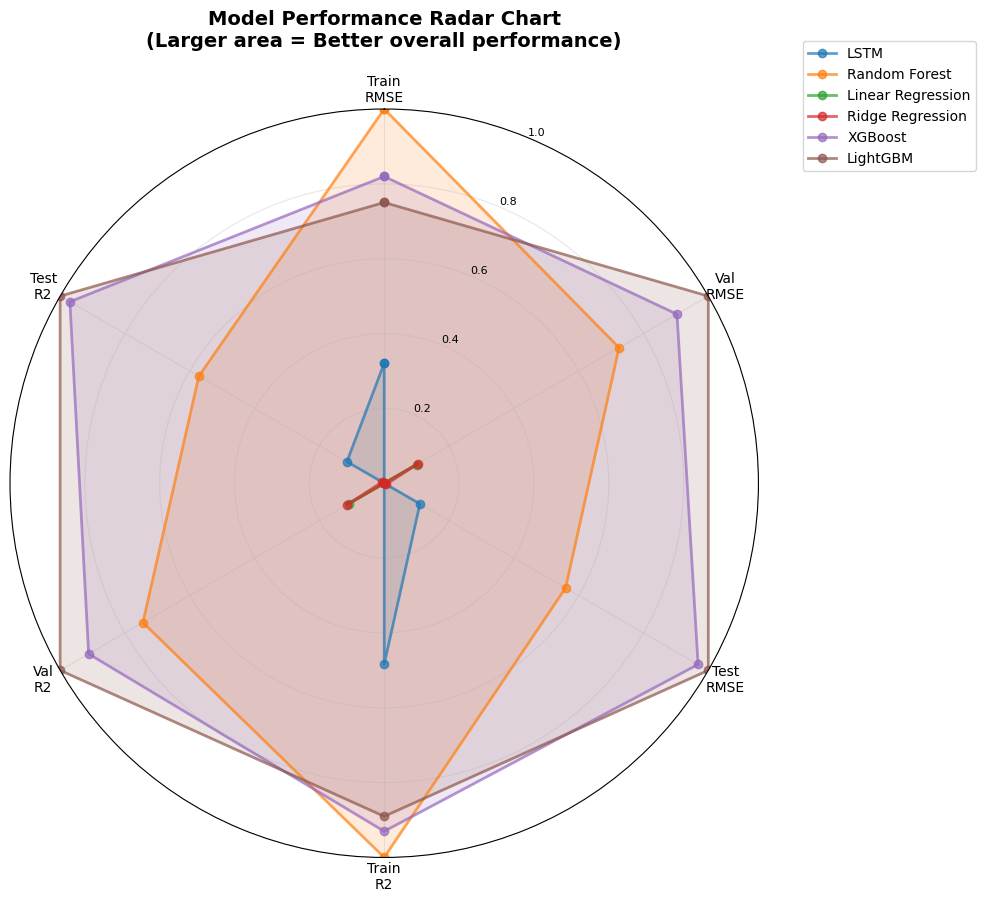


Radar chart visualization complete
Note: Models with larger filled areas perform better overall


In [159]:
# 27d-viz4/ Model Comparison - Radar Chart
print_header("Model Comparison - Radar Chart")

# Prepare normalized metrics for radar chart
radar_metrics = ['Train_RMSE_norm', 
                 'Val_RMSE_norm', 
                 'Test_RMSE_norm', 
                 'Train_R2_norm', 
                 'Val_R2_norm', 
                 'Test_R2_norm']

radar_labels = ['Train\nRMSE', 
                'Val\nRMSE', 
                'Test\nRMSE', 
                'Train\nR2', 
                'Val\nR2', 
                'Test\nR2']

# Use normalized data from heatmap preparation
num_metrics = len(radar_metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Create figure
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each model
for idx, row in heatmap_data.iterrows():
    values = row[radar_metrics].tolist()
    values += values[:1]  # Complete the circle
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], alpha=0.7)
    ax.fill(angles, values, alpha=0.15)

# Set labels and styling
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_labels, fontsize=10)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_title('Model Performance Radar Chart\n(Larger area = Better overall performance)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)

plt.tight_layout()
plt.show()

print("\nRadar chart visualization complete")
print("Note: Models with larger filled areas perform better overall")

### 5.7) Best Model Deep Dive

### 5.8) Final Test Evaluation